# Imports

In [39]:
import numpy as np
import pandas as pd
import seaborn as sns

import re
import pickle
from unidecode import unidecode
import category_encoders as ce
import requests
import IPython.display as display
from PIL import Image

from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import gridspec
from joypy import joyplot

from sklearn import metrics as mt
from sklearn import ensemble as en
from sklearn import model_selection as ms
from sklearn import preprocessing as pp
from sklearn.impute import KNNImputer
from sklearn import metrics as mt
from boruta import BorutaPy
from sklearn import linear_model as lm
import xgboost
import optuna
import plotly  

import warnings
warnings.filterwarnings("ignore")

## Functions

In [40]:
def extract_power(re_string):
    hp = 'sem informação'
    if re_string is None:
        pass
    else:
         hp = re_string.group(0)
    return hp

def ml_error(model_name, y, yhat):
    mae = mt.mean_absolute_error(y,yhat)
    mape = mt.mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt(mt.mean_squared_error(y,yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE':mape,
                         'RMSE':rmse},index=[0])

def train_preparation(x_train_prep, y_train_prep):
    # transforma response variable
    y_train_prep = pd.DataFrame(np.log1p(y_train_prep))

    # standarization
    sc = pp.StandardScaler()
    y_train_norm_prep = sc.fit_transform(y_train_prep)
    pickle.dump(sc, open('api/parameters/sc_response.pkl','wb'))
    
    sc = pp.StandardScaler()
    x_train_prep['km_media_ano_em_1k_km'] = sc.fit_transform(x_train_prep[['km_media_ano_em_1k_km']])
    pickle.dump(sc, open('api/parameters/sc_km_media_ano.pkl','wb'))

    # rescaling
    rs = pp.RobustScaler()

    x_train_prep['ano_de_fabricacao'] = rs.fit_transform(x_train_prep[['ano_de_fabricacao']])
    pickle.dump(rs, open('api/parameters/rs_ano_de_fabricacao.pkl','wb'))

    x_train_prep['ano_modelo'] = rs.fit_transform(x_train_prep[['ano_modelo']])
    pickle.dump(rs, open('api/parameters/rs_ano_modelo.pkl','wb'))

    x_train_prep['odometro'] = rs.fit_transform(x_train_prep[['odometro']])
    pickle.dump(rs, open('api/parameters/rs_odometro.pkl','wb'))

    # encodings
    ## one hot encode

    # blindado
    x_train_prep['blindado'] = x_train_prep['blindado'].replace({'S':1, 'N':0})

    # tipo_vendedor
    x_train_prep['tipo_vendedor'] = x_train_prep['tipo_vendedor'].replace({'PJ':1, 'PF':0})

    # tipo_anuncio
    oe = pp.OneHotEncoder(sparse=False,handle_unknown='ignore')
    x_train_prep['tipo_anuncio'] = x_train_prep['tipo_anuncio'].apply(lambda x: unidecode(x).lower().replace(' ','_'))
    cols_dummies = oe.fit_transform(x_train_prep['tipo_anuncio'].values.reshape(-1,1))
    x_train_prep[oe.categories_[0]] = cols_dummies
    pickle.dump(oe,open(f'api/parameters/oe_tipo_anuncio.pkl', 'wb'))

    x_train_prep['cambio'] = x_train_prep['cambio'].map({'Manual':0,
                                                'Automática Sequencial':1, 
                                                'Semi-automática':2,
                                                'CVT':3,
                                                'Automatizada':4,
                                                'Automática':4,
                                                'Automatizada DCT':5
                                                })

    x_train_prep['num_portas'] = x_train_prep['num_portas'].apply(lambda x: 1 if x > 2 else 0)

    # target encode
    for att in ['tipo','cor', 'localidade_vendedor','valvulas','combustivel', 'veiculo']:
        te = ce.TargetEncoder(cols=[att]).fit(x_train_prep, y_train_norm_prep)
        pickle.dump(te, open(f'api/parameters/te_{att}.pkl','wb'))
        x_train_prep = te.transform(x_train_prep)

    # frequency encode
    for att in ['marca', 'modelo','versao','cilindradas']:
        fe =  ce.CountEncoder(cols=[att], normalize=True).fit(x_train_prep)
        pickle.dump(fe,open(f'api/parameters/fe_{att}.pkl', 'wb'))
        x_train_prep = fe.transform(x_train_prep)
    
    return x_train_prep, y_train_prep

def test_preparation(x_test_prep, y_test_prep):
   
    # Transformando variável resposta
    y_test_prep = pd.DataFrame(np.log1p(y_test_prep))
    
    # Standarization
    sc = pickle.load(open('api/parameters/sc_km_media_ano.pkl','rb'))
    x_test_prep['km_media_ano_em_1k_km'] = sc.transform(x_test_prep[['km_media_ano_em_1k_km']])

    # Rescaling
    rs = pickle.load(open('api/parameters/rs_ano_de_fabricacao.pkl','rb'))
    x_test_prep['ano_de_fabricacao'] = rs.transform(x_test_prep[['ano_de_fabricacao']])

    rs = pickle.load(open('api/parameters/rs_ano_modelo.pkl','rb'))
    x_test_prep['ano_modelo'] = rs.transform(x_test_prep[['ano_modelo']])

    rs = pickle.load(open('api/parameters/rs_odometro.pkl','rb'))
    x_test_prep['odometro'] = rs.transform(x_test_prep[['odometro']])

    # Encode
    ## One Hot Encode
    # blindado
    x_test_prep['blindado'] = x_test_prep['blindado'].replace({'S':1, 'N':0})

    # tipo_vendedor
    x_test_prep['tipo_vendedor'] = x_test_prep['tipo_vendedor'].replace({'PJ':1, 'PF':0})

    # tipo_anuncio
    oe = pickle.load(open(f'api/parameters/oe_tipo_anuncio.pkl', 'rb'))
    x_test_prep['tipo_anuncio'] = x_test_prep['tipo_anuncio'].apply(lambda x: unidecode(x).lower().replace(' ','_'))
    cols_dummies = oe.transform(x_test_prep['tipo_anuncio'].values.reshape(-1,1))
    x_test_prep[oe.categories_[0]] = cols_dummies

    x_test_prep['cambio'] = x_test_prep['cambio'].map({'Manual':0,
                                                'Automática Sequencial':1, 
                                                'Semi-automática':2,
                                                'CVT':3,
                                                'Automatizada':4,
                                                'Automática':4,
                                                'Automatizada DCT':5
                                                })

    x_test_prep['num_portas'] = x_test_prep['num_portas'].apply(lambda x: 1 if x > 2 else 0)

    ## Target Encode
    for att in ['tipo','cor', 'localidade_vendedor','valvulas','combustivel', 'veiculo']:
        te = pickle.load(open(f'api/parameters/te_{att}.pkl','rb'))
        x_test_prep = te.transform(x_test_prep)

    ## Frequency Encode

    for att in ['marca', 'modelo','versao','cilindradas']:
        fe = pickle.load(open(f'api/parameters/fe_{att}.pkl', 'rb'))
        x_test_prep = fe.transform(x_test_prep)
        
    ## KNN Imputer
    ## Preenche valores de target e frequency encode não encontratos
    imputer = KNNImputer(n_neighbors=5, copy=True)
    original_index = x_test_prep.index
    x_test_prep = pd.DataFrame(imputer.fit_transform(x_test_prep.drop(['cidade_vendedor','estado_vendedor','tipo_anuncio'],axis=1)),columns = x_test_prep.drop(['cidade_vendedor','estado_vendedor','tipo_anuncio'],axis=1).columns)
    x_test_prep.index = original_index    
    return x_test_prep, y_test_prep

def cross_validation_k_fold(X_cross, y_cross, features_selected, model_name, model, k):

    cv_results = pd.DataFrame()
    
    k_fold = ms.KFold(n_splits=k)
    
    X_cross = feature_engineering(X_cross)
    
    cols_drop = [
         'ID',
         'num_fotos',
         'attr_veiculo_aceita_troca',
         'attr_veiculo_único_dono',
         'attr_veiculo_todas_as_revisões_feitas_pela_concessionária',
         'attr_veiculo_ipva_pago',
         'attr_veiculo_licenciado',
         'attr_veiculo_garantia_de_fábrica',
         'attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro',
         'attr_veiculo_alienado']

    X_cross = X_cross.drop(columns=cols_drop)

    ## Para cada k_fold
    for i, (train_index, test_index) in enumerate(k_fold.split(X_cross)):

        # Separar treino e teste
        X_train_cross, y_train_cross = X_cross.loc[train_index], y_cross.iloc[train_index]

        X_test_cross, y_test_cross = X_cross.loc[test_index], y_cross.iloc[test_index]

        ## Data Preparation
        # Transformar treino
        X_train_cross, y_train_cross = train_preparation(X_train_cross, y_train_cross)

        # Transformar teste
        X_test_cross, y_test_cross = test_preparation(X_test_cross, y_test_cross)

        ## Treinar modelo
        model.fit(X_train_cross[features_selected], y_train_cross)

        ## Predict
        y_pred_cross = model.predict(X_test_cross[features_selected])

        ## Performance
        result_model = ml_error(model_name, np.expm1(y_test_cross), np.expm1(y_pred_cross))

        ## Salvar resultado
        cv_results = pd.concat([cv_results, result_model.drop('Model Name', axis=1)], axis=0)
        
    cv_values = round(cv_results.mean(),3)
    cv_std = round(cv_results.std(),3)
    return pd.DataFrame({'Model': model_name,
                 'MAE': cv_values['MAE'].astype(str) + ' +/- ' + cv_std['MAE'].astype(str),
                 'MAPE': cv_values['MAPE'].astype(str) + ' +/- ' + cv_std['MAPE'].astype(str),
                 'RMSE': cv_values['RMSE'].astype(str) + ' +/- ' + cv_std['RMSE'].astype(str)}, index=[0])

def feature_engineering(df4):
    
    df_feature_engineering = df4.copy()
    # extraindo as cilindradas da coluna versão
    df_feature_engineering['cilindradas'] = df_feature_engineering['versao'].apply(lambda x: extract_power(re.search(r"\d+\.\d+",x)))

    # extraindo válvulas da coluna versão
    df_feature_engineering['valvulas'] = df_feature_engineering['versao'].apply(lambda x: extract_power(re.search(r"\d+V",x)))

    # extraindo combustível da coluna versão
    df_feature_engineering['combustivel'] = df_feature_engineering['versao'].apply(lambda x: 'GASOLINA' if 'GASOLINA' in x else 
                                                       'FLEX' if 'FLEX'     in x else 
                                                       'DIESEL' if 'DIESEL'   in x else 
                                                       'ÁLCOOL' if 'ÁLCOOL' in x else
                                                       'HÍBRIDO' if 'HYBRID' in x else
                                                       'HÍBRIDO' if 'HÍBRIDO' in x else 'sem informação')

    # removendo features derivadas da coluna original
    df_feature_engineering['versao'] = df_feature_engineering.apply(lambda x: x['versao'].replace(x['cilindradas'],'').replace(x['valvulas'], '').replace(x['combustivel'],'').replace(' AUTOMÁTICO', '').replace(' MANUAL', '').replace('  ',' '), axis=1)

    # retirando acentos, substituindo letras maiúsculas e espaços
    df_feature_engineering['cidade_vendedor'] = df_feature_engineering['cidade_vendedor'].apply(lambda x: unidecode(x).lower().replace(' ','_'))

    # extraindo estado
    df_feature_engineering['estado_vendedor'] = df_feature_engineering['estado_vendedor'].apply(lambda x: re.search(r'\((.*?)\)',x).group(1))

    # criando feature de localidade
    df_feature_engineering['localidade_vendedor'] = df_feature_engineering['cidade_vendedor'] + "_" + df_feature_engineering['estado_vendedor']

    # criando feature de km médio rodado por ano
    df_feature_engineering['km_media_ano_em_1k_km'] = df_feature_engineering['odometro']/np.round(2023 - df_feature_engineering['ano_modelo'] + 0.51,0)
    # arredondando e escalando por 1000 km
    df_feature_engineering['km_media_ano_em_1k_km'] = round(df_feature_engineering['km_media_ano_em_1k_km'] / 1000, 0).astype(int)

    # criando feature de agregação do veículo com marca, modelo, km_media e localidade
    df_feature_engineering['veiculo'] = df_feature_engineering['marca'].astype(str) + "_" + df_feature_engineering['modelo'].astype(str)# + "_" + df_feature_engineering['km_media_ano_em_1k_km'].astype(str)
    
    return df_feature_engineering

# objetctive function optuna
def tuning_cross_validation(trial, X_tuning, y_tuning, features_selected):
    
    # list of rmse
    rmse_list = list()
    
    # k folds
    k_fold = ms.KFold(n_splits=10)
    
    print('Trial: {}'.format(trial.number))    
    ## Para cada k_fold
    for i, (train_index, test_index) in enumerate(k_fold.split(X_tuning)):
        
        # Separar treino e teste
        X_train_cross, y_train_cross = X_tuning.loc[train_index], y_tuning.iloc[train_index]

        X_test_cross, y_test_cross = X_tuning.loc[test_index], y_tuning.iloc[test_index]

        ## Data Preparation
        # Transformar treino
        X_train_cross, y_train_cross = train_preparation(X_train_cross, y_train_cross)

        # Transformar teste
        X_test_cross, y_test_cross = test_preparation(X_test_cross, y_test_cross)

        n_estimators = trial.suggest_int('n_estimators',50, 500)
        eta = trial.suggest_float('eta',0.01, 0.05)
        max_depth = trial.suggest_int('max_depth', 3, 9)
        subsample = trial.suggest_float('subsample',0.1, 0.9)
        colsample_bytree = trial.suggest_float('colsample_bytree',0.1,0.9)

        # model definition
        xgb_model = xgboost.XGBRegressor( n_estimators    = n_estimators, 
                                          eta              = eta, 
                                          max_depth        = max_depth, 
                                          subsample        = subsample,
                                          colsample_bytree = colsample_bytree
                                         )
        # model fit
        xgb_model.fit(X_train_cross[features_selected],y_train_cross)

        # ==== Model Prediction 
        # model prediction
        y_pred_xgb = xgb_model.predict(X_test_cross[features_selected])
        
        # calculando rmse
        rmse = np.sqrt(mt.mean_squared_error(np.expm1(y_test_cross),np.expm1(y_pred_xgb)))
        
        # adicionando à lista
        rmse_list.append(rmse)
        
        print('k_fold: {}   rmse: {}   rmse_mean: {}'.format(i, rmse, np.mean(rmse_list)))
        
    return np.mean(rmse_list) # retorna a média do RMSE 

# Load Dataset

In [41]:
df_raw = pd.read_csv('datasets/treino.csv')

In [42]:
df_raw.shape

(39446, 29)

In [43]:
X = df_raw.drop(columns=['preco'])
y = df_raw['preco']

## Split Dataset

In [44]:
X_train_raw, X_test_raw, y_train_raw, y_test_raw = ms.train_test_split(X, y, test_size=0.2, random_state=0)

data_train = pd.concat([X_train_raw,y_train_raw], axis=1)
data_test = pd.concat([X_test_raw,y_test_raw], axis=1)

In [45]:
print(f'Treino: {data_train.shape[0]}')
print(f'Test: {data_test.shape[0]}')

Treino: 31556
Test: 7890


In [46]:
df = data_train.copy()

In [47]:
df.sample(3)

ID  num_fotos       marca  \
23940  111516166841277177101974904992881127060        8.0  LAND ROVER   
30345  179566743580404303287391426563342827646        8.0  VOLKSWAGEN   
11513  325034699916672000465420792157174639005       16.0       HONDA   

                modelo                                         versao  \
23940  DISCOVERY SPORT  2.0 16V D240 BITURBO DIESEL HSE 4P AUTOMÁTICO   
30345            JETTA               1.4 250 TSI TOTAL FLEX TIPTRONIC   
11513             WR-V                        1.5 16V FLEXONE EXL CVT   

       ano_de_fabricacao  ano_modelo  odometro      cambio  num_portas  ...  \
23940               2018      2018.0   37793.0  Automática           4  ...   
30345               2019      2019.0   33613.0  Automática           4  ...   
11513               2018      2019.0   30530.0         CVT           4  ...   

      elegivel_revisao attr_veiculo_aceita_troca attr_veiculo_único_dono  \
23940            False              Aceita troca                     NaN   
30345            False                       NaN              Único dono   
11513            False              Aceita troca                     NaN   

      attr_veiculo_todas_as_revisões_feitas_pela_concessionária  \
23940       Todas as revisões feitas pela concessionária          
30345       Todas as revisões feitas pela concessionária          
11513                                                NaN          

      attr_veiculo_ipva_pago attr_veiculo_licenciado  \
23940              IPVA pago              Licenciado   
30345              IPVA pago              Licenciado   
11513                    NaN                     NaN   

      attr_veiculo_garantia_de_fábrica  \
23940                              NaN   
30345              Garantia de fábrica   
11513                              NaN   

       attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro  \
23940                                                NaN            
30345      Todas as revisões feitas pela agenda do carro            
11513                                                NaN            

       attr_veiculo_alienado          preco  
23940                    NaN  228960.216096  
30345                    NaN  117545.956162  
11513                    NaN  100027.560117  

[3 rows x 29 columns]

# Data Description

In [48]:
df.columns.tolist()

['ID',
 'num_fotos',
 'marca',
 'modelo',
 'versao',
 'ano_de_fabricacao',
 'ano_modelo',
 'odometro',
 'cambio',
 'num_portas',
 'tipo',
 'blindado',
 'cor',
 'tipo_vendedor',
 'cidade_vendedor',
 'estado_vendedor',
 'tipo_anuncio',
 'entrega_delivery',
 'troca',
 'elegivel_revisao',
 'attr_veiculo_aceita_troca',
 'attr_veiculo_único_dono',
 'attr_veiculo_todas_as_revisões_feitas_pela_concessionária',
 'attr_veiculo_ipva_pago',
 'attr_veiculo_licenciado',
 'attr_veiculo_garantia_de_fábrica',
 'attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro',
 'attr_veiculo_alienado',
 'preco']

## Data Dimension

In [49]:
print(f'Número de linhas: {df.shape[0]}')
print(f'Número de colunas: {df.shape[1]}')

Número de linhas: 31556
Número de colunas: 29


## Data Types

In [50]:
df.dtypes

ID                                                             object
num_fotos                                                     float64
marca                                                          object
modelo                                                         object
versao                                                         object
ano_de_fabricacao                                               int64
ano_modelo                                                    float64
odometro                                                      float64
cambio                                                         object
num_portas                                                      int64
tipo                                                           object
blindado                                                       object
cor                                                            object
tipo_vendedor                                                  object
cidade_vendedor     

## Check NAs

In [51]:
df.isna().sum()

ID                                                                0
num_fotos                                                       188
marca                                                             0
modelo                                                            0
versao                                                            0
ano_de_fabricacao                                                 0
ano_modelo                                                        0
odometro                                                          0
cambio                                                            0
num_portas                                                        0
tipo                                                              0
blindado                                                          0
cor                                                               0
tipo_vendedor                                                     0
cidade_vendedor                                 

## Filtering Data

In [52]:
# removendo colunas que possuem NA's + id
 
cols_drop = [
 'ID',
 'num_fotos',
 'attr_veiculo_aceita_troca',
 'attr_veiculo_único_dono',
 'attr_veiculo_todas_as_revisões_feitas_pela_concessionária',
 'attr_veiculo_ipva_pago',
 'attr_veiculo_licenciado',
 'attr_veiculo_garantia_de_fábrica',
 'attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro',
 'attr_veiculo_alienado']

df = df.drop(columns=cols_drop)

## Descriptive Statistical

Objetivos: 
1. Ganhar conhecimento de negócio 
2. Detectar erros nos dados


### Numerical Attributes

In [53]:
num_attributes = df.select_dtypes(include=['int64','float64'])
cat_attributes = df.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

In [54]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max','range','mean','median','std','skew','kurtosis']
m

attributes          min           max         range           mean  \
0  ano_de_fabricacao  1985.000000  2.022000e+03  3.700000e+01    2016.751331   
1         ano_modelo  1997.000000  2.023000e+03  2.600000e+01    2017.811351   
2           odometro   100.000000  3.817280e+05  3.816280e+05   58330.343009   
3         num_portas     2.000000  4.000000e+00  2.000000e+00       3.940170   
4              preco  7258.159943  1.352089e+06  1.344831e+06  133677.588245   

          median           std      skew   kurtosis  
0    2018.000000      4.088403 -2.511113   9.262741  
1    2018.000000      2.676889 -0.504198  -0.513283  
2   57180.000000  32483.482401  0.579675   1.034479  
3       4.000000      0.339775 -5.519150  28.510117  
4  114620.767775  82725.230480  2.262564  12.754476

### Categorical Attributes

- "entrega_delivery", "troca" e "elegivel_revisao" parecem ser variáveis com baixo poder preditivo pois sua distribuição em relação ao preção é bem parecida para cada uma de suas labels

In [55]:
for col in cat_attributes.columns.tolist():
    elements = df[col].unique().tolist()
    n_elements = len(elements)
    
    print(f'{col}: {n_elements}')

marca: 41
modelo: 466
versao: 1945
cambio: 7
tipo: 8
blindado: 2
cor: 7
tipo_vendedor: 2
cidade_vendedor: 593
estado_vendedor: 25
tipo_anuncio: 4
entrega_delivery: 2
troca: 2
elegivel_revisao: 1


#### Marca

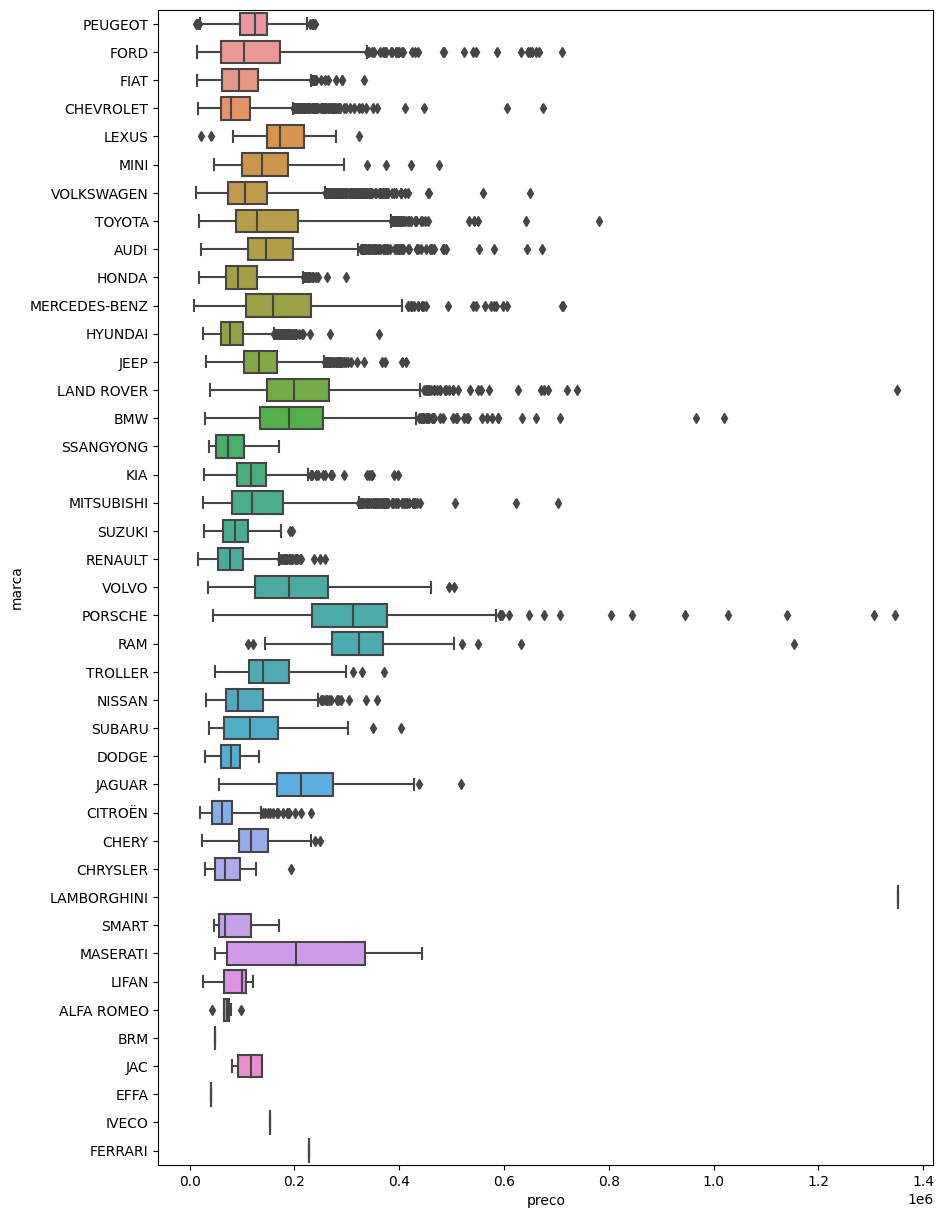

In [56]:
plt.figure(figsize=(10,15))
sns.boxplot(x='preco' , y='marca' , data=df);

#### Cambio

<Axes: xlabel='cambio', ylabel='preco'>

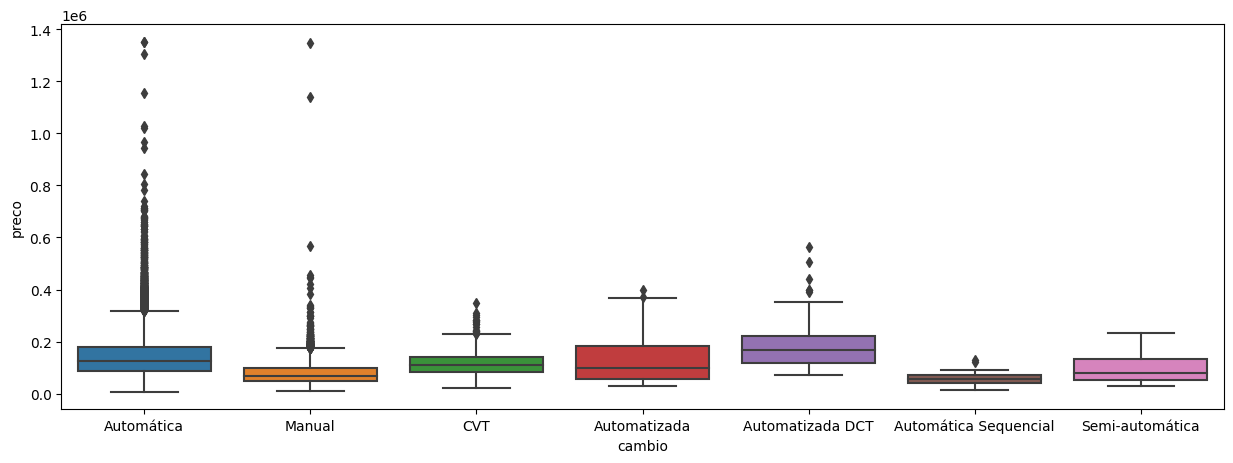

In [57]:
plt.figure(figsize=(15,5))
sns.boxplot(x='cambio' , y='preco' , data=df)

#### Tipo

<Axes: xlabel='tipo', ylabel='preco'>

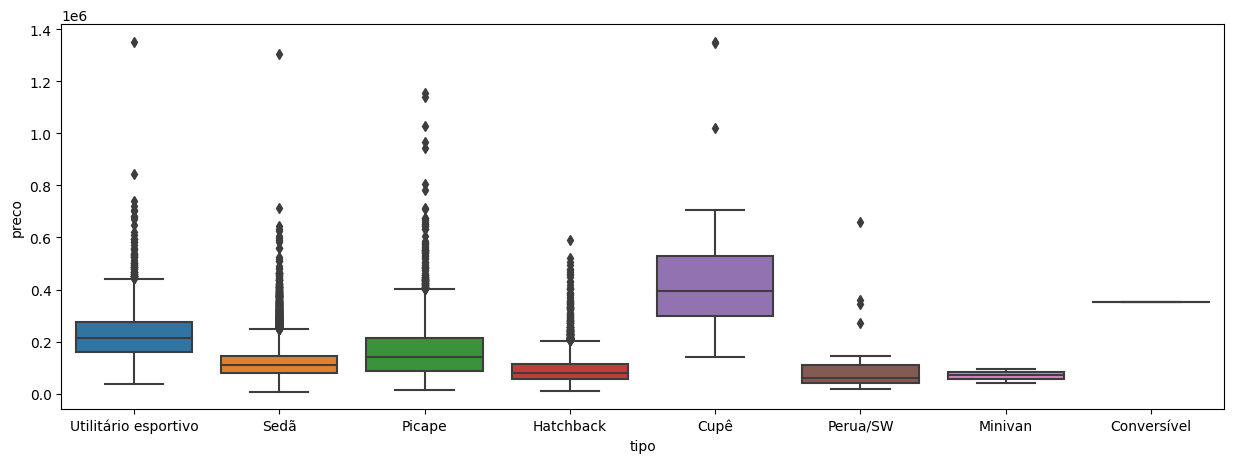

In [58]:
plt.figure(figsize=(15,5))
sns.boxplot(x='tipo' , y='preco' , data=df)

#### Blindado

<Axes: xlabel='blindado', ylabel='preco'>

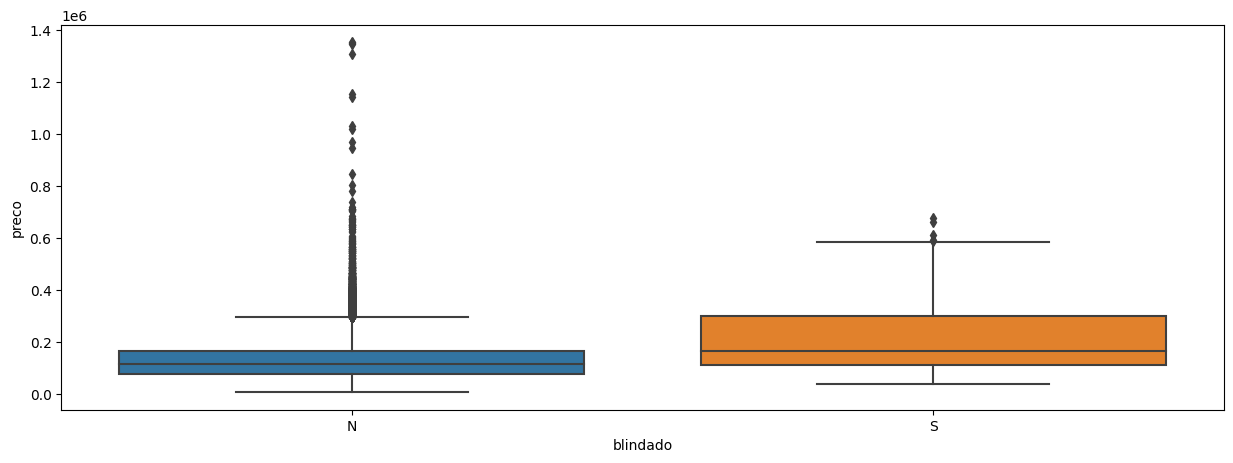

In [59]:
plt.figure(figsize=(15,5))
sns.boxplot(x='blindado' , y='preco' , data=df)

#### Cor

<Axes: xlabel='cor', ylabel='preco'>

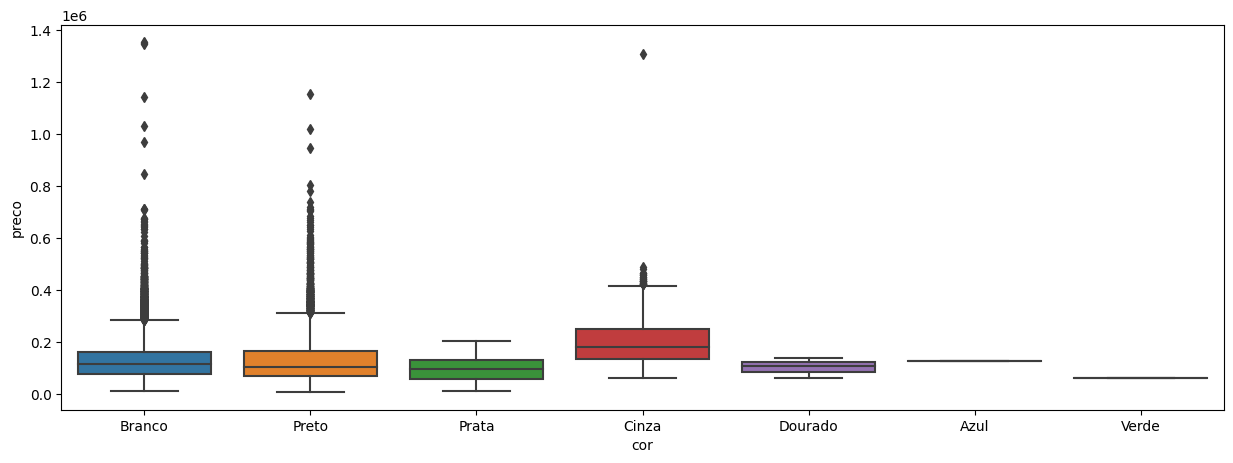

In [60]:
plt.figure(figsize=(15,5))
sns.boxplot(x='cor' , y='preco' , data=df)

#### Tipo Vendedor

<Axes: xlabel='tipo_vendedor', ylabel='preco'>

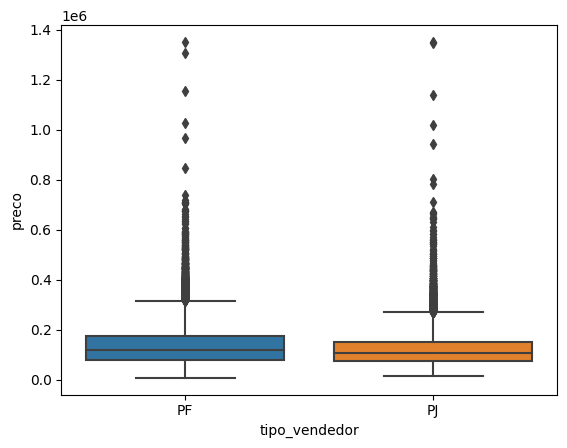

In [61]:
sns.boxplot(x='tipo_vendedor' , y='preco' , data=df)

#### Estado Vendedor

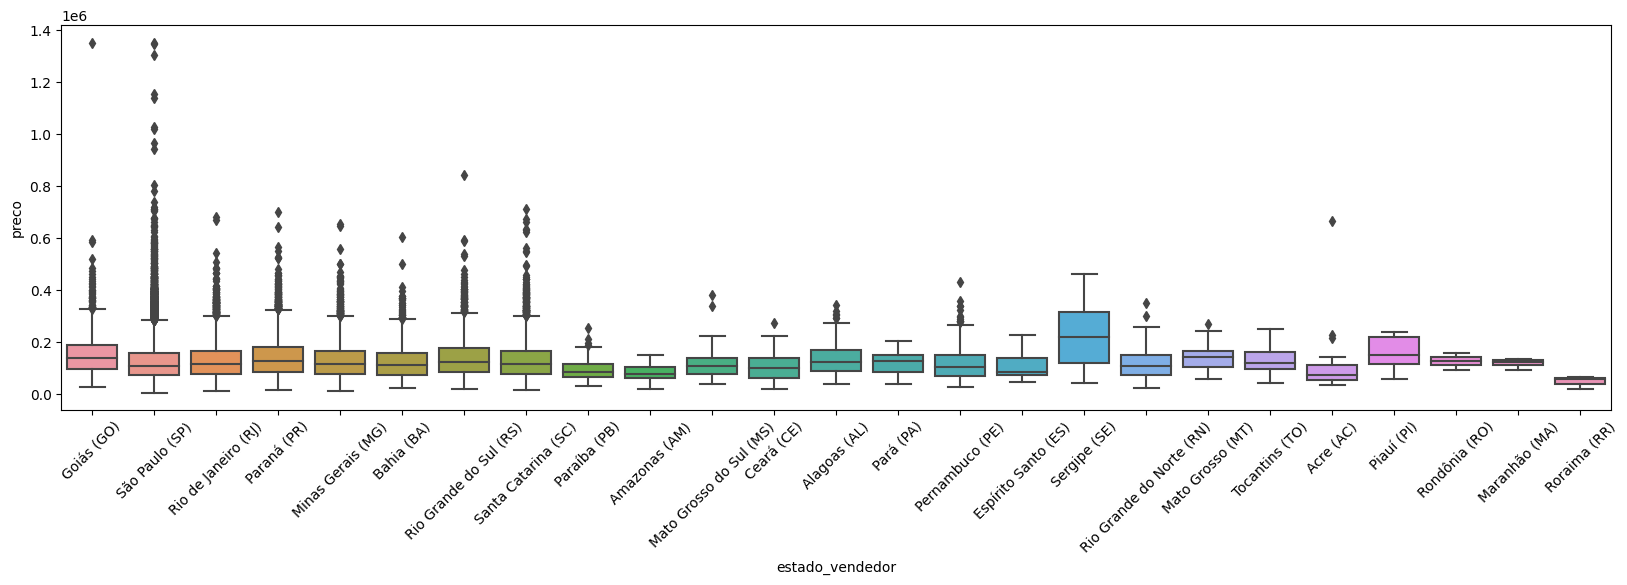

In [62]:
plt.figure(figsize=(20,5))
sns.boxplot(x='estado_vendedor' , y='preco' , data=df)
plt.xticks(rotation=45);

#### Entrega Delivey

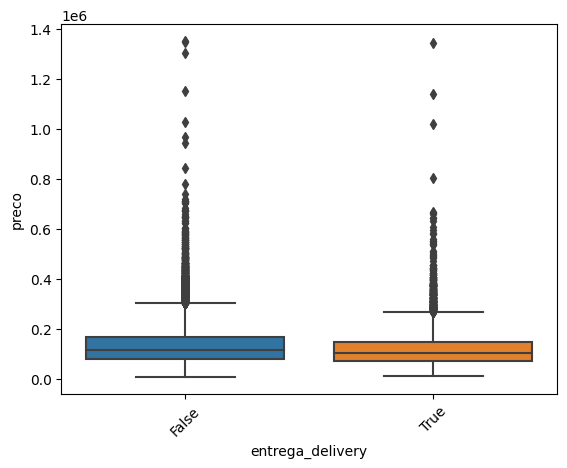

In [63]:
sns.boxplot(x='entrega_delivery' , y='preco' , data=df)
plt.xticks(rotation=45);

#### Troca

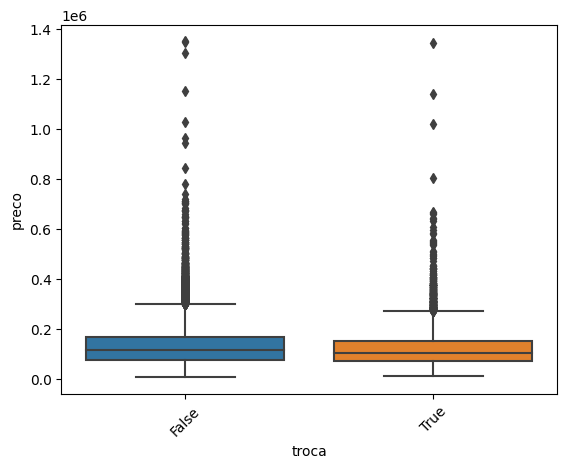

In [64]:
sns.boxplot(x='troca' , y='preco' , data=df)
plt.xticks(rotation=45);

#### Elegível Revisão

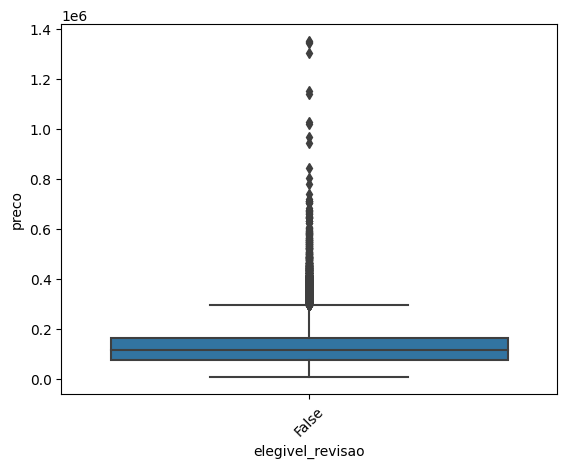

In [65]:
sns.boxplot(x='elegivel_revisao' , y='preco' , data=df)
plt.xticks(rotation=45);

# Feature Engineering

In [66]:
df4 = df.copy()

## Feature Creation

In [67]:
# extraindo as cilindradas da coluna versão
df4['cilindradas'] = df4['versao'].apply(lambda x: extract_power(re.search(r"\d+\.\d+",x)))

# extraindo válvulas da coluna versão
df4['valvulas'] = df4['versao'].apply(lambda x: extract_power(re.search(r"\d+V",x)))

# extraindo combustível da coluna versão
df4['combustivel'] = df4['versao'].apply(lambda x: 'GASOLINA' if 'GASOLINA' in x else 
                                                   'FLEX' if 'FLEX'     in x else 
                                                   'DIESEL' if 'DIESEL'   in x else 
                                                   'ÁLCOOL' if 'ÁLCOOL' in x else
                                                   'HÍBRIDO' if 'HYBRID' in x else
                                                   'HÍBRIDO' if 'HÍBRIDO' in x else 'sem informação')

# removendo features derivadas da coluna original
df4['versao'] = df4.apply(lambda x: x['versao'].replace(x['cilindradas'],'').replace(x['valvulas'], '').replace(x['combustivel'],'').replace(' AUTOMÁTICO', '').replace(' MANUAL', '').replace('  ',' '), axis=1)

# retirando acentos, substituindo letras maiúsculas e espaços
df4['cidade_vendedor'] = df4['cidade_vendedor'].apply(lambda x: unidecode(x).lower().replace(' ','_'))

# extraindo estado
df4['estado_vendedor'] = df4['estado_vendedor'].apply(lambda x: re.search(r'\((.*?)\)',x).group(1))

# criando feature de localidade
df4['localidade_vendedor'] = df4['cidade_vendedor'] + "_" + df4['estado_vendedor']

# criando feature de km médio rodado por ano
df4['km_media_ano_em_1k_km'] = df4['odometro']/np.round(2023 - df4['ano_modelo'] + 0.51,0)
# arredondando e escalando por 1000 km
df4['km_media_ano_em_1k_km'] = round(df4['km_media_ano_em_1k_km'] / 1000, 0).astype(int)

# criando feature de agregação do veículo com marca, modelo, km_media e localidade
df4['veiculo'] = df4['marca'].astype(str) + "_" + df4['modelo'].astype(str) #+ "_" + df4['km_media_ano_em_1k_km'].astype(str)

In [68]:
df4.sample(3)

marca   modelo                versao  ano_de_fabricacao  \
4482   VOLKSWAGEN     POLO      200 TSI HIGHLINE               2020   
3250   VOLKSWAGEN  T-CROSS        200 TSI TOTAL                2021   
12643  VOLKSWAGEN   VIRTUS   200 TSI COMFORTLINE               2019   

       ano_modelo  odometro      cambio  num_portas       tipo blindado  ...  \
4482       2021.0   17842.0  Automática           4  Hatchback        N  ...   
3250       2021.0    6682.0  Automática           4       Sedã        N  ...   
12643      2019.0   26419.0  Automática           4       Sedã        N  ...   

      entrega_delivery  troca elegivel_revisao          preco cilindradas  \
4482             False  False            False   95834.229244         1.0   
3250             False  False            False  122327.352414         1.0   
12643            False  False            False   68642.681199         1.0   

             valvulas     combustivel     localidade_vendedor  \
4482   sem informação  sem informação  presidente_prudente_SP   
3250   sem informação            FLEX              vitoria_SC   
12643  sem informação  sem informação         porto_alegre_RS   

       km_media_ano_em_1k_km             veiculo  
4482                       6     VOLKSWAGEN_POLO  
3250                       2  VOLKSWAGEN_T-CROSS  
12643                      5   VOLKSWAGEN_VIRTUS  

[3 rows x 25 columns]

# Exploratory Data Analysis

Objetivos:
1. Ganhar experiência de Negócio
2. Validar Hióteses de Negócios
3. Perceber variáveis que são importantes para o modelo
    - Não podemos confiar 100% na seleção de features

In [69]:
df5 = df4.copy()

## Univariate Analysis

### Response Variable

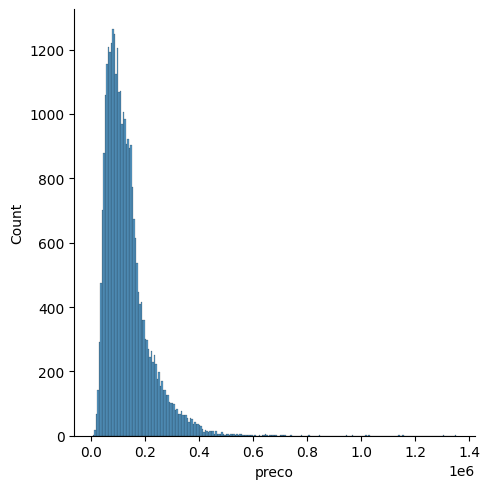

In [70]:
sns.displot(df5['preco'])

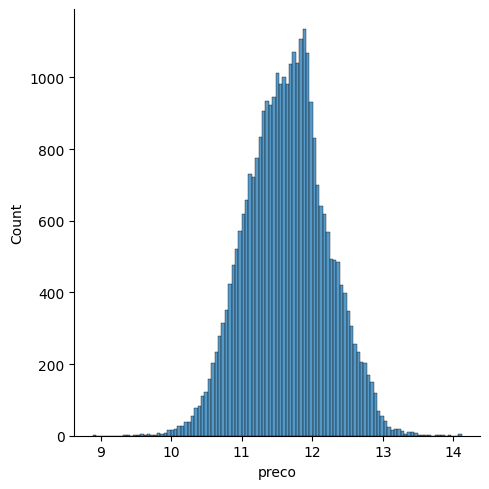

In [71]:
sns.displot(np.log1p(df5['preco']));

### Numerical Variable

**Scalers sugeridos:**

| Atributo               | Rescaling  |
| ---------------------- | ------------- |
|**Ano de Fabricação:** | Robust Scaler |
|**Ano do Modelo:** | Robust Scaler|
|**Odometro:** | Robust Scaler|
|**Número de Portas:** | Ordinal Encode|

In [72]:
num_attributes = df5.select_dtypes(include=['int64','float64'])
cat_attributes = df5.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

#### Ano de Fabricação

- Não possui distribuição normal e possui muitos outliers
- Rescaling: **ROBUST SCALER**

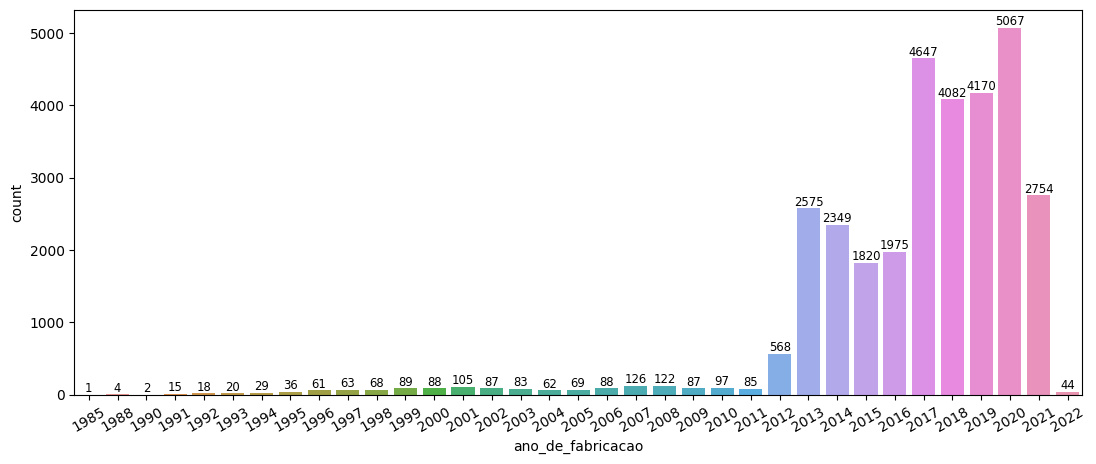

In [73]:
plt.figure(figsize=(13,5))
g = sns.countplot(x='ano_de_fabricacao', data=df5)
for i in g.containers:
    g.bar_label(i, color='black', label_type= 'edge',fontsize='small',fmt='%.0f')
plt.xticks(rotation=30);

#### Ano do modelo

- Não possui distribuição normal e possui outliers
- Rescaling: **ROBUST SCALER**

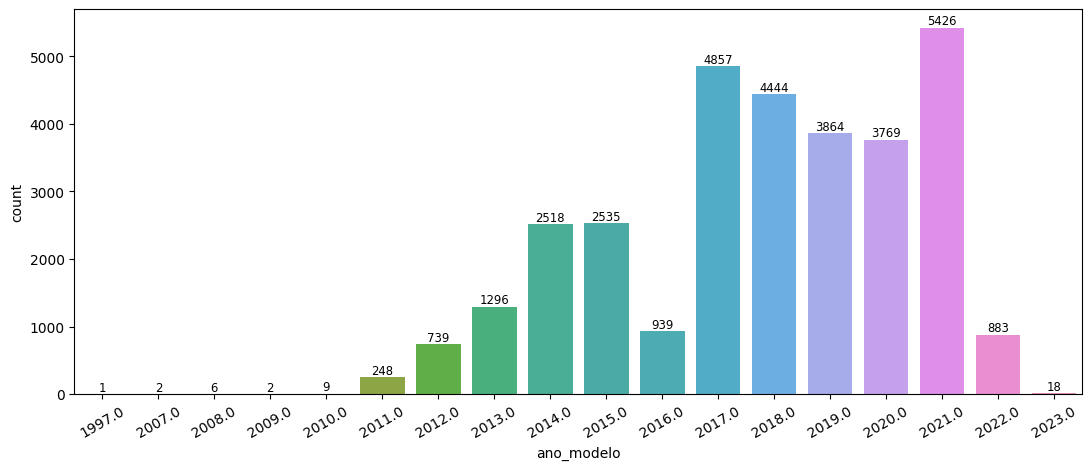

In [74]:
plt.figure(figsize=(13,5))
g = sns.countplot(x='ano_modelo', data=df5)
for i in g.containers:
    g.bar_label(i, color='black', label_type= 'edge',fontsize='small',fmt='%.0f')
plt.xticks(rotation=30);

#### Odometro

- Não possui distribuição normal e possui outliers
- Rescaling: **ROBUST SCALER**

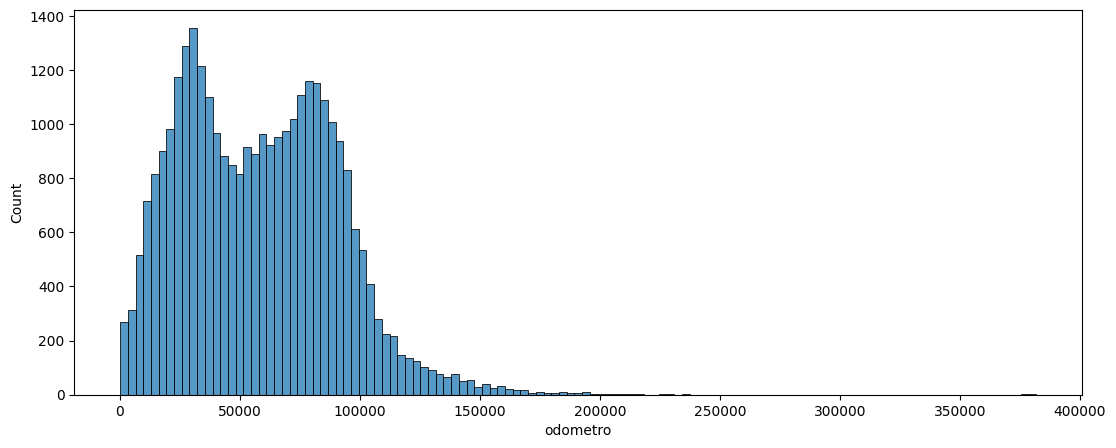

In [75]:
plt.figure(figsize=(13,5))
g = sns.histplot(x='odometro', data=df5)

#### Número de Portas

- Variável numérica com poucos labels
- Transformar em variável categórica e utilizar o **ORDINAL ENCONDING**

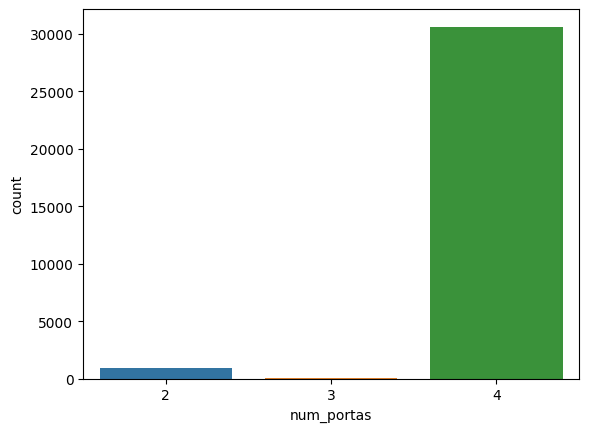

In [76]:
sns.countplot(x='num_portas', data=df5);

### Categorical Variables

####  Marca

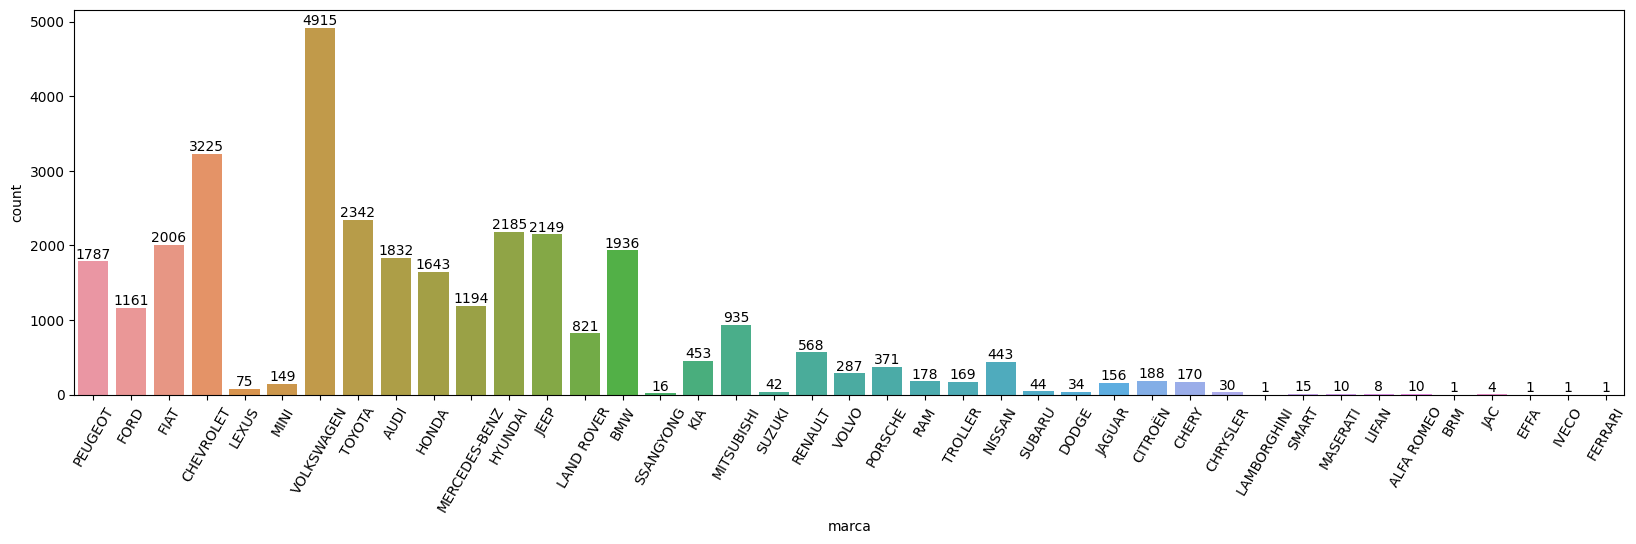

In [77]:
plt.figure(figsize=(20,5))
g = sns.countplot(x = 'marca', data=df5);
for i in g.containers:
    g.bar_label(i, color='black', label_type= 'edge',fontsize='medium',fmt='%.0f')
plt.xticks(rotation=60);

#### Cambio

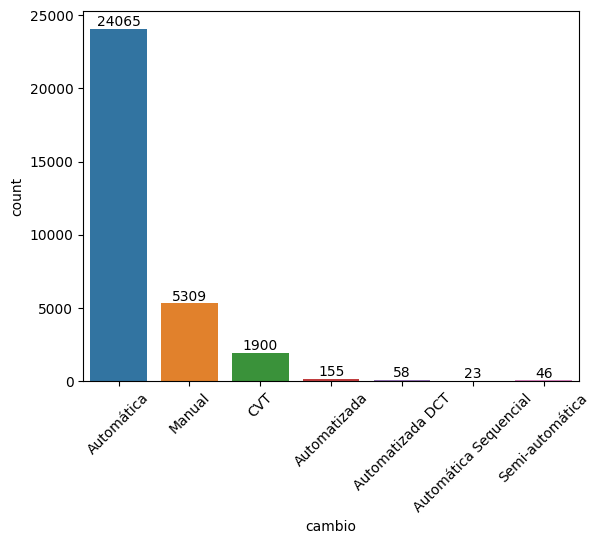

In [78]:
g = sns.countplot(x = 'cambio', data=df5);
for i in g.containers:
    g.bar_label(i, color='black', label_type= 'edge',fontsize='medium',fmt='%.0f')
plt.xticks(rotation=45);

#### Tipo

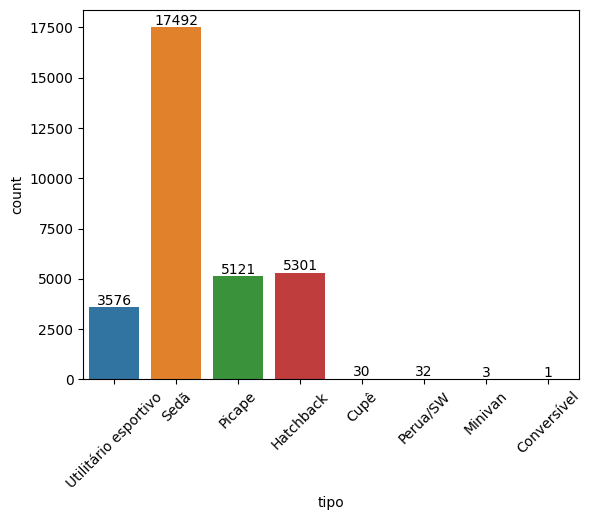

In [79]:
g = sns.countplot(x = 'tipo', data=df5);
for i in g.containers:
    g.bar_label(i, color='black', label_type= 'edge',fontsize='medium',fmt='%.0f')
plt.xticks(rotation=45);

#### Blindado

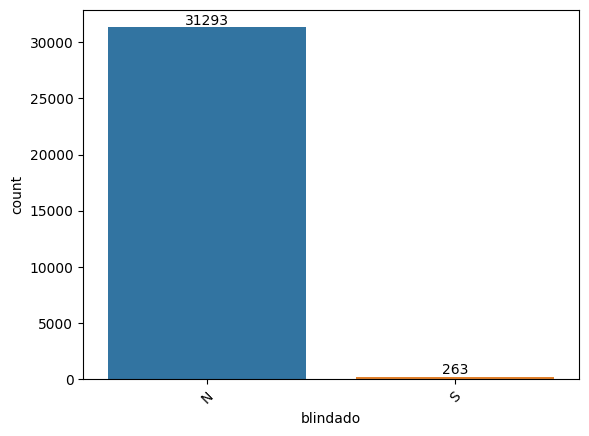

In [80]:
g = sns.countplot(x = 'blindado', data=df5);
for i in g.containers:
    g.bar_label(i, color='black', label_type= 'edge',fontsize='medium',fmt='%.0f')
plt.xticks(rotation=45);

#### Cor

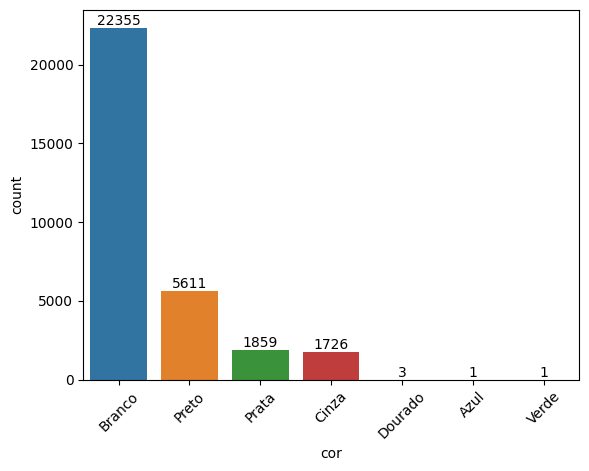

In [81]:
g = sns.countplot(x = 'cor', data=df5);
for i in g.containers:
    g.bar_label(i, color='black', label_type= 'edge',fontsize='medium',fmt='%.0f')
plt.xticks(rotation=45);

#### Tipo Vendedor

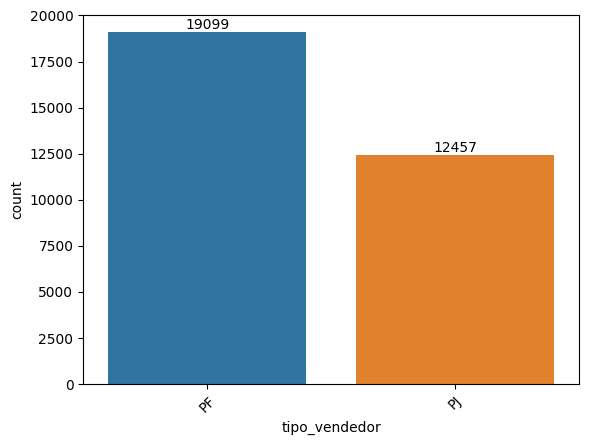

In [82]:
g = sns.countplot(x = 'tipo_vendedor', data=df5);
for i in g.containers:
    g.bar_label(i, color='black', label_type= 'edge',fontsize='medium',fmt='%.0f')
plt.xticks(rotation=45);

#### Entrega Delivery

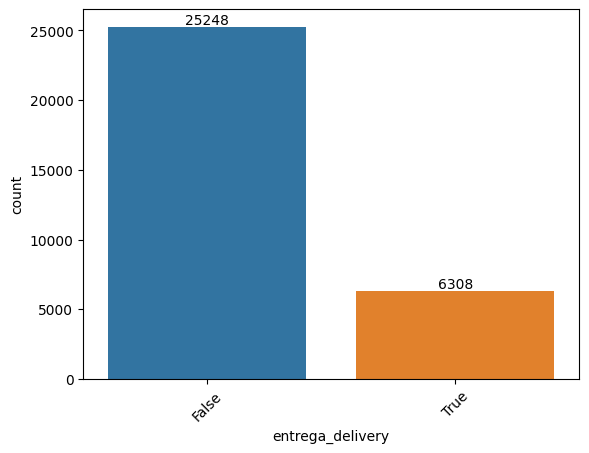

In [83]:
g = sns.countplot(x = 'entrega_delivery', data=df5);
for i in g.containers:
    g.bar_label(i, color='black', label_type= 'edge',fontsize='medium',fmt='%.0f')
plt.xticks(rotation=45);

#### Troca

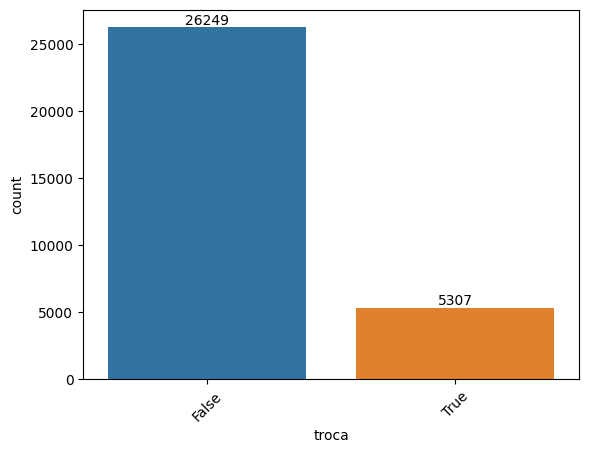

In [84]:
g = sns.countplot(x = 'troca', data=df5);
for i in g.containers:
    g.bar_label(i, color='black', label_type= 'edge',fontsize='medium',fmt='%.0f')
plt.xticks(rotation=45);

#### Elegível Revisão

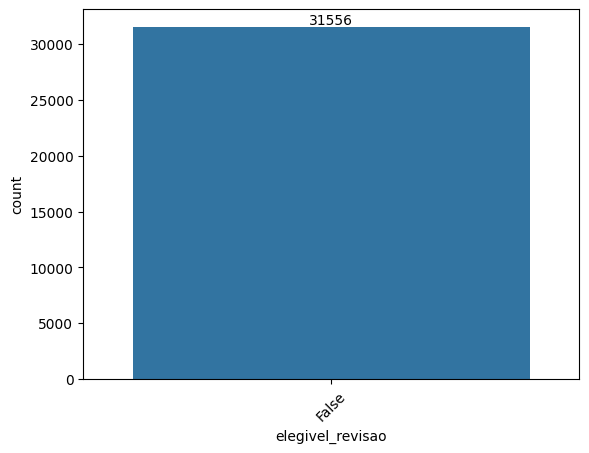

In [85]:
g = sns.countplot(x = 'elegivel_revisao', data=df5);
for i in g.containers:
    g.bar_label(i, color='black', label_type= 'edge',fontsize='medium',fmt='%.0f')
plt.xticks(rotation=45);

## Bivariate Analysis

**Encodes sugeridos**

| Atributo                | Encode          |
| ----------------------- | --------------- |
| **Marca:**              | Frequency Encode| 
| **Modelo:**             | Frequency Encode| 
| **Versão:**             | Frequency Encode| 
| **Câmbio:**             | Ordinal Enconde| 
| **Tipo:**               | Target Encode| 
| **Blindado:**           | One Hot Encode| 
| **Cor:**                | Target Encode| 
| **Tipo de Vendedor:**   | One Hot Encode| 
| **Cidade do Vendedor:** | Target Encode| 
| **Tipo de Anúncio:**    | One Hot Encode| 
| **Entrega Delivery:**   | One Hot Encode| 
| **Cilindradas:**        | Frequency Encode| 
| **Válvulas:**           | Target Encode| 
| **Combustível:**        | Target Encode| 


In [86]:
for col in cat_attributes.columns.tolist():
    print( f'{col}: {cat_attributes[col].unique().shape[0]}')

marca: 41
modelo: 466
versao: 1631
cambio: 7
tipo: 8
blindado: 2
cor: 7
tipo_vendedor: 2
cidade_vendedor: 593
estado_vendedor: 25
tipo_anuncio: 4
entrega_delivery: 2
troca: 2
elegivel_revisao: 1
cilindradas: 47
valvulas: 12
combustivel: 6
localidade_vendedor: 1016
km_media_ano_em_1k_km: 39
veiculo: 466


#### Marca

- Variável com muitos labels
- Entende-se que pode ser influenciada pela oferta e demanda, quanto mais carros vendidos de determinada marca, menor o preço
- Enconding: **Frequency Encoding**

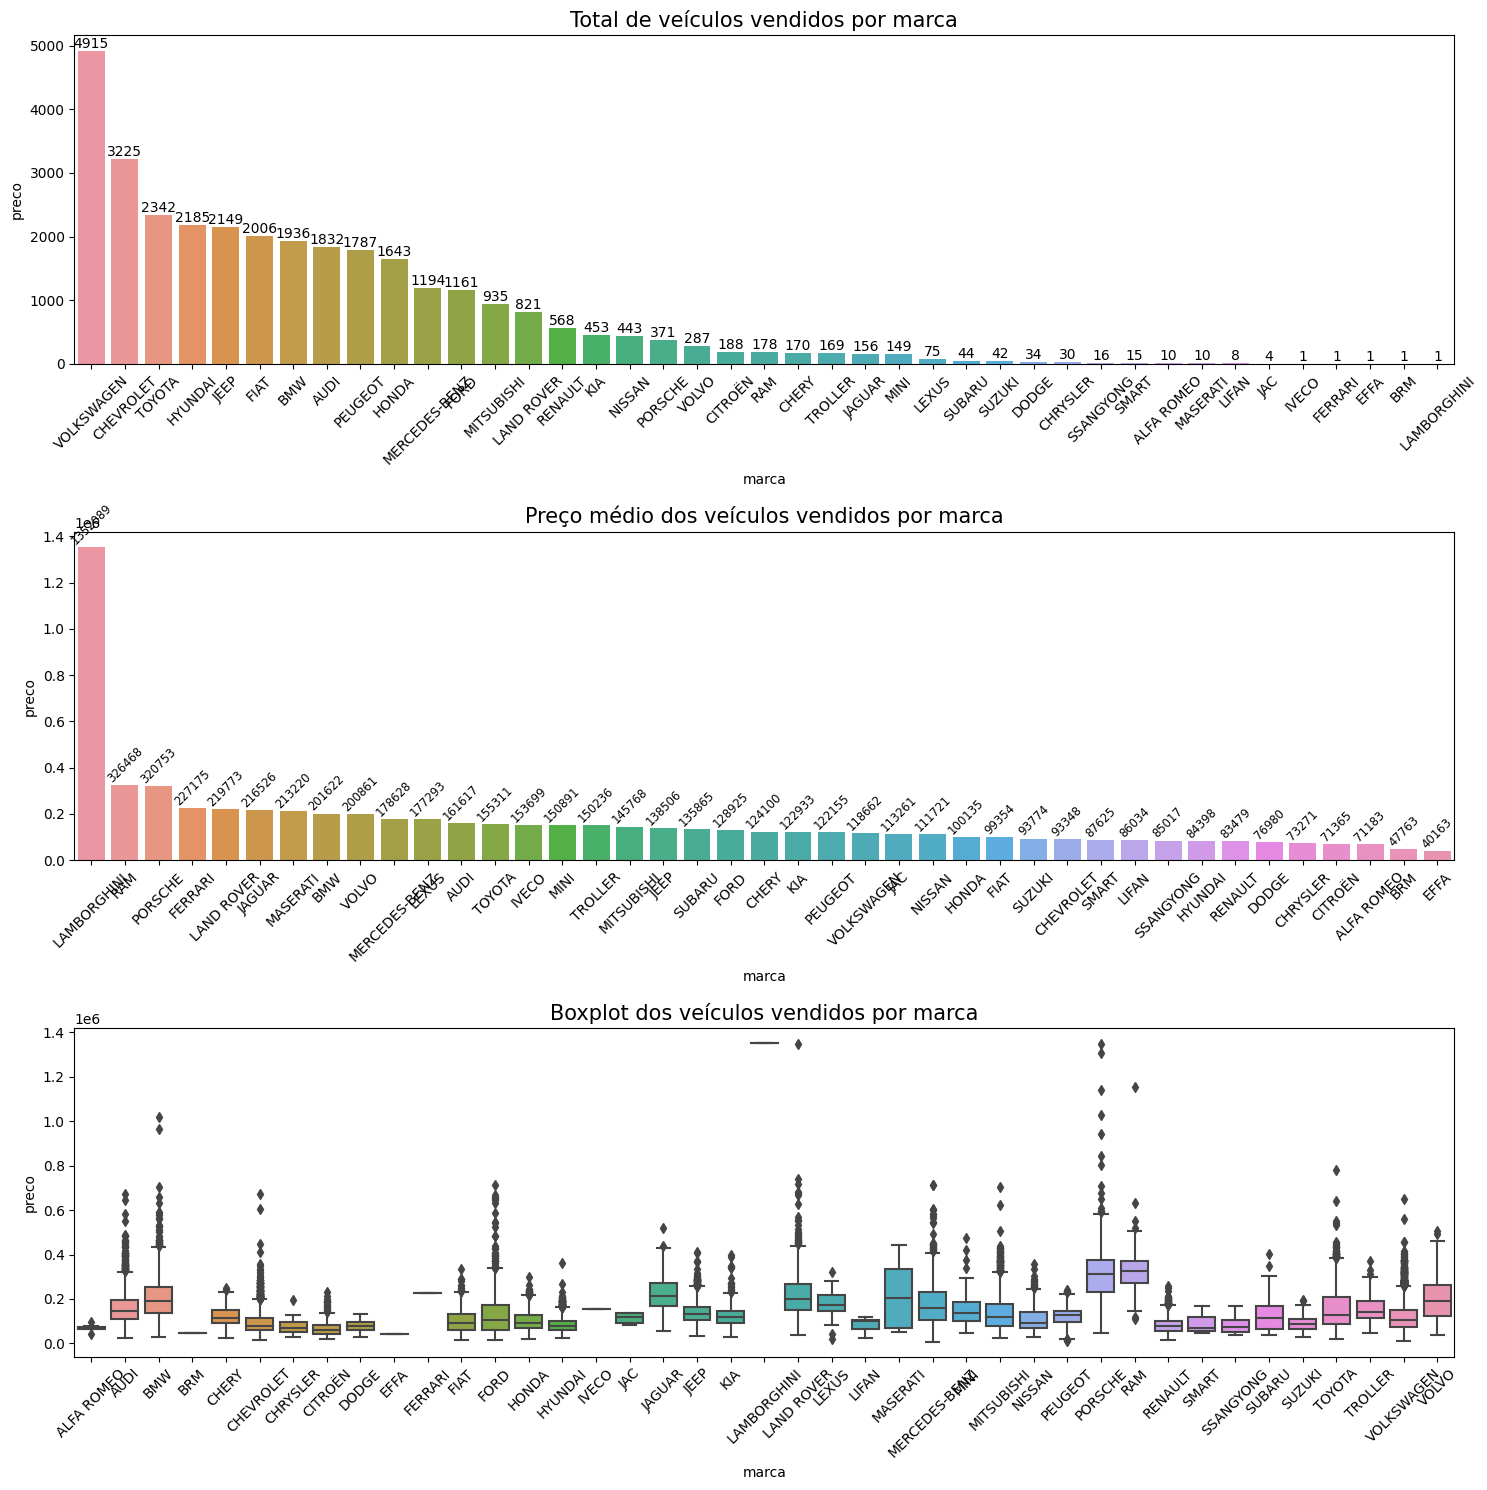

In [87]:
plt.figure(figsize=(15,15))
grid = gridspec.GridSpec(3,1)

plt.subplot(grid[0,0])
plt.title('Total de veículos vendidos por marca', fontsize=15)
aux = df5[['marca','preco']].groupby('marca').count().reset_index().sort_values(by='preco', ascending=False)
g = sns.barplot(x='marca', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f')
plt.xticks(rotation=45);

plt.subplot(grid[1,0])
plt.title('Preço médio dos veículos vendidos por marca', fontsize=15)
aux = df5[['marca','preco']].groupby('marca').mean().reset_index().sort_values(by='preco', ascending=False)
g = sns.barplot(x='marca', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f',fontsize='small',rotation=45)
plt.xticks(rotation=45);

plt.subplot(grid[2,0])
plt.title('Boxplot dos veículos vendidos por marca', fontsize=15)
aux = df5.sort_values(by='marca')
sns.boxplot(x='marca', y = 'preco', data=aux)
plt.xticks(rotation=45);

plt.tight_layout()

#### Modelo

- Variável com várias labels
- Encoding: **Frequency Encoding**

In [88]:
print('Total de modelo diferentes: {}'.format(df5['modelo'].unique().shape[0]))

Total de modelo diferentes: 466


#### Versão

- Variável com várias labels
- Encoding: **Frequency Encode**

In [89]:
print('Total de versões diferentes: {}'.format(df5['versao'].unique().shape[0]))

Total de versões diferentes: 1631


#### Ano do Modelo

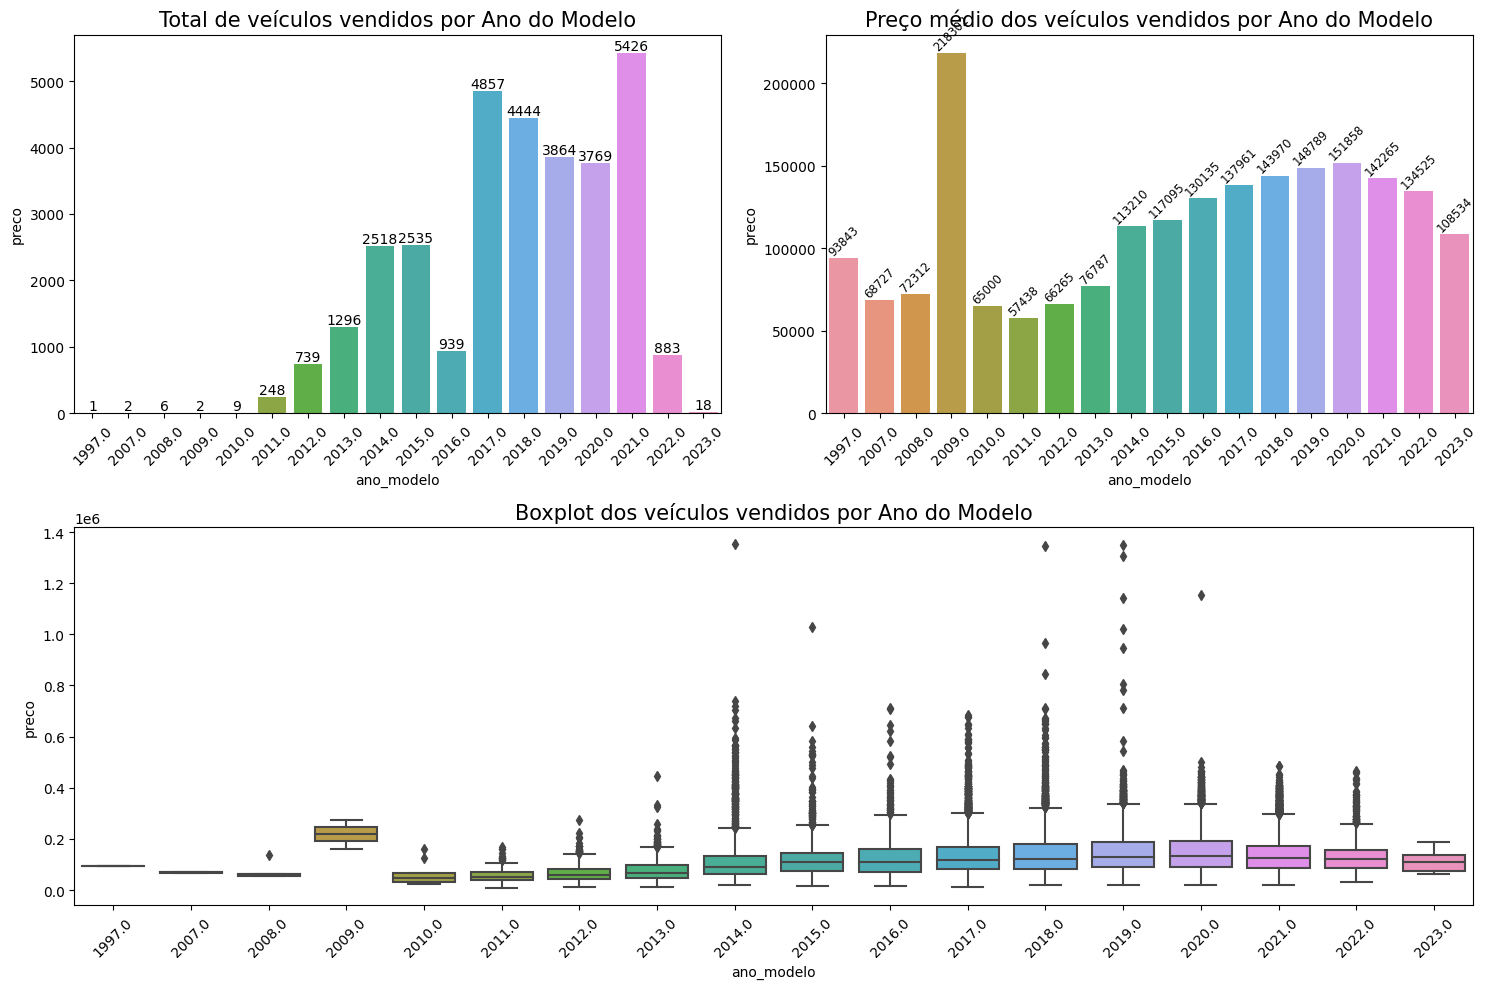

In [90]:
plt.figure(figsize=(15,10))
grid = gridspec.GridSpec(2,2)

plt.subplot(grid[0,0])
plt.title('Total de veículos vendidos por Ano do Modelo', fontsize=15)
aux = df5[['ano_modelo','preco']].groupby('ano_modelo').count().reset_index().sort_values(by='ano_modelo')
g = sns.barplot(x='ano_modelo', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f')
plt.xticks(rotation=45);

plt.subplot(grid[0,1])
plt.title('Preço médio dos veículos vendidos por Ano do Modelo', fontsize=15)
aux = df5[['ano_modelo','preco']].groupby('ano_modelo').mean().reset_index().sort_values(by='ano_modelo')
g = sns.barplot(x='ano_modelo', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f',fontsize='small',rotation=45)
plt.xticks(rotation=45);

plt.subplot(grid[1,:])
plt.title('Boxplot dos veículos vendidos por Ano do Modelo', fontsize=15)
aux = df5.sort_values(by='ano_modelo')
sns.boxplot(x='ano_modelo', y = 'preco', data=aux)
plt.xticks(rotation=45);

plt.tight_layout()

#### Ano de Fabricação

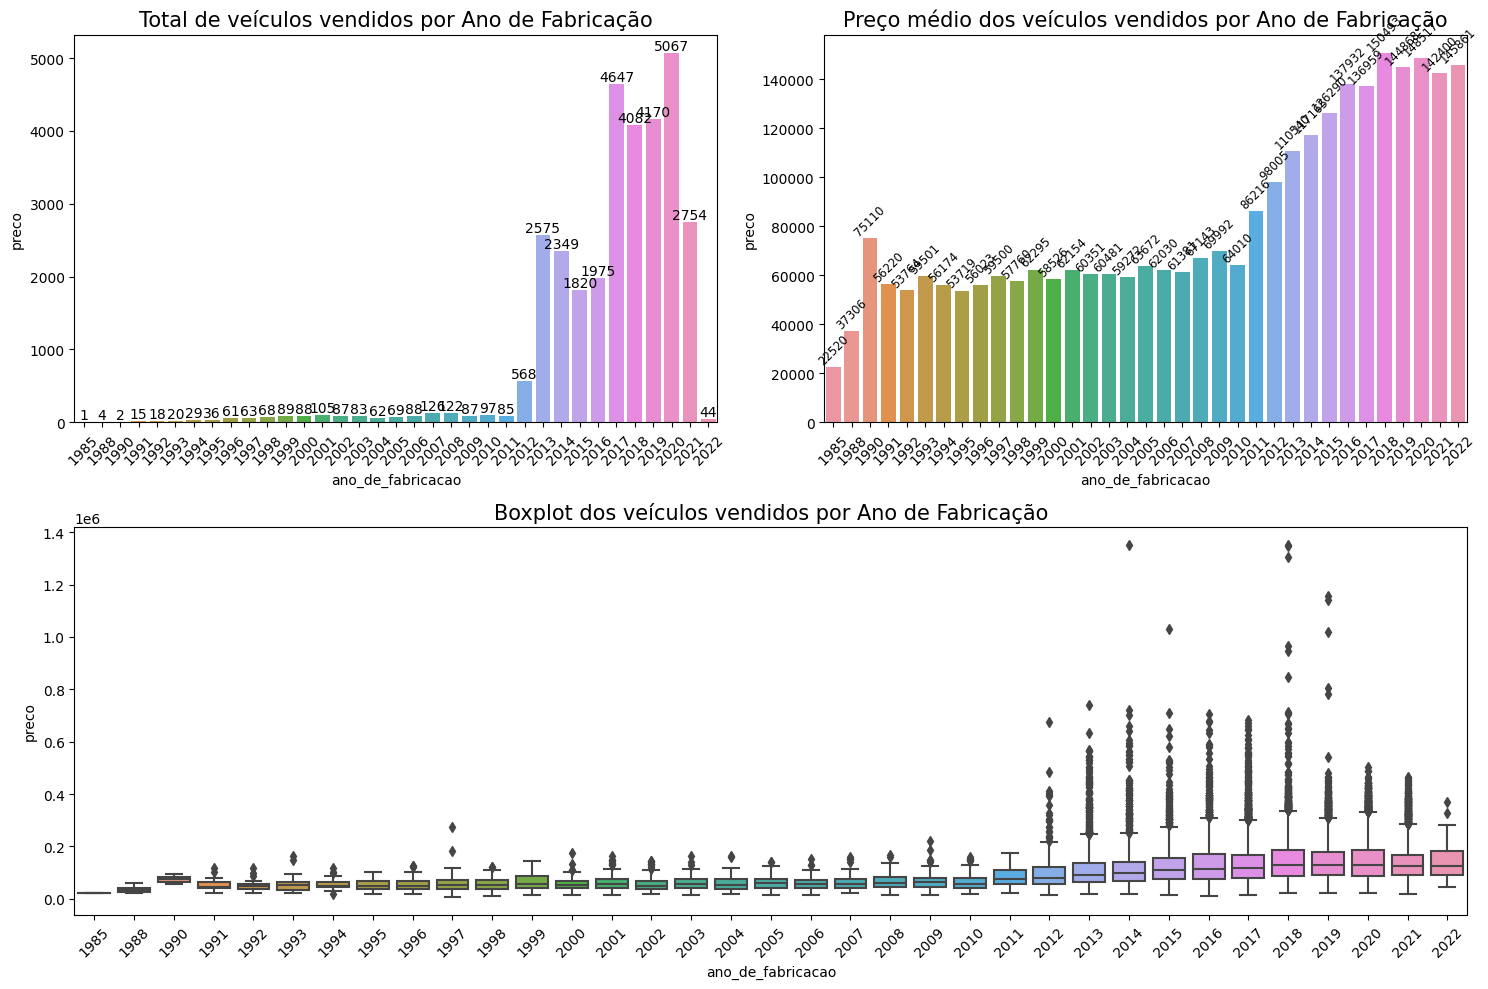

In [91]:
plt.figure(figsize=(15,10))
grid = gridspec.GridSpec(2,2)

plt.subplot(grid[0,0])
plt.title('Total de veículos vendidos por Ano de Fabricação', fontsize=15)
aux = df5[['ano_de_fabricacao','preco']].groupby('ano_de_fabricacao').count().reset_index().sort_values(by='ano_de_fabricacao')
g = sns.barplot(x='ano_de_fabricacao', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f')
plt.xticks(rotation=45);

plt.subplot(grid[0,1])
plt.title('Preço médio dos veículos vendidos por Ano de Fabricação', fontsize=15)
aux = df5[['ano_de_fabricacao','preco']].groupby('ano_de_fabricacao').mean().reset_index().sort_values(by='ano_de_fabricacao')
g = sns.barplot(x='ano_de_fabricacao', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f',fontsize='small',rotation=45)
plt.xticks(rotation=45);

plt.subplot(grid[1,:])
plt.title('Boxplot dos veículos vendidos por Ano de Fabricação', fontsize=15)
aux = df5.sort_values(by='ano_de_fabricacao')
sns.boxplot(x='ano_de_fabricacao', y = 'preco', data=aux)
plt.xticks(rotation=45);

plt.tight_layout()

#### Odometro

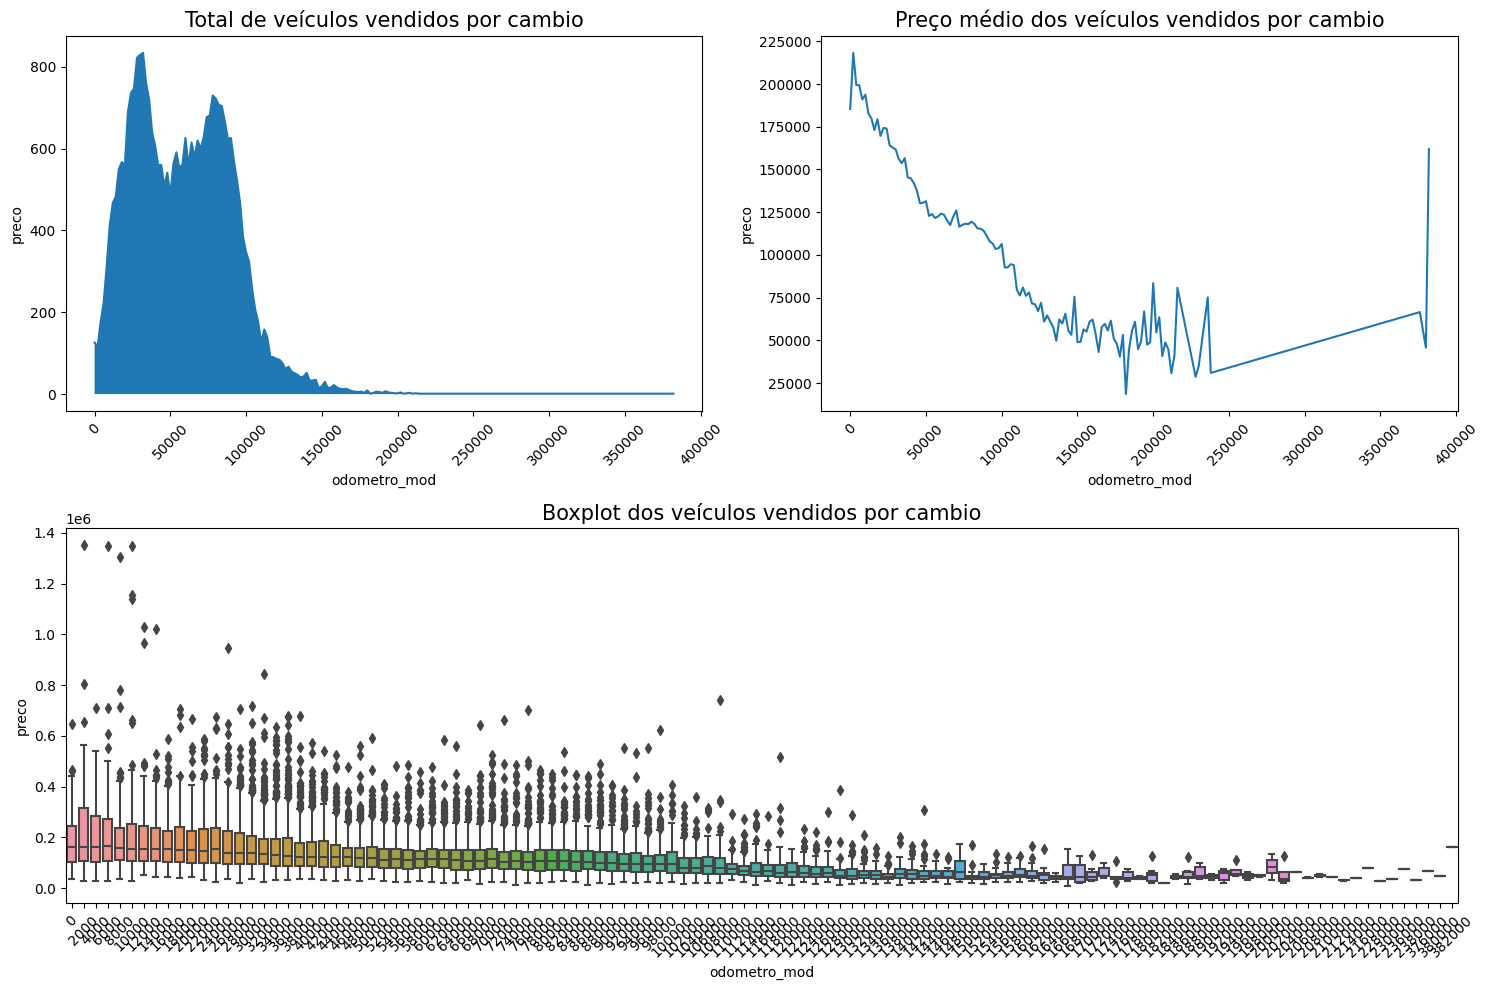

In [92]:
plt.figure(figsize=(15,10))
grid = gridspec.GridSpec(2,2)

plt.subplot(grid[0,0])
plt.title('Total de veículos vendidos por cambio', fontsize=15)
aux_ref = df5[['odometro','preco']]
aux_ref['odometro_mod'] = aux_ref['odometro'].apply(lambda x: round(x/2000,0)*2000).astype('int64')
aux = aux_ref[['odometro_mod','preco']].groupby('odometro_mod').count().reset_index().sort_values(by='odometro_mod')
g = sns.lineplot(x='odometro_mod', y = 'preco', data=aux)
plt.fill_between(aux.odometro_mod.values, aux.preco.values)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f')
plt.xticks(rotation=45);

plt.subplot(grid[0,1])
plt.title('Preço médio dos veículos vendidos por cambio', fontsize=15)
aux = aux_ref[['odometro_mod','preco']].groupby('odometro_mod').mean().reset_index().sort_values(by='odometro_mod')
g = sns.lineplot(x='odometro_mod', y = 'preco', data=aux)
# plt.fill_between(aux.odometro_mod.values, aux.preco.values)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f',fontsize='small',rotation=45)
plt.xticks(rotation=45);

plt.subplot(grid[1,:])
plt.title('Boxplot dos veículos vendidos por cambio', fontsize=15)
aux = aux_ref.sort_values(by='odometro_mod')
sns.boxplot(x='odometro_mod', y = 'preco', data=aux)
plt.xticks(rotation=45);

plt.tight_layout()

#### Cambio

- Cambios com complexidades distintas
- Rescaling: **Ordinal Enconding** pela mediana dos preços uma vez que traduz a complexidade do cambio

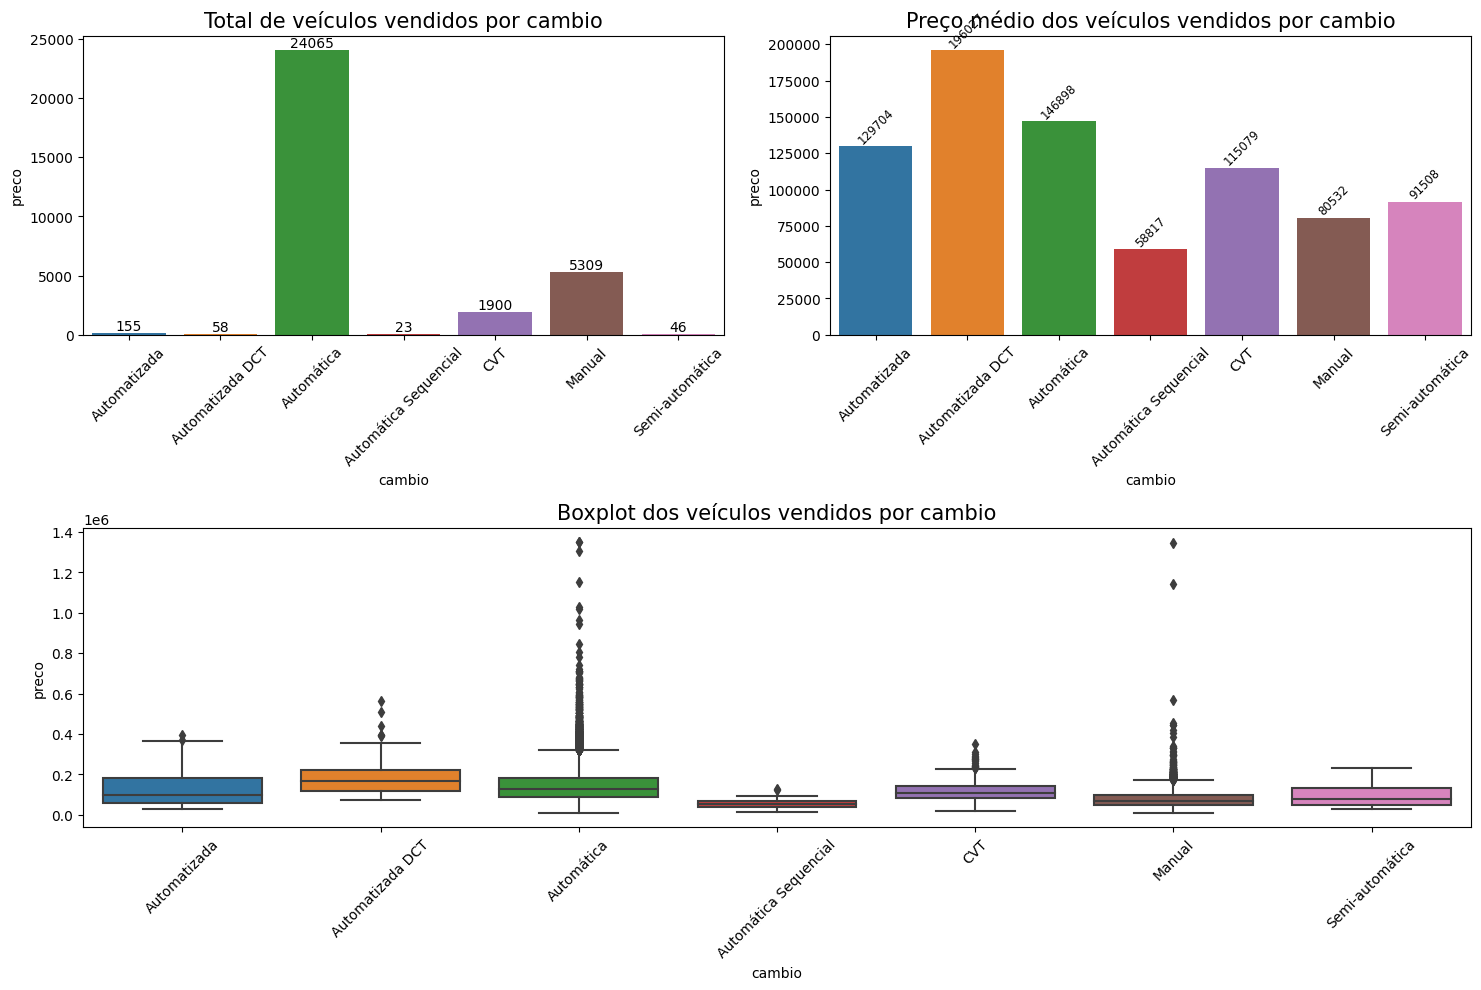

In [93]:
plt.figure(figsize=(15,10))
grid = gridspec.GridSpec(2,2)

plt.subplot(grid[0,0])
plt.title('Total de veículos vendidos por cambio', fontsize=15)
aux = df5[['cambio','preco']].groupby('cambio').count().reset_index().sort_values(by='cambio')
g = sns.barplot(x='cambio', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f')
plt.xticks(rotation=45);

plt.subplot(grid[0,1])
plt.title('Preço médio dos veículos vendidos por cambio', fontsize=15)
aux = df5[['cambio','preco']].groupby('cambio').mean().reset_index().sort_values(by='cambio')
g = sns.barplot(x='cambio', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f',fontsize='small',rotation=45)
plt.xticks(rotation=45);

plt.subplot(grid[1,:])
plt.title('Boxplot dos veículos vendidos por cambio', fontsize=15)
aux = df5.sort_values(by='cambio')
sns.boxplot(x='cambio', y = 'preco', data=aux)
plt.xticks(rotation=45);

plt.tight_layout()

#### Tipo

- Média de preços bem definida entre os tipos
- Encoding: **Tareget Encoding**

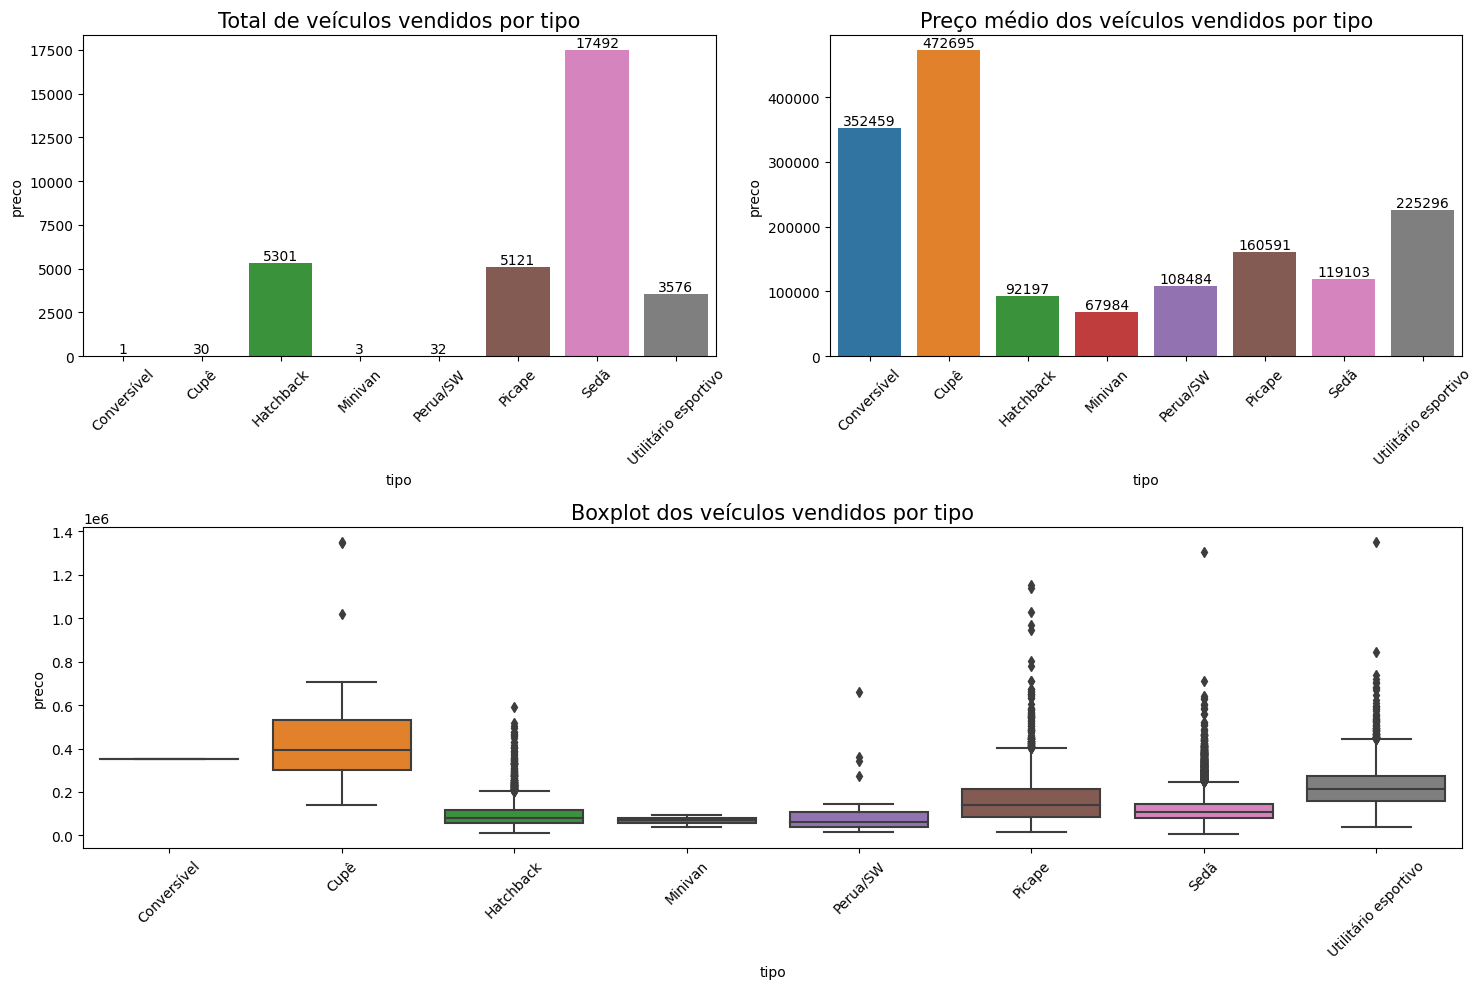

In [94]:
plt.figure(figsize=(15,10))
grid = gridspec.GridSpec(2,2)

plt.subplot(grid[0,0])
plt.title('Total de veículos vendidos por tipo', fontsize=15)
aux = df5[['tipo','preco']].groupby('tipo').count().reset_index().sort_values(by='tipo')
g = sns.barplot(x='tipo', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f')
plt.xticks(rotation=45);

plt.subplot(grid[0,1])
plt.title('Preço médio dos veículos vendidos por tipo', fontsize=15)
aux = df5[['tipo','preco']].groupby('tipo').mean().reset_index().sort_values(by='tipo')
g = sns.barplot(x='tipo', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f',rotation=0)
plt.xticks(rotation=45);

plt.subplot(grid[1,:])
plt.title('Boxplot dos veículos vendidos por tipo', fontsize=15)
aux = df5.sort_values(by='tipo')
sns.boxplot(x='tipo', y = 'preco', data=aux)
plt.xticks(rotation=45);

plt.tight_layout()

#### Blindado

- Possui apenas duas labels e traduz uma ideia de estado
- Encoding: **One Hot Encoding**

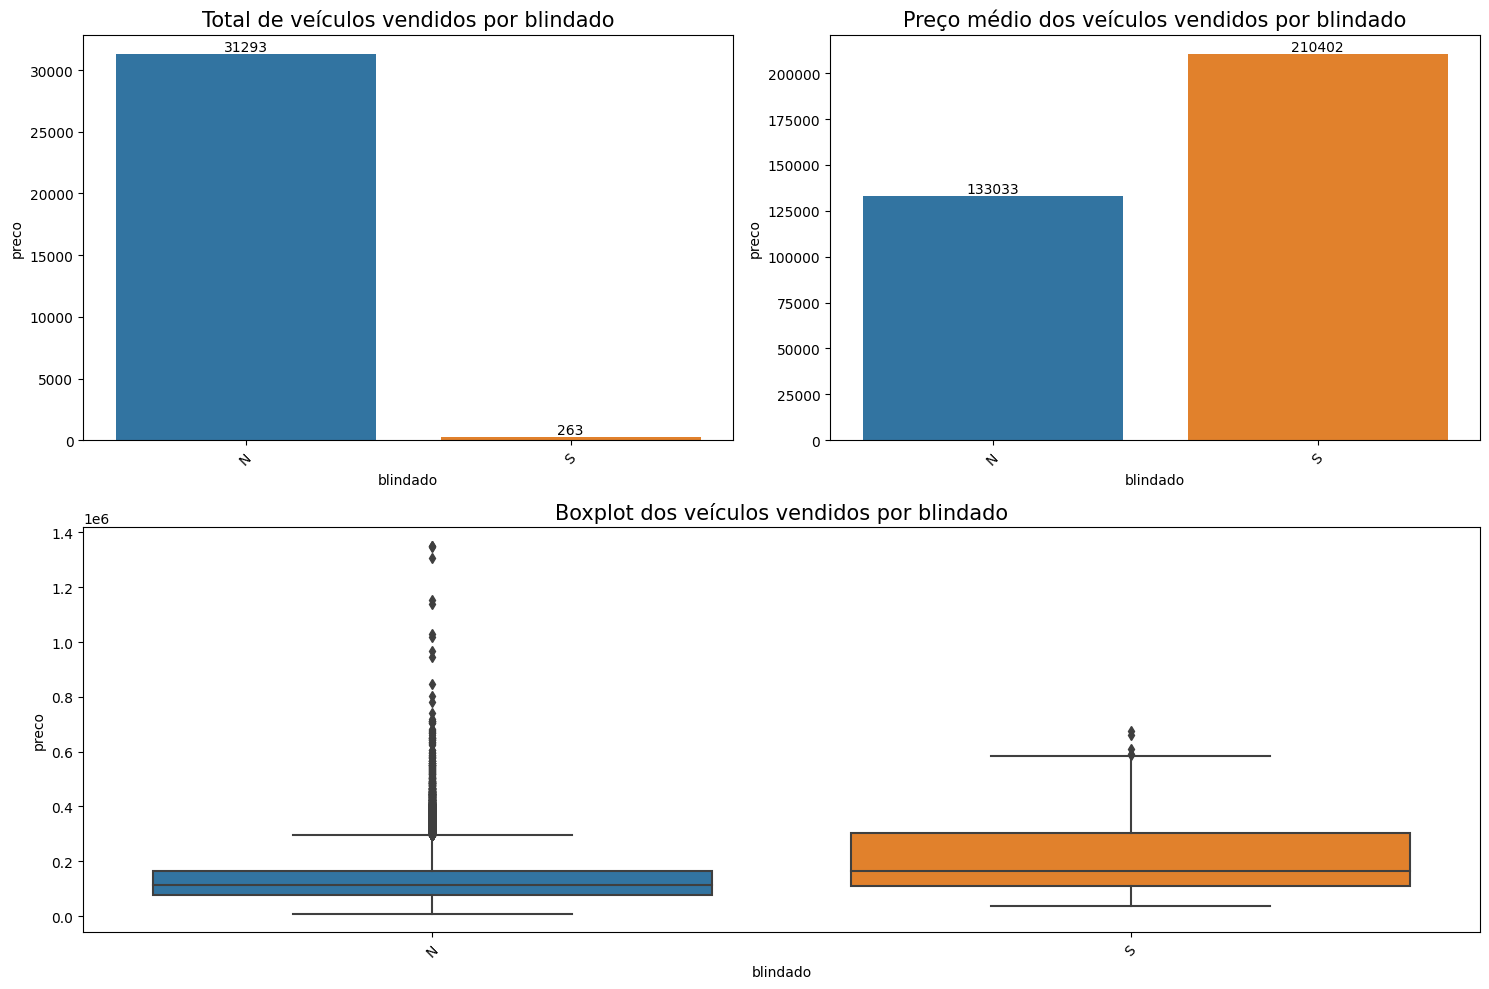

In [95]:
plt.figure(figsize=(15,10))
grid = gridspec.GridSpec(2,2)

plt.subplot(grid[0,0])
plt.title('Total de veículos vendidos por blindado', fontsize=15)
aux = df5[['blindado','preco']].groupby('blindado').count().reset_index().sort_values(by='blindado')
g = sns.barplot(x='blindado', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f')
plt.xticks(rotation=45);

plt.subplot(grid[0,1])
plt.title('Preço médio dos veículos vendidos por blindado', fontsize=15)
aux = df5[['blindado','preco']].groupby('blindado').mean().reset_index().sort_values(by='blindado')
g = sns.barplot(x='blindado', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f',rotation=0)
plt.xticks(rotation=45);

plt.subplot(grid[1,:])
plt.title('Boxplot dos veículos vendidos por blindado', fontsize=15)
aux = df5.sort_values(by='blindado')
sns.boxplot(x='blindado', y = 'preco', data=aux)
plt.xticks(rotation=45);

plt.tight_layout()

#### Cor

- Variável com muitas labels
- Encoding: **Target Encoding**

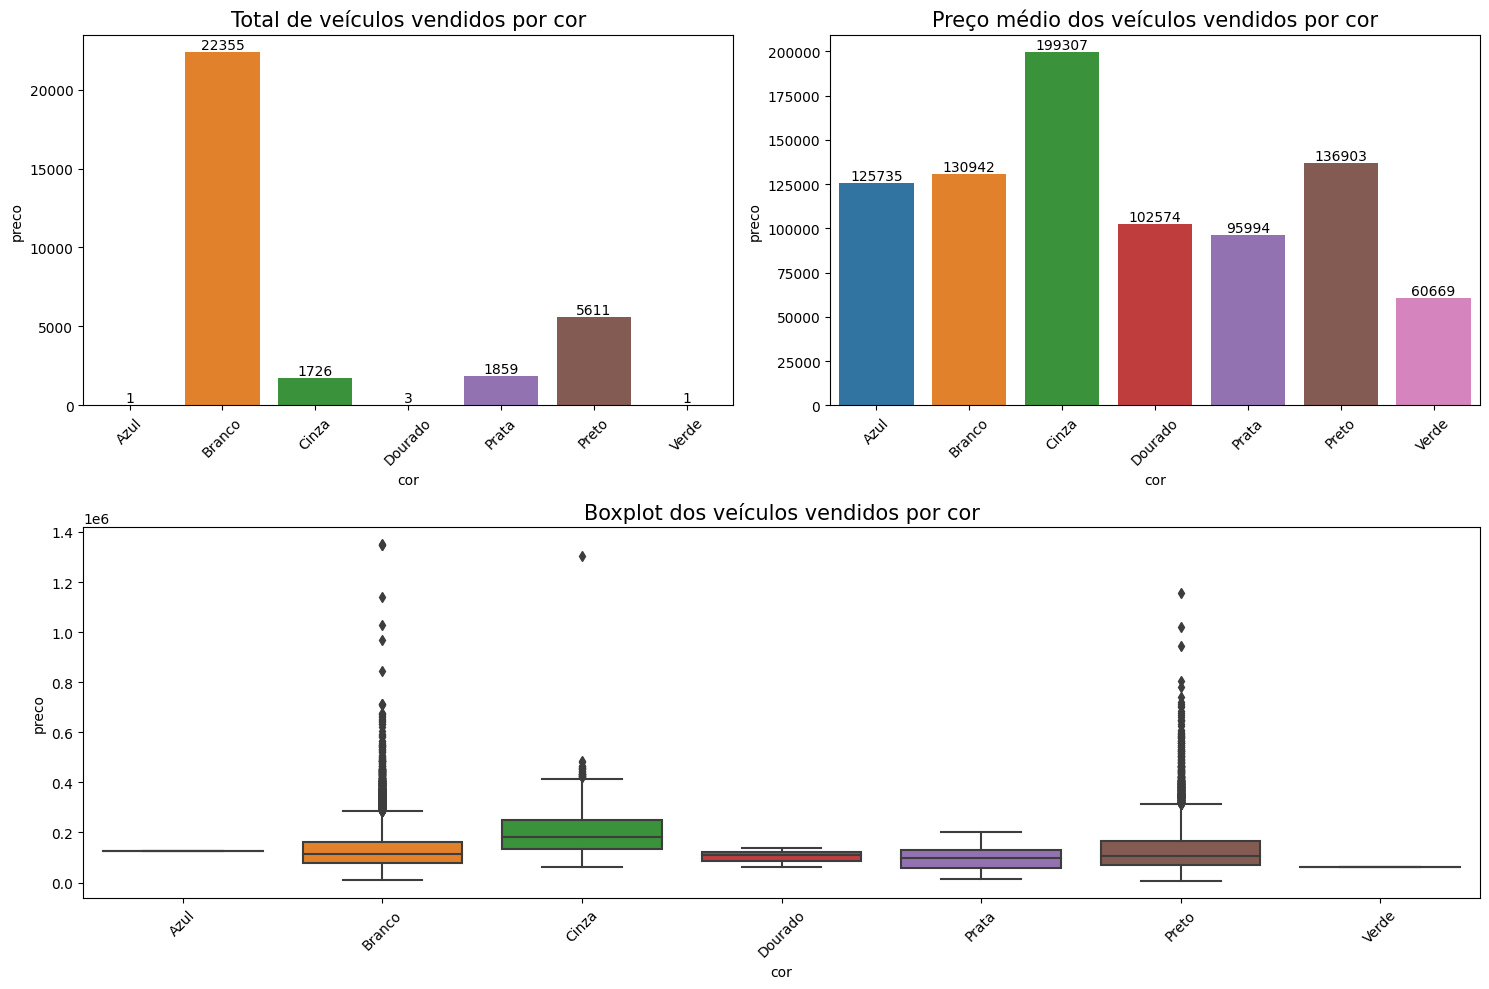

In [96]:
plt.figure(figsize=(15,10))
grid = gridspec.GridSpec(2,2)

plt.subplot(grid[0,0])
plt.title('Total de veículos vendidos por cor', fontsize=15)
aux = df5[['cor','preco']].groupby('cor').count().reset_index().sort_values(by='cor')
g = sns.barplot(x='cor', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f')
plt.xticks(rotation=45);

plt.subplot(grid[0,1])
plt.title('Preço médio dos veículos vendidos por cor', fontsize=15)
aux = df5[['cor','preco']].groupby('cor').mean().reset_index().sort_values(by='cor')
g = sns.barplot(x='cor', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f',rotation=0)
plt.xticks(rotation=45);

plt.subplot(grid[1,:])
plt.title('Boxplot dos veículos vendidos por cor', fontsize=15)
aux = df5.sort_values(by='cor')
sns.boxplot(x='cor', y = 'preco', data=aux)
plt.xticks(rotation=45);

plt.tight_layout()

#### Tipo de Vendedor

- Variável com poucas labels. Representa uma ideia de estado (S ou N)
- Encoding: **One Hot Encoding**

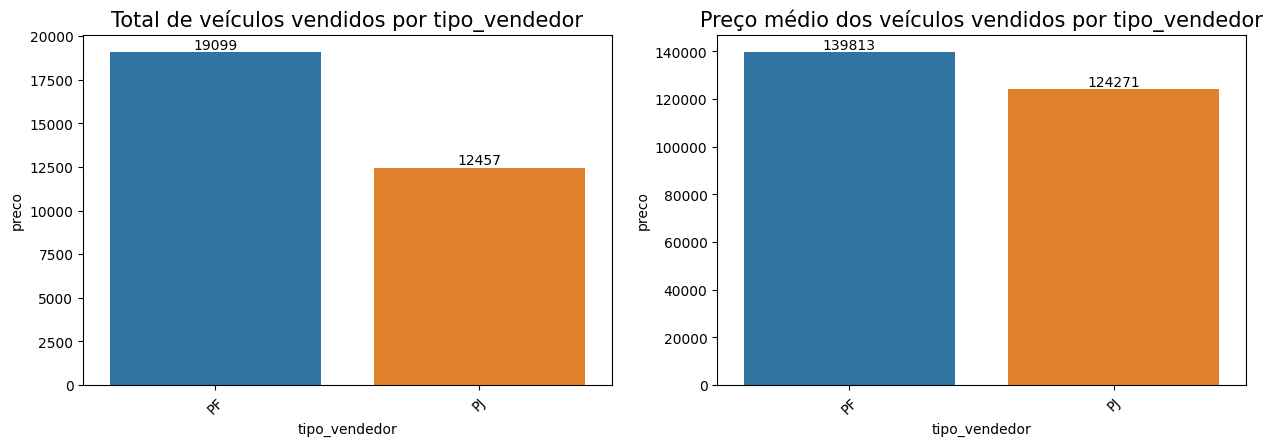

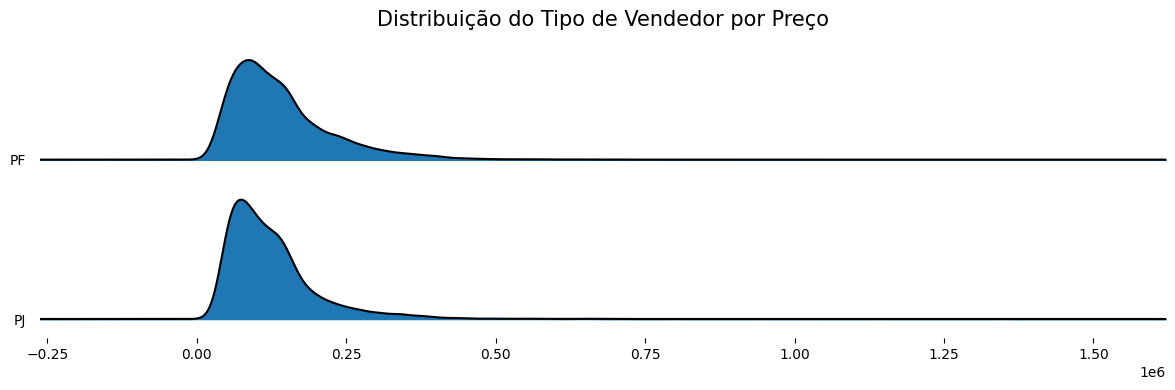

In [97]:
plt.figure(figsize=(15,10))
grid = gridspec.GridSpec(2,2)

plt.subplot(grid[0,0])
plt.title('Total de veículos vendidos por tipo_vendedor', fontsize=15)
aux = df5[['tipo_vendedor','preco']].groupby('tipo_vendedor').count().reset_index().sort_values(by='tipo_vendedor')
g = sns.barplot(x='tipo_vendedor', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f')
plt.xticks(rotation=45);

plt.subplot(grid[0,1])
plt.title('Preço médio dos veículos vendidos por tipo_vendedor', fontsize=15)
aux = df5[['tipo_vendedor','preco']].groupby('tipo_vendedor').mean().reset_index().sort_values(by='tipo_vendedor')
g = sns.barplot(x='tipo_vendedor', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f',rotation=0)
plt.xticks(rotation=45);

# plt.subplot(grid[1,:])
# plt.title('Boxplot dos veículos vendidos por tipo_vendedor', fontsize=15)
# aux = df5.sort_values(by='tipo_vendedor')
# sns.boxplot(x='tipo_vendedor', y = 'preco', data=aux)
# plt.xticks(rotation=45);

joyplot(df5, by='tipo_vendedor', column='preco', figsize=(12,4))
plt.title('Distribuição do Tipo de Vendedor por Preço', fontsize=15)
plt.tight_layout()

#### Cidade do Vendedor

- Variável com muitos labels
- Encoding: **Target Enconde**

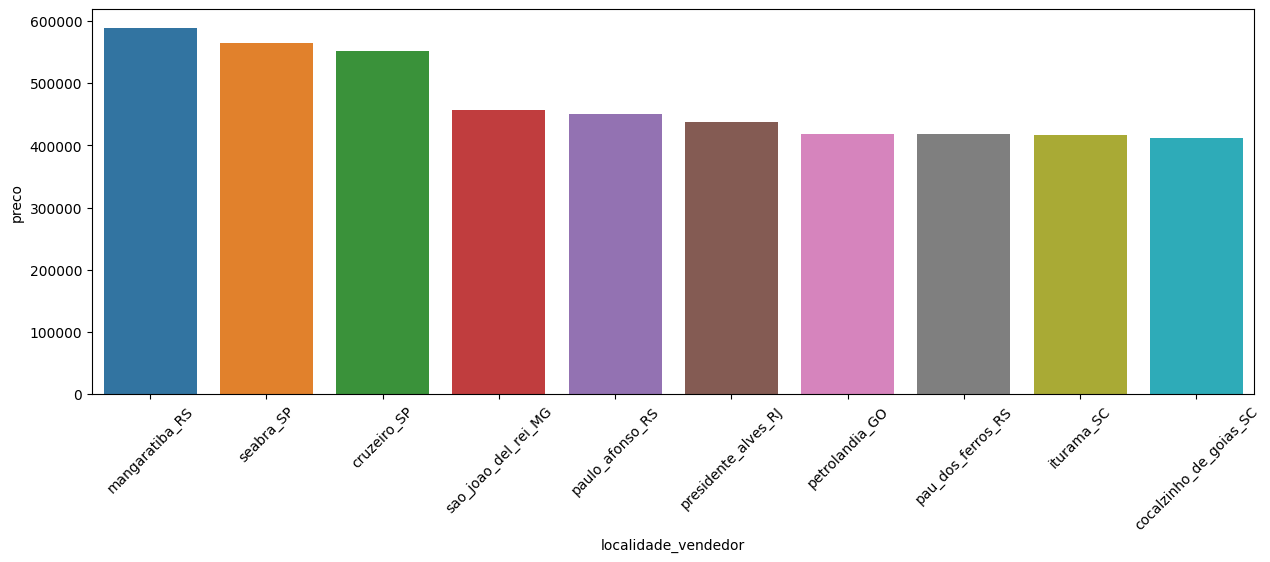

In [98]:
plt.figure(figsize=(15,5))
aux = df5[['localidade_vendedor','preco']].groupby('localidade_vendedor').mean().reset_index().sort_values(by='preco',ascending=False)[:10]
sns.barplot(x='localidade_vendedor', y = 'preco', data=aux)
plt.xticks(rotation=45);

#### Tipo de Anúncio

- Variáveis com labels que representam uma ideia de estado
- Encoding: **One Hot Encoding**

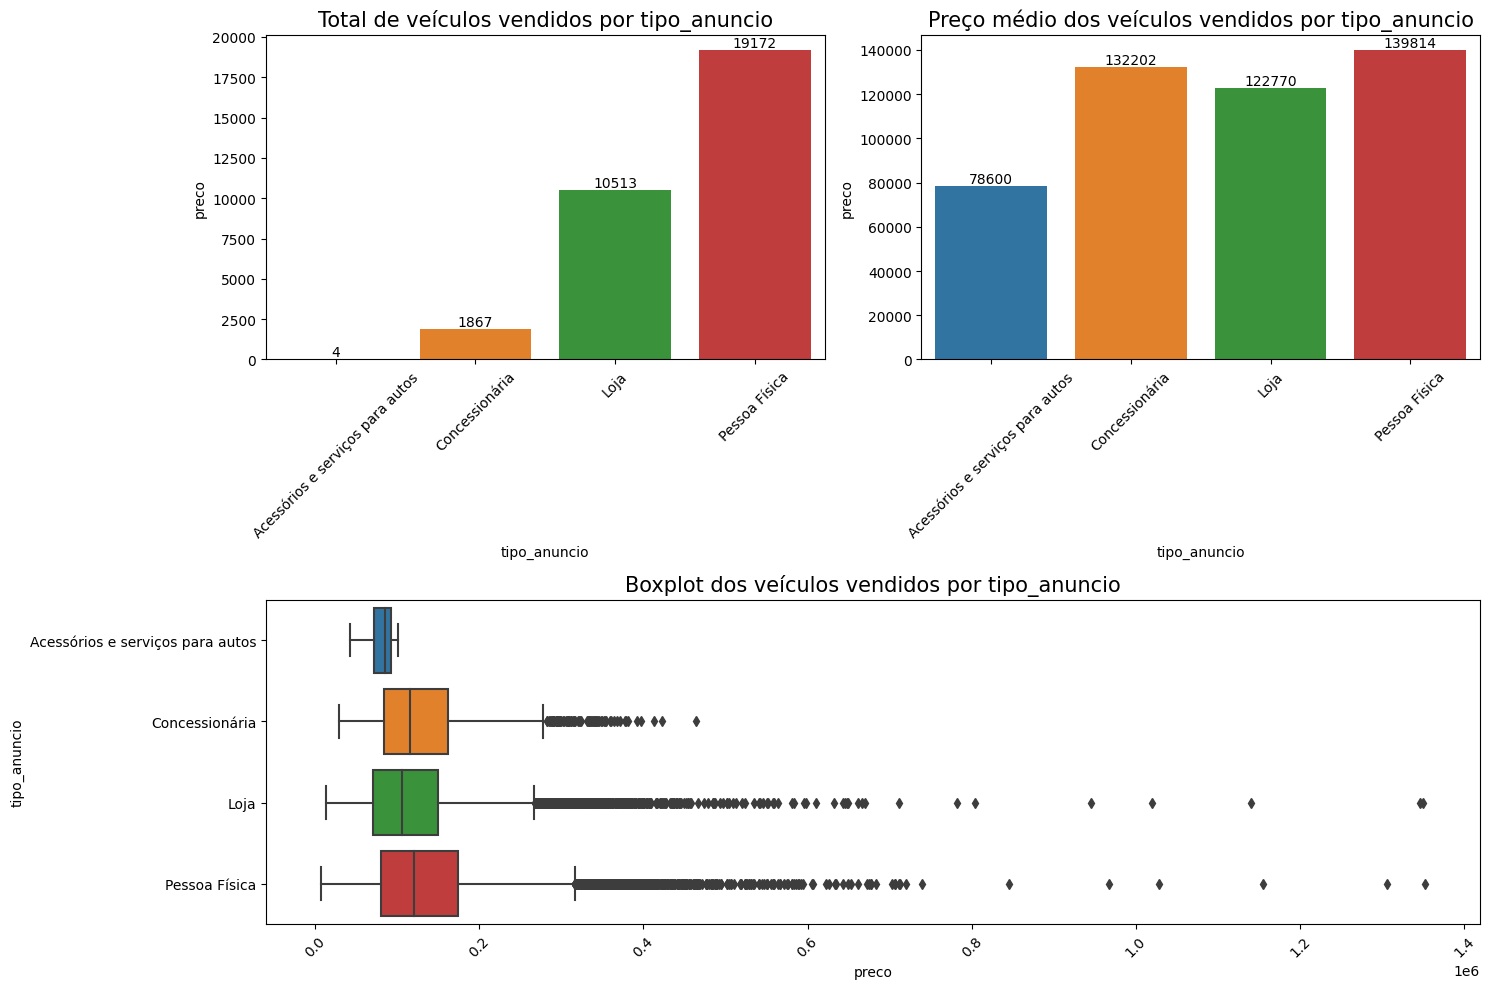

In [99]:
plt.figure(figsize=(15,10))
grid = gridspec.GridSpec(2,2)

plt.subplot(grid[0,0])
plt.title('Total de veículos vendidos por tipo_anuncio', fontsize=15)
aux = df5[['tipo_anuncio','preco']].groupby('tipo_anuncio').count().reset_index().sort_values(by='tipo_anuncio')
g = sns.barplot(x='tipo_anuncio', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f')
plt.xticks(rotation=45);

plt.subplot(grid[0,1])
plt.title('Preço médio dos veículos vendidos por tipo_anuncio', fontsize=15)
aux = df5[['tipo_anuncio','preco']].groupby('tipo_anuncio').mean().reset_index().sort_values(by='tipo_anuncio')
g = sns.barplot(x='tipo_anuncio', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f',rotation=0)
plt.xticks(rotation=45);

plt.subplot(grid[1,:])
plt.title('Boxplot dos veículos vendidos por tipo_anuncio', fontsize=15)
aux = df5.sort_values(by='tipo_anuncio')
sns.boxplot(x='preco', y = 'tipo_anuncio', data=aux)
plt.xticks(rotation=45);

plt.tight_layout()

#### Entrega Delivery

- Variável binária
- Encoding: **One Hot Encoding**

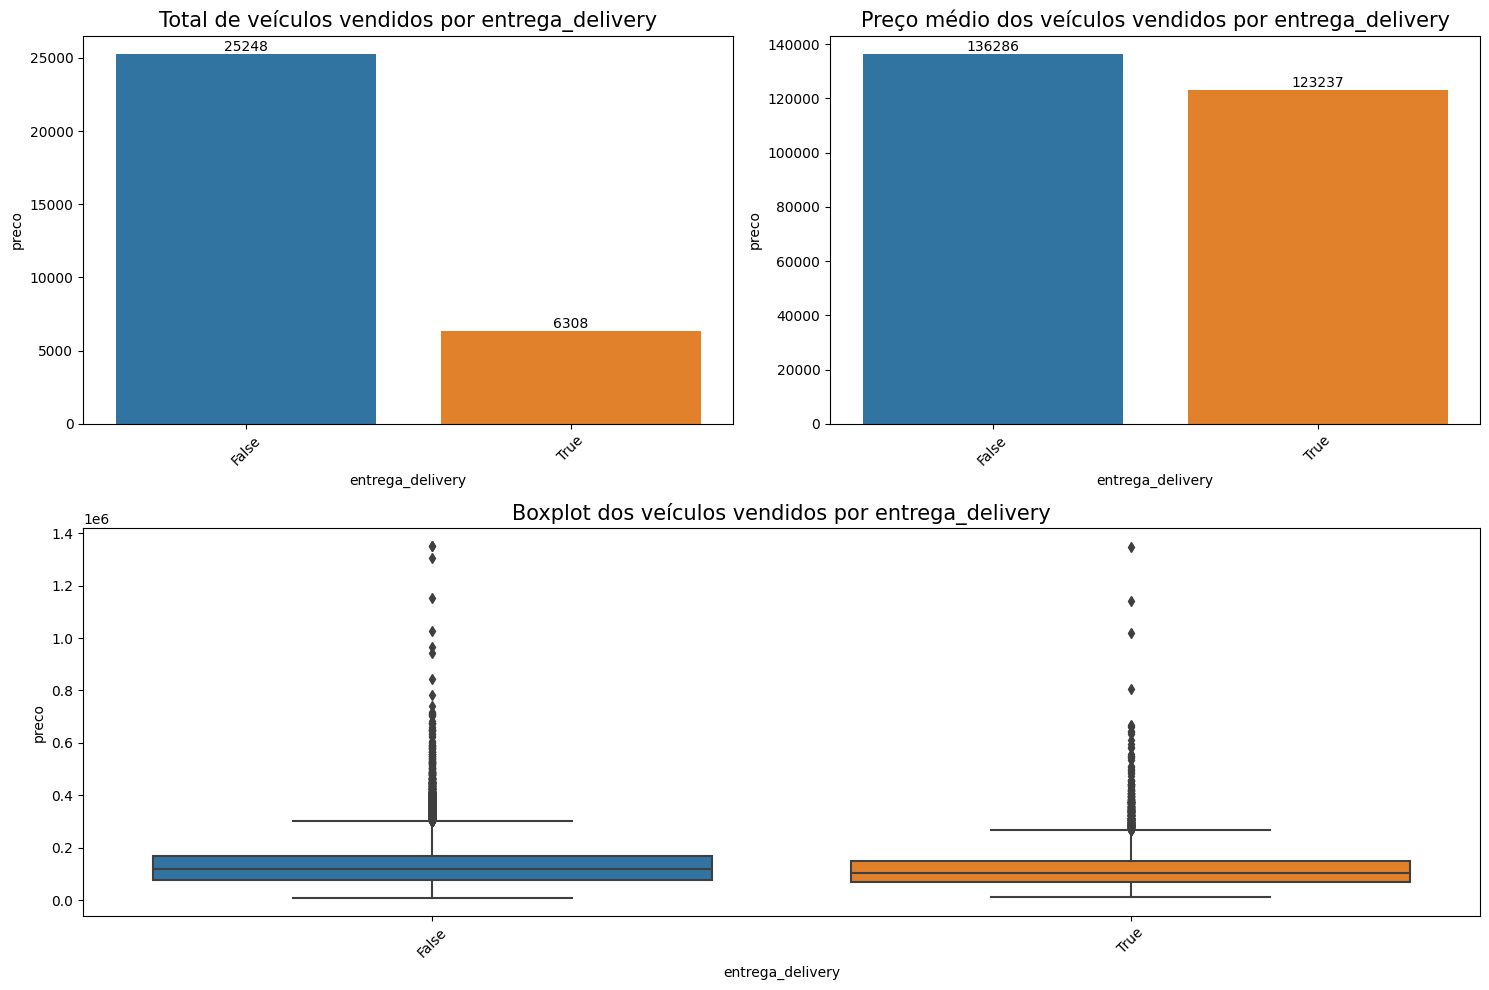

In [100]:
plt.figure(figsize=(15,10))
grid = gridspec.GridSpec(2,2)

plt.subplot(grid[0,0])
plt.title('Total de veículos vendidos por entrega_delivery', fontsize=15)
aux = df5[['entrega_delivery','preco']].groupby('entrega_delivery').count().reset_index().sort_values(by='entrega_delivery')
g = sns.barplot(x='entrega_delivery', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f')
plt.xticks(rotation=45);

plt.subplot(grid[0,1])
plt.title('Preço médio dos veículos vendidos por entrega_delivery', fontsize=15)
aux = df5[['entrega_delivery','preco']].groupby('entrega_delivery').mean().reset_index().sort_values(by='entrega_delivery')
g = sns.barplot(x='entrega_delivery', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f',rotation=0)
plt.xticks(rotation=45);

plt.subplot(grid[1,:])
plt.title('Boxplot dos veículos vendidos por entrega_delivery', fontsize=15)
aux = df5.sort_values(by='entrega_delivery')
sns.boxplot(x='entrega_delivery', y = 'preco', data=aux)
plt.xticks(rotation=45);

plt.tight_layout()

#### Troca

- Variável pouco significativa
- Remover

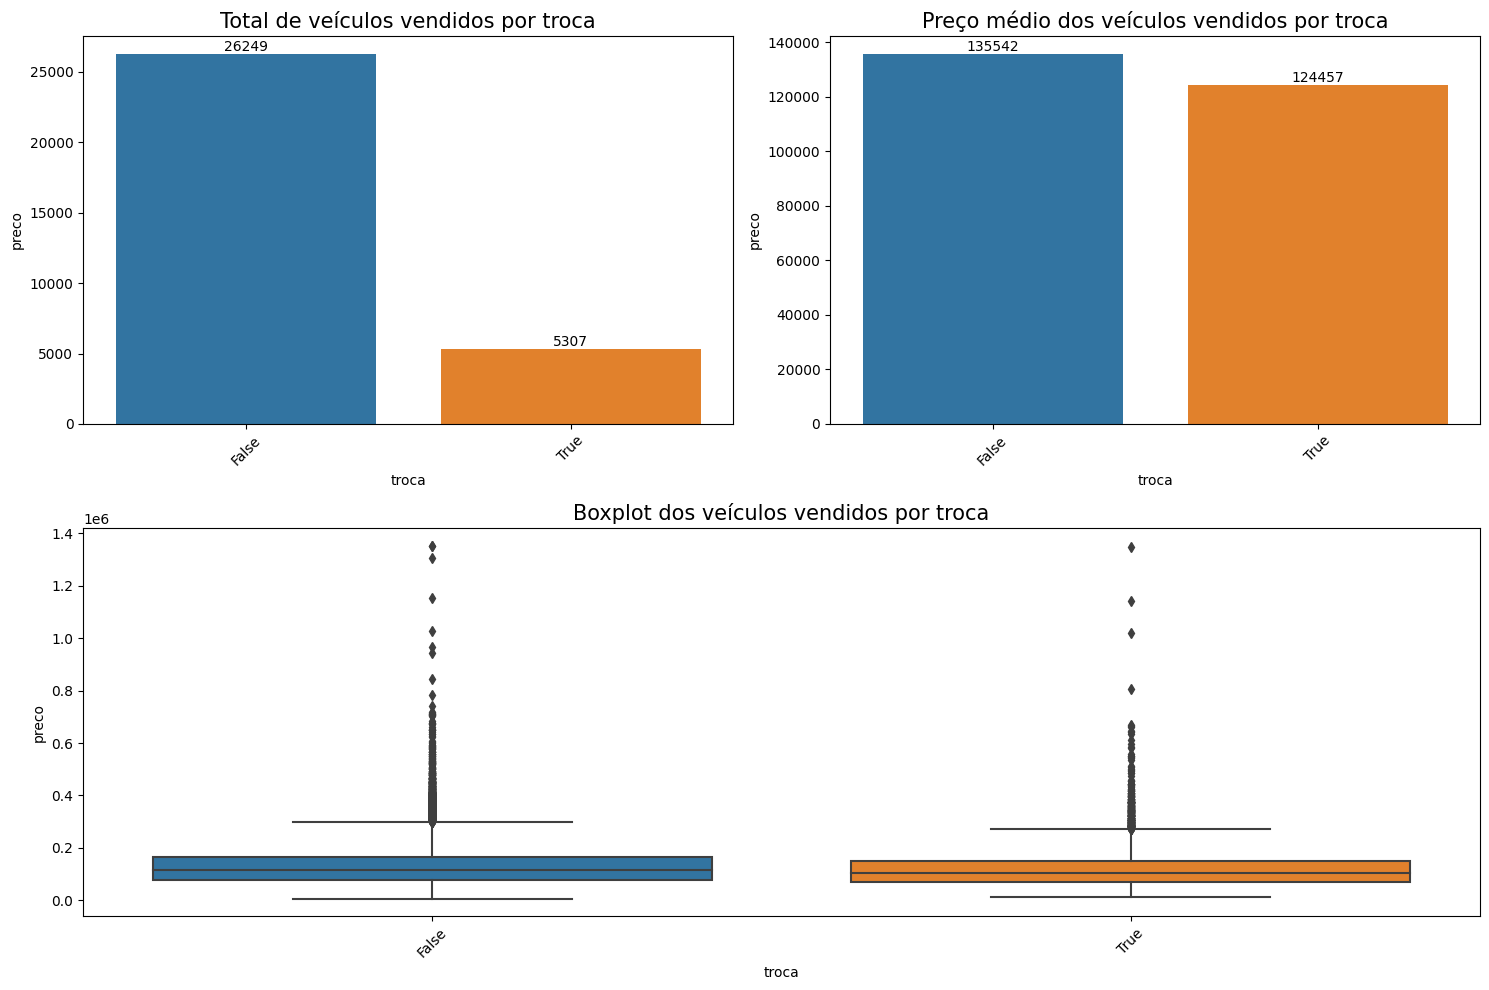

In [101]:
plt.figure(figsize=(15,10))
grid = gridspec.GridSpec(2,2)

plt.subplot(grid[0,0])
plt.title('Total de veículos vendidos por troca', fontsize=15)
aux = df5[['troca','preco']].groupby('troca').count().reset_index().sort_values(by='troca')
g = sns.barplot(x='troca', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f')
plt.xticks(rotation=45);

plt.subplot(grid[0,1])
plt.title('Preço médio dos veículos vendidos por troca', fontsize=15)
aux = df5[['troca','preco']].groupby('troca').mean().reset_index().sort_values(by='troca')
g = sns.barplot(x='troca', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f',rotation=0)
plt.xticks(rotation=45);

plt.subplot(grid[1,:])
plt.title('Boxplot dos veículos vendidos por troca', fontsize=15)
aux = df5.sort_values(by='troca')
sns.boxplot(x='troca', y = 'preco', data=aux)
plt.xticks(rotation=45);

plt.tight_layout()

#### Elegível revisão

- Variável pouco significativa
- Remover

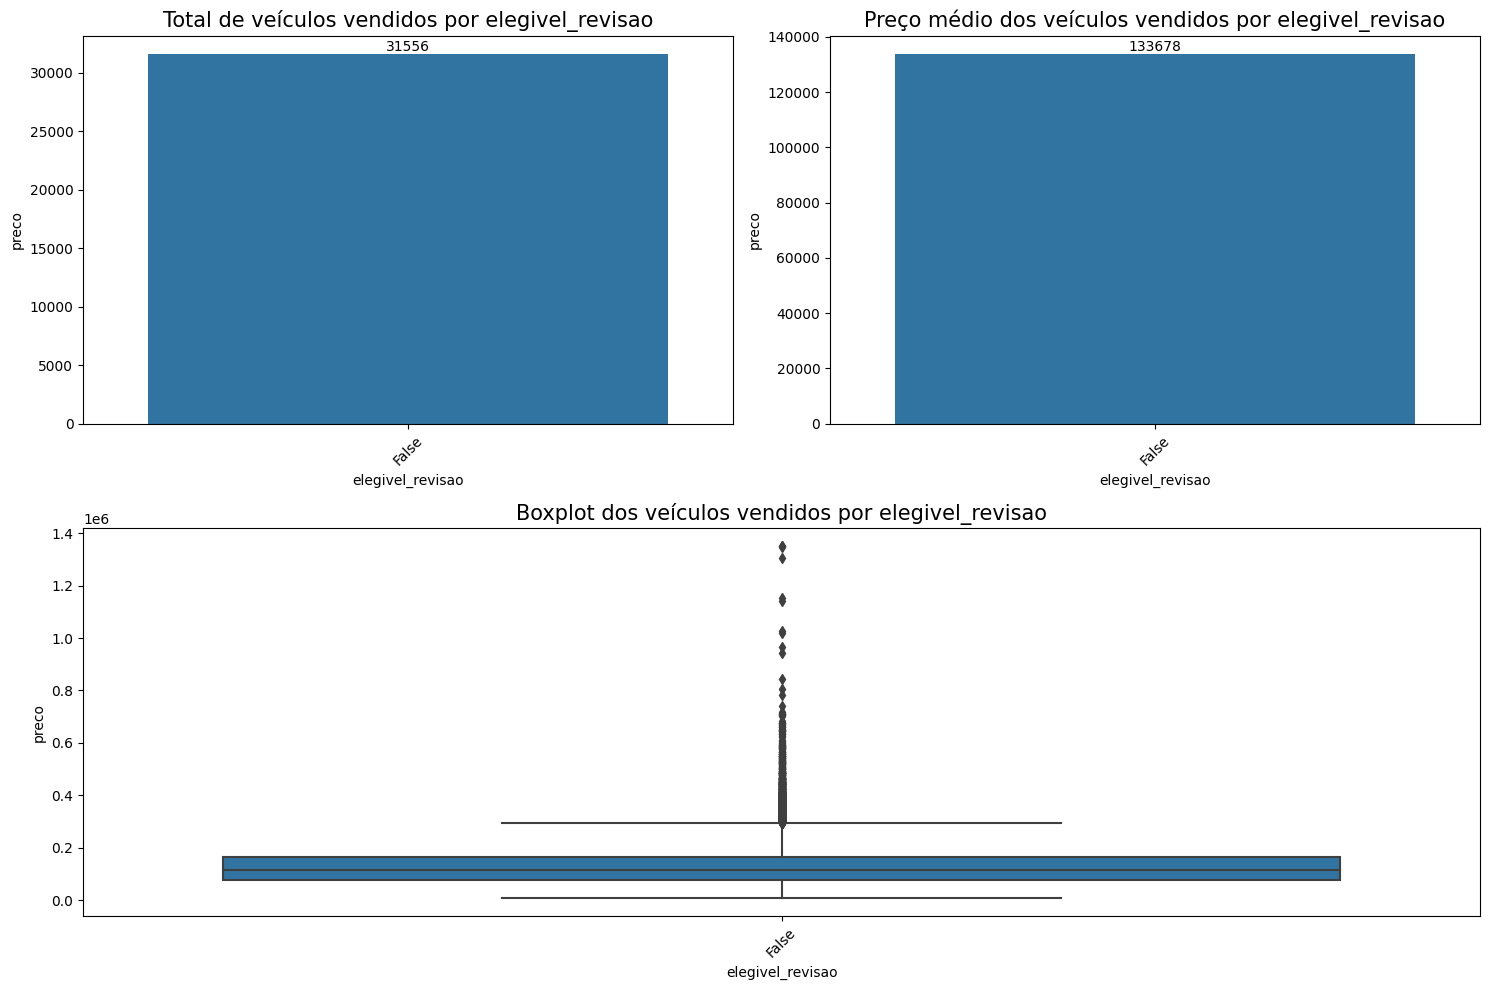

In [102]:
plt.figure(figsize=(15,10))
grid = gridspec.GridSpec(2,2)

plt.subplot(grid[0,0])
plt.title('Total de veículos vendidos por elegivel_revisao', fontsize=15)
aux = df5[['elegivel_revisao','preco']].groupby('elegivel_revisao').count().reset_index().sort_values(by='elegivel_revisao')
g = sns.barplot(x='elegivel_revisao', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f')
plt.xticks(rotation=45);

plt.subplot(grid[0,1])
plt.title('Preço médio dos veículos vendidos por elegivel_revisao', fontsize=15)
aux = df5[['elegivel_revisao','preco']].groupby('elegivel_revisao').mean().reset_index().sort_values(by='elegivel_revisao')
g = sns.barplot(x='elegivel_revisao', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f',rotation=0)
plt.xticks(rotation=45);

plt.subplot(grid[1,:])
plt.title('Boxplot dos veículos vendidos por elegivel_revisao', fontsize=15)
aux = df5.sort_values(by='elegivel_revisao')
sns.boxplot(x='elegivel_revisao', y = 'preco', data=aux)
plt.xticks(rotation=45);

plt.tight_layout()

#### Cilindradas

- Hipótese de que quanto mais raro o veículo com determinadas cilindradas, mais caro
- Encode: Frequency Encode

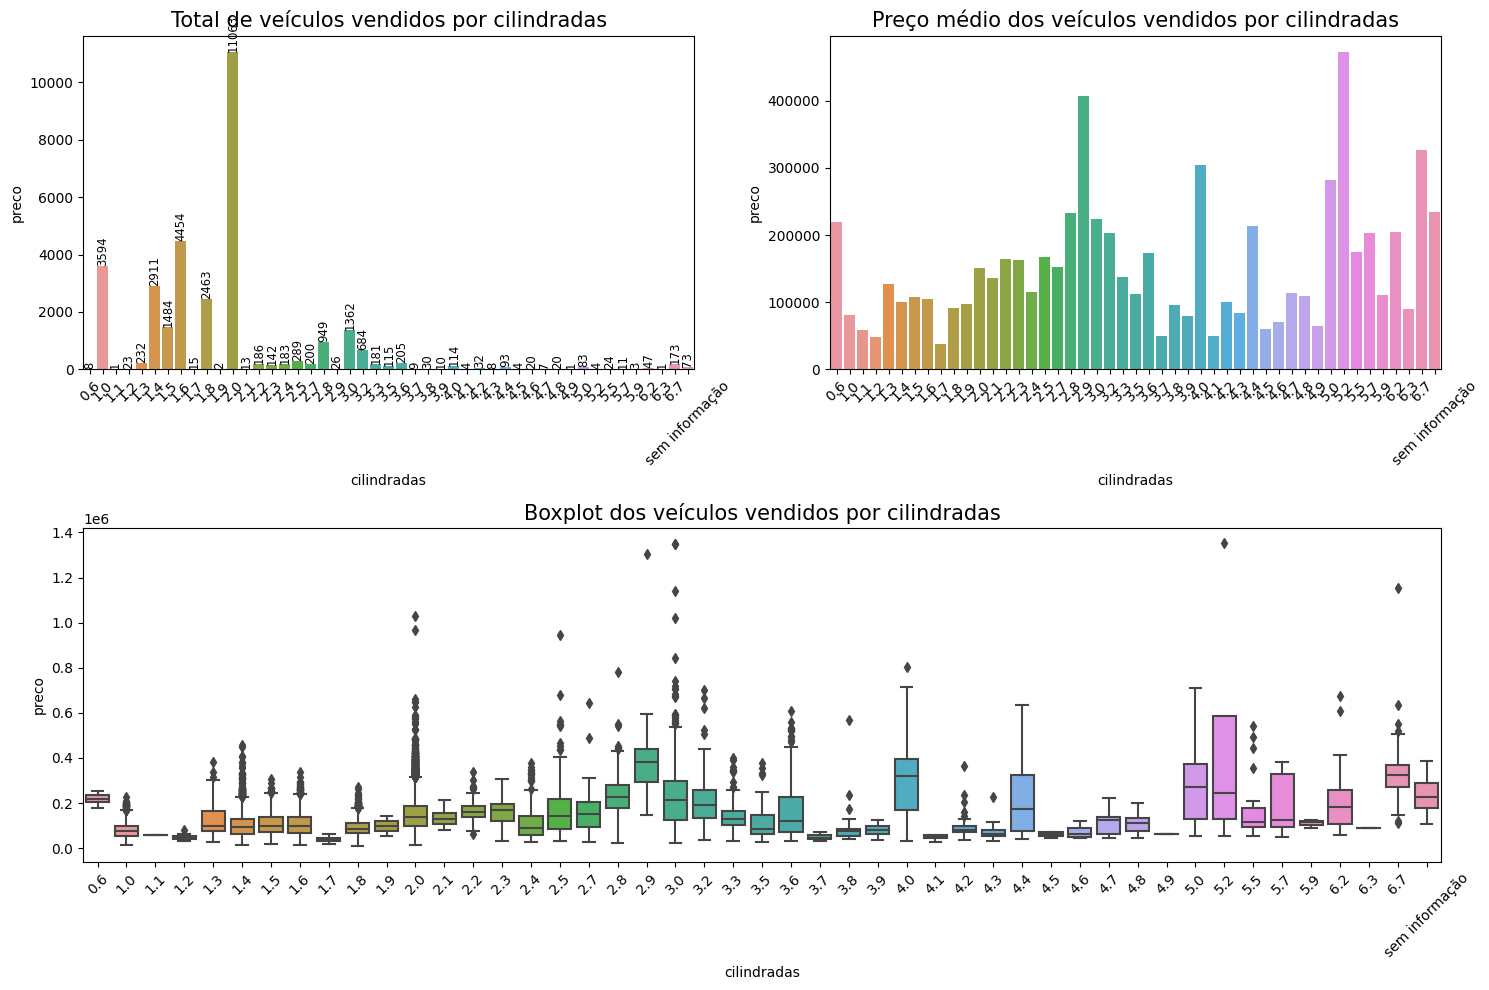

In [103]:
plt.figure(figsize=(15,10))
grid = gridspec.GridSpec(2,2)

plt.subplot(grid[0,0])
plt.title('Total de veículos vendidos por cilindradas', fontsize=15)
aux = df5[['cilindradas','preco']].groupby('cilindradas').count().reset_index().sort_values(by='cilindradas')
g = sns.barplot(x='cilindradas', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f',rotation=90, fontsize='small')
plt.xticks(rotation=45);

plt.subplot(grid[0,1])
plt.title('Preço médio dos veículos vendidos por cilindradas', fontsize=15)
aux = df5[['cilindradas','preco']].groupby('cilindradas').mean().reset_index().sort_values(by='cilindradas')
g = sns.barplot(x='cilindradas', y = 'preco', data=aux)
plt.xticks(rotation=45);

plt.subplot(grid[1,:])
plt.title('Boxplot dos veículos vendidos por cilindradas', fontsize=15)
aux = df5.sort_values(by='cilindradas')
sns.boxplot(x='cilindradas', y = 'preco', data=aux)
plt.xticks(rotation=45);

plt.tight_layout()

#### Válvulas

- Variável com muitas labels
- Encoding: **Target Encoding**

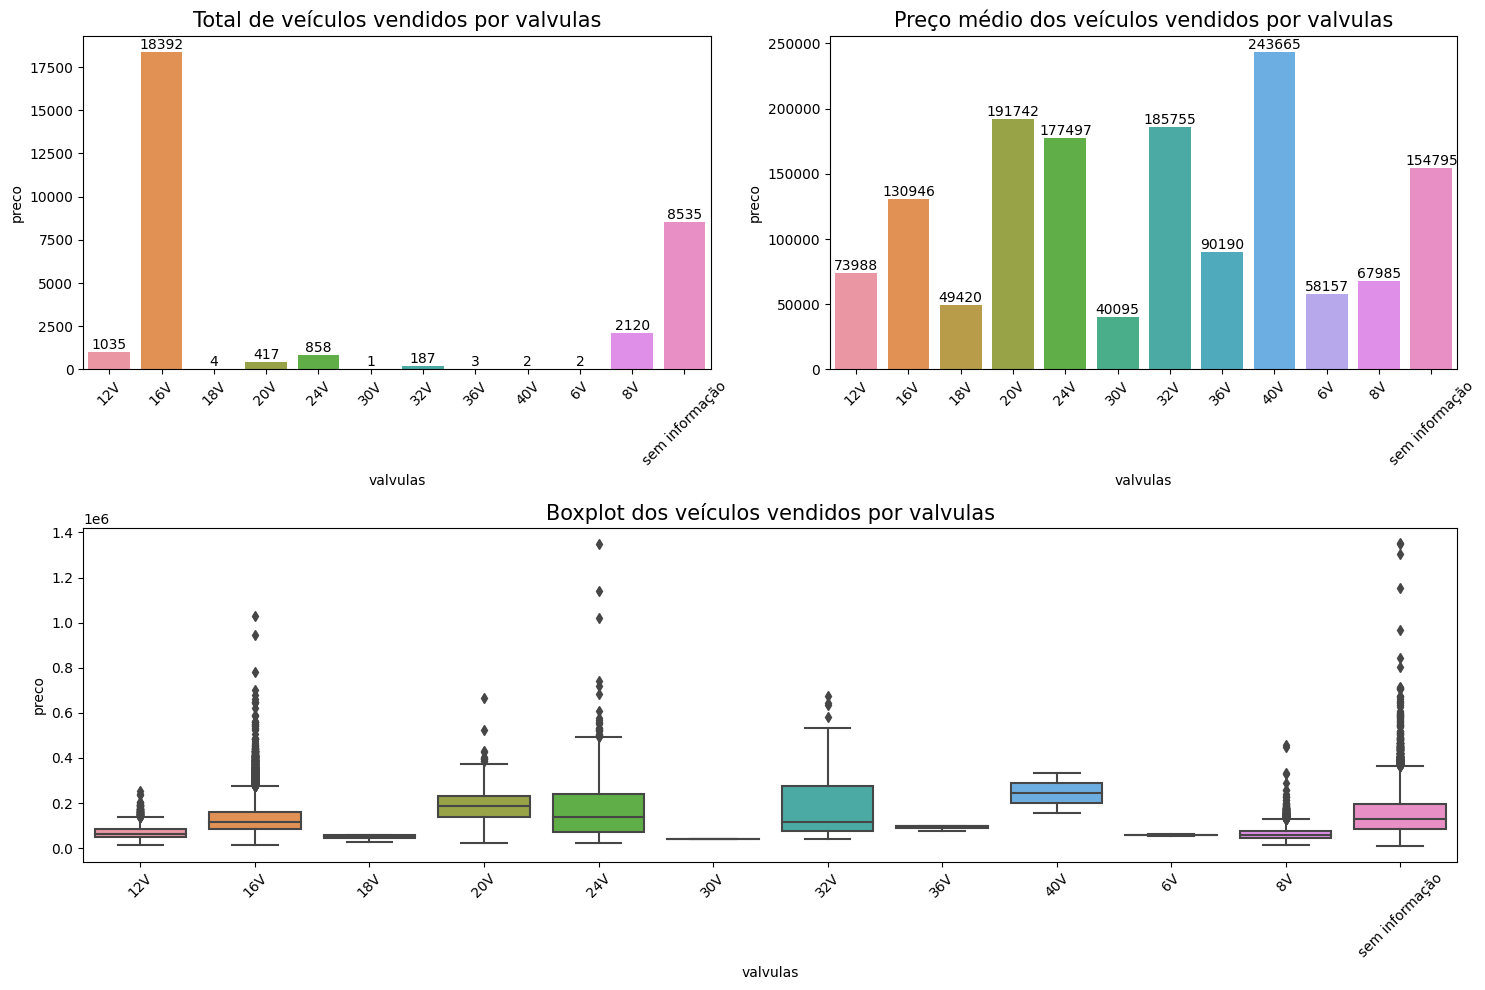

In [104]:
plt.figure(figsize=(15,10))
grid = gridspec.GridSpec(2,2)

plt.subplot(grid[0,0])
plt.title('Total de veículos vendidos por valvulas', fontsize=15)
aux = df5[['valvulas','preco']].groupby('valvulas').count().reset_index().sort_values(by='valvulas')
g = sns.barplot(x='valvulas', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f')
plt.xticks(rotation=45);

plt.subplot(grid[0,1])
plt.title('Preço médio dos veículos vendidos por valvulas', fontsize=15)
aux = df5[['valvulas','preco']].groupby('valvulas').mean().reset_index().sort_values(by='valvulas')
g = sns.barplot(x='valvulas', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f',rotation=0)
plt.xticks(rotation=45);

plt.subplot(grid[1,:])
plt.title('Boxplot dos veículos vendidos por valvulas', fontsize=15)
aux = df5.sort_values(by='valvulas')
sns.boxplot(x='valvulas', y = 'preco', data=aux)
plt.xticks(rotation=45);

plt.tight_layout()

#### Combustivel

- Variável com muitas labels
- Encoding: **Frequency Encoding**

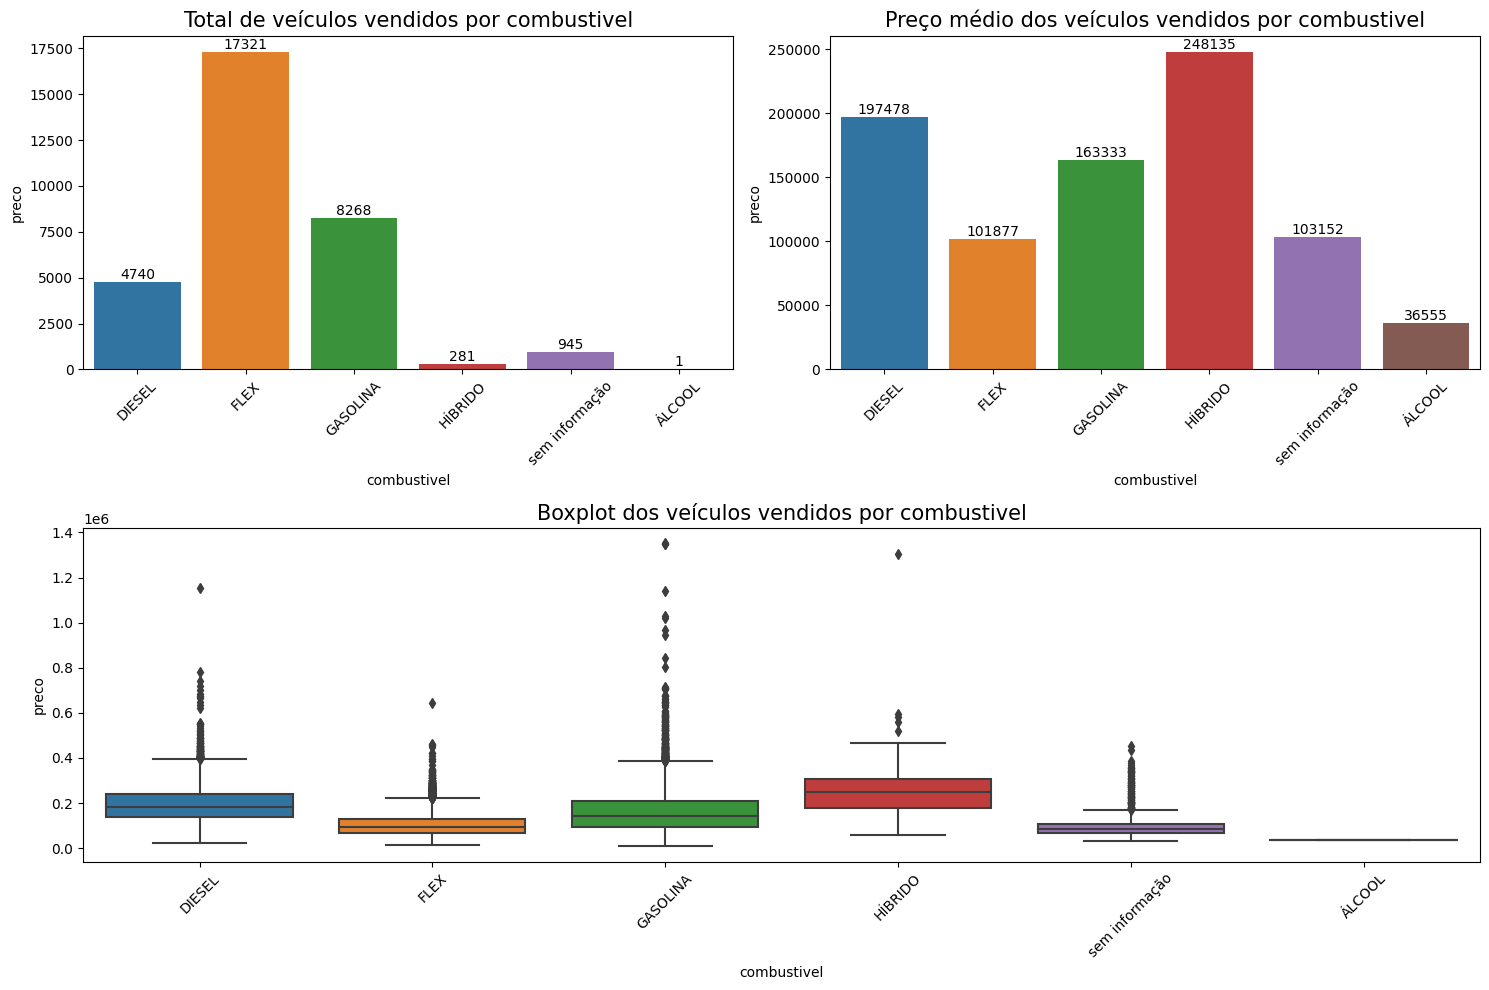

In [105]:
plt.figure(figsize=(15,10))
grid = gridspec.GridSpec(2,2)

plt.subplot(grid[0,0])
plt.title('Total de veículos vendidos por combustivel', fontsize=15)
aux = df5[['combustivel','preco']].groupby('combustivel').count().reset_index().sort_values(by='combustivel')
g = sns.barplot(x='combustivel', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f')
plt.xticks(rotation=45);

plt.subplot(grid[0,1])
plt.title('Preço médio dos veículos vendidos por combustivel', fontsize=15)
aux = df5[['combustivel','preco']].groupby('combustivel').mean().reset_index().sort_values(by='combustivel')
g = sns.barplot(x='combustivel', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f',rotation=0)
plt.xticks(rotation=45);

plt.subplot(grid[1,:])
plt.title('Boxplot dos veículos vendidos por combustivel', fontsize=15)
aux = df5.sort_values(by='combustivel')
sns.boxplot(x='combustivel', y = 'preco', data=aux)
plt.xticks(rotation=45);

plt.tight_layout()

## Top Insights

### Mind Map de Hipóteses

ValueError: Could not save to JPEG for display

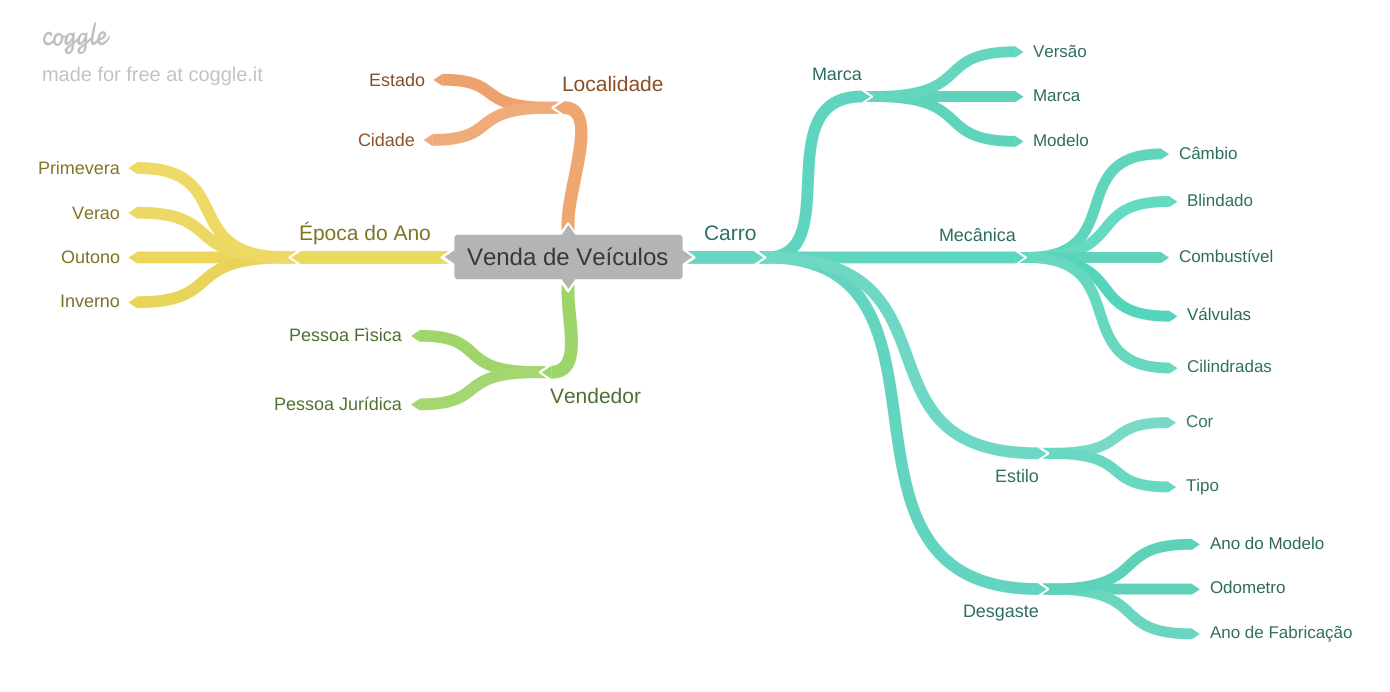

In [106]:
import IPython.display as display
from PIL import Image
display.display(Image.open('images/Venda_de_Veiculos.png'))

#### H1. Carros com maior número de quilometros rodados são mais baratos

- VERDADEIRO
- Quanto mais quilometros rodados o carro tiver, mais barato isso será. Isso pode ser observado também sabendo que após 20 mil quilometros rodados o carro passa a ser considerado usado ao invés de semi novo, o que reduz bastante seu preço

<Axes: xlabel='odometro', ylabel='preco'>

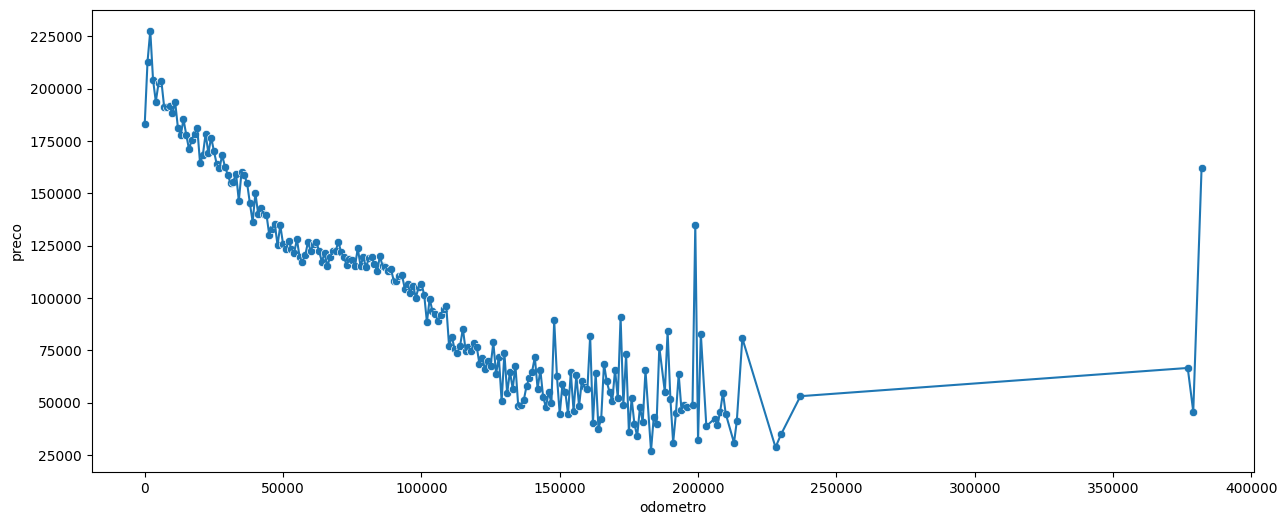

In [126]:
aux = df5[['odometro', 'preco']]
aux['odometro'] = df5['odometro'].apply(lambda x: round(x/1000,0)*1000)
aux = aux.groupby('odometro').mean().reset_index()

plt.figure(figsize=(15,6))
sns.scatterplot(x='odometro', y = 'preco', data=aux, markers='o')
sns.lineplot(x='odometro', y = 'preco', data=aux, markers='o')

#### H2. Carro mais antigos tendem a ter um preço menor 

- VERDADEIRO
- Quanto mais antigo o carro seu preço tende a ser mais baixo. Mas isso ocorre até certo ponto:
        
    - Os motoristas parecem preferir carros fabricados até 10 anos atrás
    - Carros com mais de 10 anos de existância tem um preço menor mas esse preço se estabiliza na faixa dos RS 60 mil
    - Somenta para carros com mais de 40 anos que esse valor parece cair novamente

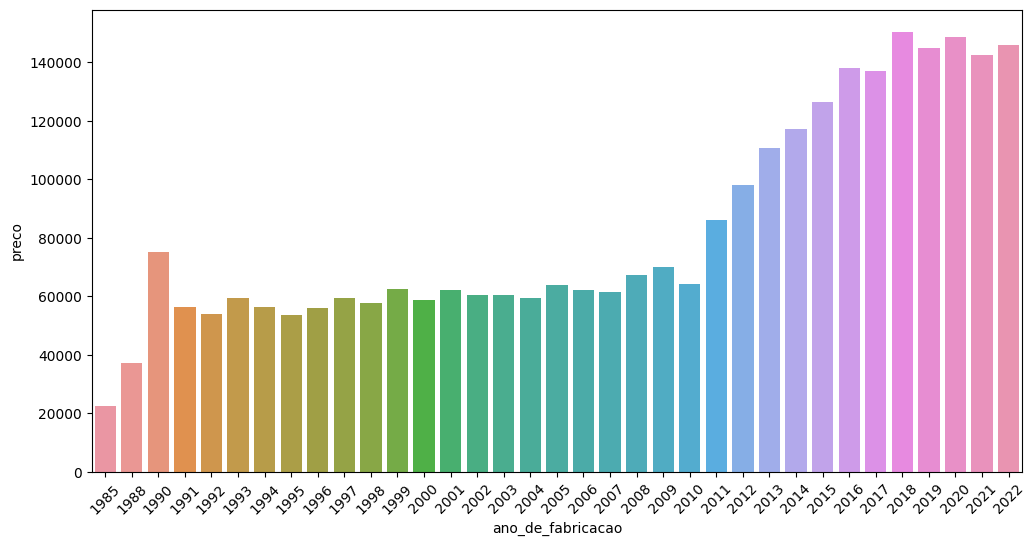

In [138]:
aux = df5[['ano_de_fabricacao','preco']]
aux = aux.groupby('ano_de_fabricacao').mean().reset_index()

plt.figure(figsize=(12,6))
g = sns.barplot(x='ano_de_fabricacao', y='preco', data=aux)
plt.xticks(rotation=45);
# for i in g.containers:
#     g.bar_label(i, fmt='%6.0f',fontsize='small',rotation=45)
# plt.xticks(rotation=45);

# Data Preparation

In [181]:
df6 = df5.copy()

In [182]:
# data Split

X_train = df6.drop('preco', axis=1)
y_train = df6['preco']

X_test = data_test.drop('preco', axis=1)
y_test = data_test['preco']

In [183]:
print(f'Treino: {X_train.shape[0]}')
print(f'Test: {X_test.shape[0]}')

Treino: 31556
Test: 7890


## Transformando variável resposta

In [184]:
y_train = pd.DataFrame(np.log1p(y_train))

## Standarization

In [185]:
sc = pp.StandardScaler()
y_train_norm= sc.fit_transform(y_train)
pickle.dump(sc, open('api/parameters/sc_response.pkl','wb'))

sc = pp.StandardScaler()
X_train['km_media_ano_em_1k_km'] = sc.fit_transform(X_train[['km_media_ano_em_1k_km']])
pickle.dump(sc, open('api/parameters/sc_km_media_ano.pkl','wb'))

## Rescaling

| Atributo               | Rescaling  |
| ---------------------- | ------------- |
|**ano_de_fabricação** | Robust Scaler |
|**ano_modelo:** | Robust Scaler|
|**odometro:** | Robust Scaler|
|**num_portas:** | Ordinal Encode|

### Robust Scaler

In [186]:
rs = pp.RobustScaler()

X_train['ano_de_fabricacao'] = rs.fit_transform(X_train[['ano_de_fabricacao']])
pickle.dump(rs, open('api/parameters/rs_ano_de_fabricacao.pkl','wb'))

X_train['ano_modelo'] = rs.fit_transform(X_train[['ano_modelo']])
pickle.dump(rs, open('api/parameters/rs_ano_modelo.pkl','wb'))

X_train['odometro'] = rs.fit_transform(X_train[['odometro']])
pickle.dump(rs, open('api/parameters/rs_odometro.pkl','wb'))

## Encodings

| Atributo                | Encode          |
| ----------------------- | --------------- |
| **marca:**              | Frequency Encode| 
| **modelo:**             | Frequency Encode| 
| **versao:**             | Frequency Encode| 
| **cambio:**             | Ordinal Enconde| 
| **tipo:**               | Target Encode| 
| **blindado:**           | One Hot Encode| 
| **cor:**                | Target Encode| 
| **tipo_vendedor:**   | One Hot Encode| 
| **cidade_vendedor:** | Target Encode| 
| **tipo_anuncio:**   | One Hot Encode| 
| **cilindradas:**        | Frequency Encode| 
| **valvulas:**           | Target Encode| 
| **combustivel:**        | Target Encode| 

### One Hot Encode

In [187]:
# blindado
X_train['blindado'] = X_train['blindado'].replace({'S':1, 'N':0})

# tipo_vendedor
X_train['tipo_vendedor'] = X_train['tipo_vendedor'].replace({'PJ':1, 'PF':0})

# tipo_anuncio
oe = pp.OneHotEncoder(sparse=False,handle_unknown='ignore')
X_train['tipo_anuncio'] = X_train['tipo_anuncio'].apply(lambda x: unidecode(x).lower().replace(' ','_'))
cols_dummies = oe.fit_transform(X_train['tipo_anuncio'].values.reshape(-1,1))
X_train[oe.categories_[0]] = cols_dummies
pickle.dump(oe,open(f'api/parameters/oe_tipo_anuncio.pkl', 'wb'))

X_train['cambio'] = X_train['cambio'].map({'Manual':0,
                                            'Automática Sequencial':1, 
                                            'Semi-automática':2,
                                            'CVT':3,
                                            'Automatizada':4,
                                            'Automática':4,
                                            'Automatizada DCT':5
                                            })

X_train['num_portas'] = X_train['num_portas'].apply(lambda x: 1 if x > 2 else 0)

### Target Enconde

In [189]:
for att in ['tipo','cor', 'localidade_vendedor','valvulas','combustivel', 'veiculo']:
    te = ce.TargetEncoder(cols=[att], handle_unknown = 'return_nan').fit(X_train, y_train_norm)
    pickle.dump(te, open(f'api/parameters/te_{att}.pkl','wb'))
    X_train = te.transform(X_train)

### Frequency Encode

In [190]:
for att in ['marca', 'modelo','versao','cilindradas']:
    fe =  ce.CountEncoder(cols=[att], normalize=True, handle_unknown = 'return_nan').fit(X_train)
    pickle.dump(fe,open(f'api/parameters/fe_{att}.pkl', 'wb'))
    X_train = fe.transform(X_train)

## Test Preparation

In [191]:
X_test = X_test.drop(cols_drop, axis=1)

In [192]:
y_test = pd.DataFrame(np.log1p(y_test))

# extraindo as cilindradas da coluna versão
X_test['cilindradas'] = X_test['versao'].apply(lambda x: extract_power(re.search(r"\d+\.\d+",x)))

# extraindo válvulas da coluna versão
X_test['valvulas'] = X_test['versao'].apply(lambda x: extract_power(re.search(r"\d+V",x)))

# extraindo combustível da coluna versão
X_test['combustivel'] = X_test['versao'].apply(lambda x: 'GASOLINA' if 'GASOLINA' in x else 
                                                   'FLEX' if 'FLEX'     in x else 
                                                   'DIESEL' if 'DIESEL'   in x else 
                                                   'ÁLCOOL' if 'ÁLCOOL' in x else
                                                   'HÍBRIDO' if 'HYBRID' in x else
                                                   'HÍBRIDO' if 'HÍBRIDO' in x else 'sem informação')

# removendo features derivadas da coluna original
X_test['versao'] = X_test.apply(lambda x: x['versao'].replace(x['cilindradas'],'').replace(x['valvulas'], '').replace(x['combustivel'],'').replace(' AUTOMÁTICO', '').replace(' MANUAL', '').replace('  ',' '), axis=1)

# retirando acentos, substituindo letras maiúsculas e espaços
X_test['cidade_vendedor'] = X_test['cidade_vendedor'].apply(lambda x: unidecode(x).lower().replace(' ','_'))

# extraindo estado
X_test['estado_vendedor'] = X_test['estado_vendedor'].apply(lambda x: re.search(r'\((.*?)\)',x).group(1))

# criando feature de localidade
X_test['localidade_vendedor'] = X_test['cidade_vendedor'] + "_" + X_test['estado_vendedor']

# criando feature de km médio rodado por ano
X_test['km_media_ano_em_1k_km'] = X_test['odometro']/np.round(2023 - X_test['ano_modelo'] + 0.51,0)
# arredondando e escalando por 1000 km
X_test['km_media_ano_em_1k_km'] = round(X_test['km_media_ano_em_1k_km'] / 1000, 0).astype(int)

# criando feature de agregação do veículo com marca, modelo, km_media e localidade
X_test['veiculo'] = X_test['marca'].astype(str) + "_" + X_test['modelo'].astype(str) #+ "_" + X_test['km_media_ano_em_1k_km'].astype(str)

In [193]:
X_test.shape

(7890, 24)

In [194]:
sc = pickle.load(open('api/parameters/sc_km_media_ano.pkl','rb'))
X_test['km_media_ano_em_1k_km'] = sc.transform(X_test[['km_media_ano_em_1k_km']])

# Rescaling
rs = pickle.load(open('api/parameters/rs_ano_de_fabricacao.pkl','rb'))
X_test['ano_de_fabricacao'] = rs.transform(X_test[['ano_de_fabricacao']])

rs = pickle.load(open('api/parameters/rs_ano_modelo.pkl','rb'))
X_test['ano_modelo'] = rs.transform(X_test[['ano_modelo']])

rs = pickle.load(open('api/parameters/rs_odometro.pkl','rb'))
X_test['odometro'] = rs.transform(X_test[['odometro']])

# Encode
## One Hot Encode
# blindado
X_test['blindado'] = X_test['blindado'].replace({'S':1, 'N':0})

# tipo_vendedor
X_test['tipo_vendedor'] = X_test['tipo_vendedor'].replace({'PJ':1, 'PF':0})

# tipo_anuncio
oe = pickle.load(open(f'api/parameters/oe_tipo_anuncio.pkl', 'rb'))
X_test['tipo_anuncio'] = X_test['tipo_anuncio'].apply(lambda x: unidecode(x).lower().replace(' ','_'))
cols_dummies = oe.transform(X_test['tipo_anuncio'].values.reshape(-1,1))
X_test[oe.categories_[0]] = cols_dummies


X_test['cambio'] = X_test['cambio'].map({'Manual':0,
                                            'Automática Sequencial':1, 
                                            'Semi-automática':2,
                                            'CVT':3,
                                            'Automatizada':4,
                                            'Automática':4,
                                            'Automatizada DCT':5
                                            })

X_test['num_portas'] = X_test['num_portas'].apply(lambda x: 1 if x > 2 else 0)

In [195]:
X_test

marca   modelo                              versao  \
10615     VOLKSWAGEN      FOX                   MSI TRENDLINE  4P   
23654      CHEVROLET     SPIN                             LTZ  4P   
7986            AUDI       Q3   TFSI AMBIENTE QUATTRO 4P S TRONIC   
12196           JEEP  COMPASS                             LIMITED   
10851     VOLKSWAGEN     POLO                         250 TSI GTS   
...              ...      ...                                 ...   
11730            BMW     320i                     TURBO ACTIVE 4P   
31513            BMW       X1    TURBO ACTIVE SDRIVE20I X-LINE 4P   
32015  MERCEDES-BENZ    C 250                 CGI SPORT TURBO  4P   
34167  MERCEDES-BENZ    A 200                     TURBO URBAN  4P   
34978     MITSUBISHI      ASX                             4X2  4P   

       ano_de_fabricacao  ano_modelo  odometro  cambio  num_portas  \
10615              -0.75       -0.25  0.352798       0           1   
23654              -0.25        0.00  0.018860       4           1   
7986               -0.25       -0.25  0.115703       4           1   
12196               0.50        0.50 -0.523841       4           1   
10851               0.50        0.75 -0.547368       4           1   
...                  ...         ...       ...     ...         ...   
11730              -1.00       -1.00  0.299819       4           1   
31513               0.75        0.75 -0.947277       4           1   
32015              -0.75       -0.75  0.392979       4           1   
34167              -1.25       -1.25  0.723570       4           1   
34978              -1.25       -1.00  0.590680       4           1   

                       tipo  blindado  ... cilindradas        valvulas  \
10615                  Sedã         0  ...         1.6              8V   
23654                  Sedã         0  ...         1.8              8V   
7986                   Sedã         0  ...         2.0  sem informação   
12196                  Sedã         0  ...         2.0             16V   
10851             Hatchback         0  ...         1.4  sem informação   
...                     ...       ...  ...         ...             ...   
11730                  Sedã         0  ...         2.0             16V   
31513  Utilitário esportivo         0  ...         2.0             16V   
32015                  Sedã         0  ...         2.0             16V   
34167             Hatchback         0  ...         1.6             16V   
34978                  Sedã         0  ...         2.0             16V   

          combustivel localidade_vendedor km_media_ano_em_1k_km  \
10615            FLEX         curitiba_PR              0.436800   
23654            FLEX        sao_paulo_SP              0.172780   
7986         GASOLINA   rio_de_janeiro_BA             -0.091239   
12196            FLEX        sao_paulo_SP             -0.355258   
10851  sem informação          goiania_GO              0.172780   
...               ...                 ...                   ...   
11730            FLEX           recife_SC             -0.619277   
31513            FLEX         campinas_SP             -1.675354   
32015        GASOLINA          goiania_SC             -0.091239   
34167        GASOLINA        sao_paulo_SP             -0.091239   
34978        GASOLINA   rio_das_ostras_RJ             -0.091239   

                   veiculo  acessorios_e_servicos_para_autos  concessionaria  \
10615       VOLKSWAGEN_FOX                               0.0             0.0   
23654       CHEVROLET_SPIN                               0.0             0.0   
7986               AUDI_Q3                               0.0             0.0   
12196         JEEP_COMPASS                               0.0             0.0   
10851      VOLKSWAGEN_POLO                               0.0             0.0   
...                    ...                               ...             ...   
11730             BMW_320i                               0.0             0.0   
31513      

In [196]:
## Target Encode
for att in ['tipo','cor', 'localidade_vendedor','valvulas','combustivel', 'veiculo']:
    te = pickle.load(open(f'api/parameters/te_{att}.pkl','rb'))
    X_test =te.transform(X_test)

In [197]:
## Frequency Encode
for att in ['marca', 'modelo','versao','cilindradas']:
    fe = pickle.load(open(f'api/parameters/fe_{att}.pkl', 'rb'))
    X_test = fe.transform(X_test)

In [198]:
## KNN Imputer
## Preenche valores de target e frequency encode não encontratos
imputer = KNNImputer(n_neighbors=5, copy=True)
original_index = X_test.index

X_test = pd.DataFrame(imputer.fit_transform(X_test.drop(['cidade_vendedor','estado_vendedor','tipo_anuncio'],axis=1)),columns = X_test.drop(['cidade_vendedor','estado_vendedor','tipo_anuncio'],axis=1).columns)

X_test.index = original_index    

# Feature Selection

In [157]:
# features elegíveis
features = [
'veiculo',
'km_media_ano_em_1k_km',
'marca',
'modelo',
'versao',
'ano_de_fabricacao',
'ano_modelo',
'odometro',
'cambio',
'num_portas',
'tipo',
'blindado',
'cor',
'tipo_vendedor',
'cilindradas',
'valvulas',
'combustivel',
'localidade_vendedor',
'acessorios_e_servicos_para_autos',
'concessionaria',
'loja',
'pessoa_fisica'
]

## Boruta

In [216]:
# define a Random Rorest
rf = en.RandomForestRegressor(n_jobs=-1)

# define a Boruta instance
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state = 0 )

In [217]:
# train Boruta
boruta_result = boruta.fit(X_train[features].values, y_train.values)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	13
Iteration: 	9 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	13
Iteration: 	10 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	13
Iteration: 	11 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	13
Iteration: 	12 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	13
Iteration: 	13 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	13
Iteration: 	14 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	13
Iteration: 	15 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	13
Iteration: 	16 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	13
I

In [222]:
results = pd.DataFrame({'Feature':'', 'Ranking Boruta':'', "Test":''}, index=[0])
for i in range(len(boruta_result.support_)):
    if boruta_result.support_[i]:
        results.loc[i] = [features[i], int(boruta_result.ranking_[i]), 'Pass Boruta']
    else:
        results.loc[i] = [features[i], int(boruta_result.ranking_[i]), "Doesn't Pass Boruta"]
        
results['Ranking Boruta'] = results['Ranking Boruta'].astype('int64')

## Feature Importances

In [223]:
# model definition
forest = en.ExtraTreesRegressor(n_estimators=250, random_state=0, n_jobs=-1)

x_train_n = X_train[features]
y_train_n = y_train.values
forest.fit(x_train_n, y_train_n)

# Print the feature ranking
df = pd.DataFrame()
for i, j in zip(x_train_n.columns, forest.feature_importances_):
    aux = pd.DataFrame({'Feature': i, 'Importance': j},index=[0])
    df = pd.concat([df, aux], axis=0)
    
results = pd.merge(results, df, on ='Feature', how='left')

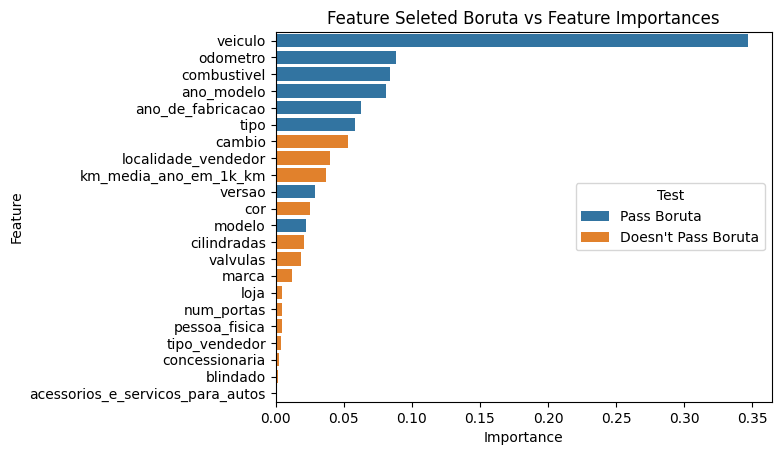

In [224]:
plt.title('Feature Seleted Boruta vs Feature Importances')
sns.barplot(x='Importance', y = 'Feature', hue='Test', data=results.sort_values('Importance', ascending=False),dodge = False);

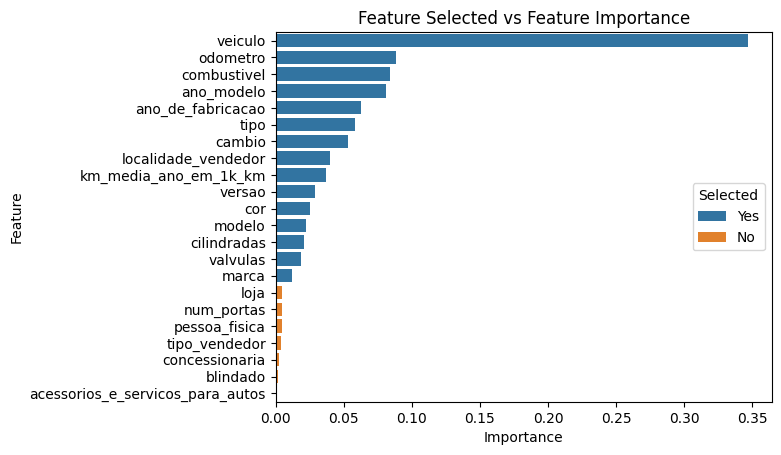

In [225]:
# features selecionadas
features_selected = [
'veiculo',
'marca',
'km_media_ano_em_1k_km',
'modelo',
'versao',
'ano_de_fabricacao',
'ano_modelo',
'odometro',
'cambio',
'cor',
'tipo',
'cilindradas',
'valvulas',
'combustivel',
'localidade_vendedor'
]

# adicionando coluna de features selecionadas
results['Selected'] = results.apply(lambda x: "Yes" if x['Feature'] in features_selected else "No", axis=1)

plt.title('Feature Selected vs Feature Importance')
sns.barplot(x='Importance', y = 'Feature', hue='Selected', data=results.sort_values('Importance', ascending=False),dodge = False);

In [158]:
# features selecionadas
features_selected = [
'veiculo',
'marca',
'km_media_ano_em_1k_km',
'modelo',
'versao',
'ano_de_fabricacao',
'ano_modelo',
'odometro',
'cambio',
'cor',
'tipo',
'cilindradas',
'valvulas',
'combustivel',
'localidade_vendedor'
]

# Machine Learning Model

## Linear Regression

In [242]:
# define model
lm_model = lm.LinearRegression()

# fit model
lm_model.fit(X_train[features_selected], y_train)

# predict
y_pred = lm_model.predict(X_test[features_selected])

# performance
ml_error('Linear Model', np.expm1(y_test), np.expm1(y_pred))

Model Name           MAE      MAPE          RMSE
0  Linear Model  31295.350232  0.253572  49323.533681

### Linear Model Cross Validation

In [243]:
cv_linear_model = cross_validation_k_fold(X, y, features_selected, 'Linear Model', lm_model, 10)
cv_linear_model

Model                    MAE             MAPE                   RMSE
0  Linear Model  31847.356 +/- 537.373  0.255 +/- 0.004  50889.875 +/- 1367.78

## Lasso

In [244]:
# model definition
lasso_model = lm.Lasso(alpha=0.01)

# fit model
lasso_model.fit(X_train[features_selected], y_train)

# predict
y_pred = lasso_model.predict(X_test[features_selected])

# performance
ml_error('Lasso', np.expm1(y_test), np.expm1(y_pred))

Model Name          MAE      MAPE          RMSE
0      Lasso  31684.46865  0.258431  50304.559993

### Lasso Cross Validation

In [245]:
cv_lasso = cross_validation_k_fold(X, y, features_selected, 'Lasso', lasso_model, 10)
cv_lasso 

Model                    MAE            MAPE                    RMSE
0  Lasso  32330.313 +/- 681.823  0.26 +/- 0.004  51940.039 +/- 1422.971

## Random Forest

In [246]:
# model definition
rf_model = en.RandomForestRegressor(n_jobs=-1, random_state=0)

# model fit
rf_model.fit(X_train[features_selected], y_train)

# predict
y_pred = rf_model.predict(X_test[features_selected])

# performance
ml_error('Random Forest', np.expm1(y_test), np.expm1(y_pred))

Model Name           MAE      MAPE          RMSE
0  Random Forest  25719.805106  0.209408  40518.305463

###  Random Forest Cross Validation

In [247]:
cv_rf = cross_validation_k_fold(X, y, features_selected, 'Random Forest', rf_model, 10)
cv_rf

Model                    MAE             MAPE  \
0  Random Forest  26382.991 +/- 496.385  0.211 +/- 0.003   

                     RMSE  
0  43010.375 +/- 2077.976

## XGBoost

In [248]:
# model definition
xgb_model = xgboost.XGBRegressor(n_jobs = -1 , random_state=0)

# model fit
xgb_model.fit(X_train[features_selected], y_train)
pickle.dump(xgb_model, open('api/model/model_xgb.pkl', 'wb'))

# predict
y_pred = xgb_model.predict(X_test[features_selected])

# performance
ml_error('XGboost', np.expm1(y_test), np.expm1(y_pred))

Model Name           MAE      MAPE          RMSE
0    XGboost  25567.422971  0.206437  41252.015885

### XGboost Cross Validation

In [249]:
cv_xgboost = cross_validation_k_fold(X, y, features_selected, 'XGBoost', xgb_model, 10)
cv_xgboost

Model                    MAE             MAPE                    RMSE
0  XGBoost  25955.946 +/- 474.954  0.207 +/- 0.003  42083.012 +/- 2006.905

In [250]:
cv_results = pd.concat([cv_linear_model, cv_lasso, cv_rf, cv_xgboost], axis = 0)
cv_results

Model                    MAE             MAPE  \
0   Linear Model  31847.356 +/- 537.373  0.255 +/- 0.004   
0          Lasso  32330.313 +/- 681.823   0.26 +/- 0.004   
0  Random Forest  26382.991 +/- 496.385  0.211 +/- 0.003   
0        XGBoost  25955.946 +/- 474.954  0.207 +/- 0.003   

                     RMSE  
0   50889.875 +/- 1367.78  
0  51940.039 +/- 1422.971  
0  43010.375 +/- 2077.976  
0  42083.012 +/- 2006.905

| Model Name    | MAE                   | MAPE              | RMSE                  |
| ------------- | --------------------- | ----------------- | ----------------------|
| Linear Model	| 31847.356 +/- 537.373	| 0.255 +/- 0.004	| 50889.875 +/- 1367.78| 
| Lasso	        | 32330.313 +/- 681.823	| 0.26 +/- 0.004	| 51940.039 +/- 1422.971| 
| Random Forest	| 26382.991 +/- 496.385	| 0.211 +/- 0.003	| 43010.375 +/- 2077.976| 
| XGBoost	    | 25955.946 +/- 474.954	| 0.207 +/- 0.003	| 42083.012 +/- 2006.905| 

# Hyperparameters Fine Tuning

In [133]:
def objective_cv(trial):
    
    # carregando datasets
    data = pd.read_csv('datasets/treino.csv')
    
    # criando features
    data = feature_engineering(data)
    
    # separando features e variável resposta
    X_tuning = data.drop('preco', axis=1)
    y_tuning = data['preco']
        
    cols_drop = [
         'ID',
         'num_fotos',
         'attr_veiculo_aceita_troca',
         'attr_veiculo_único_dono',
         'attr_veiculo_todas_as_revisões_feitas_pela_concessionária',
         'attr_veiculo_ipva_pago',
         'attr_veiculo_licenciado',
         'attr_veiculo_garantia_de_fábrica',
         'attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro',
         'attr_veiculo_alienado']
    
    features = ['veiculo',
                 'marca',
                 'km_media_ano_em_1k_km',
                 'modelo',
                 'versao',
                 'ano_de_fabricacao',
                 'ano_modelo',
                 'odometro',
                 'cambio',
                 'cor',
                 'tipo',
                 'cilindradas',
                 'valvulas',
                 'combustivel',
                 'localidade_vendedor']
    
    
    # dropando colunas não utilizadas
    X_tuning = X_tuning.drop(columns=cols_drop)
    
    # fine tuning com o cross validation
    rmse = tuning_cross_validation(trial, X_tuning, y_tuning, features_selected)

    return rmse

In [134]:
study = optuna.create_study(direction='minimize')
study.optimize(objective_cv, n_trials=30)

[I 2023-08-13 14:07:08,571] A new study created in memory with name: no-name-b2613e01-7b8d-4cd1-aa33-f018aff2c5f2


Trial: 0
k_fold: 0   rmse: 46670.38661957914   rmse_mean: 46670.38661957914
k_fold: 1   rmse: 43598.29813121069   rmse_mean: 45134.34237539492
k_fold: 2   rmse: 40569.599140384904   rmse_mean: 43612.76129705825
k_fold: 3   rmse: 42585.72754853783   rmse_mean: 43356.00285992814
k_fold: 4   rmse: 41800.055747495055   rmse_mean: 43044.813437441524
k_fold: 5   rmse: 43123.45459476937   rmse_mean: 43057.92029699617
k_fold: 6   rmse: 43329.40985400601   rmse_mean: 43096.704519426145
k_fold: 7   rmse: 40799.381417975404   rmse_mean: 42809.5391317448
k_fold: 8   rmse: 43333.3454945666   rmse_mean: 42867.739838725


[I 2023-08-13 14:08:03,047] Trial 0 finished with value: 43083.69631737102 and parameters: {'n_estimators': 197, 'eta': 0.0497181761555778, 'max_depth': 6, 'subsample': 0.822488475607681, 'colsample_bytree': 0.3650746534215882}. Best is trial 0 with value: 43083.69631737102.


k_fold: 9   rmse: 45027.304625185156   rmse_mean: 43083.69631737102
Trial: 1
k_fold: 0   rmse: 51984.91042732502   rmse_mean: 51984.91042732502
k_fold: 1   rmse: 48277.77688574521   rmse_mean: 50131.343656535115
k_fold: 2   rmse: 46894.62218756336   rmse_mean: 49052.436500211195
k_fold: 3   rmse: 48880.82130112686   rmse_mean: 49009.53270044011
k_fold: 4   rmse: 47064.7179450052   rmse_mean: 48620.569749353126
k_fold: 5   rmse: 48736.861570456254   rmse_mean: 48639.95171953698
k_fold: 6   rmse: 49710.81943102939   rmse_mean: 48792.93282117875
k_fold: 7   rmse: 46489.498679356126   rmse_mean: 48505.00355345092
k_fold: 8   rmse: 49300.64747253957   rmse_mean: 48593.40843334966


[I 2023-08-13 14:08:52,358] Trial 1 finished with value: 48741.11415723515 and parameters: {'n_estimators': 194, 'eta': 0.02483103412727926, 'max_depth': 5, 'subsample': 0.49104150487847165, 'colsample_bytree': 0.5348561549055927}. Best is trial 0 with value: 43083.69631737102.


k_fold: 9   rmse: 50070.46567220457   rmse_mean: 48741.11415723515
Trial: 2
k_fold: 0   rmse: 46843.277430001435   rmse_mean: 46843.277430001435
k_fold: 1   rmse: 42789.08791395473   rmse_mean: 44816.18267197808
k_fold: 2   rmse: 40172.347710420116   rmse_mean: 43268.23768479209
k_fold: 3   rmse: 42682.29725062502   rmse_mean: 43121.75257625032
k_fold: 4   rmse: 41567.59104215203   rmse_mean: 42810.92026943066
k_fold: 5   rmse: 42634.47642334785   rmse_mean: 42781.51296175019
k_fold: 6   rmse: 43018.977202034606   rmse_mean: 42815.43642464797
k_fold: 7   rmse: 40667.87072333826   rmse_mean: 42546.990711984254
k_fold: 8   rmse: 42822.50107147693   rmse_mean: 42577.60297415011


[I 2023-08-13 14:09:55,925] Trial 2 finished with value: 42819.464735130794 and parameters: {'n_estimators': 294, 'eta': 0.038524409957600196, 'max_depth': 7, 'subsample': 0.10335675632452626, 'colsample_bytree': 0.8676202705454349}. Best is trial 2 with value: 42819.464735130794.


k_fold: 9   rmse: 44996.22058395692   rmse_mean: 42819.464735130794
Trial: 3
k_fold: 0   rmse: 46453.76835992742   rmse_mean: 46453.76835992742
k_fold: 1   rmse: 43078.93998276797   rmse_mean: 44766.354171347695
k_fold: 2   rmse: 39872.636320283884   rmse_mean: 43135.11488765976
k_fold: 3   rmse: 42430.03943185718   rmse_mean: 42958.84602370911
k_fold: 4   rmse: 41189.1472867733   rmse_mean: 42604.906276321955
k_fold: 5   rmse: 42386.92034687062   rmse_mean: 42568.575288080065
k_fold: 6   rmse: 42537.91070896349   rmse_mean: 42564.19463392055
k_fold: 7   rmse: 40369.83729368395   rmse_mean: 42289.89996639098
k_fold: 8   rmse: 42406.925358996516   rmse_mean: 42302.902787791594


[I 2023-08-13 14:11:16,741] Trial 3 finished with value: 42485.564362728524 and parameters: {'n_estimators': 342, 'eta': 0.03202049739005899, 'max_depth': 7, 'subsample': 0.24396714642783987, 'colsample_bytree': 0.6628764349114019}. Best is trial 3 with value: 42485.564362728524.


k_fold: 9   rmse: 44129.51853716096   rmse_mean: 42485.564362728524
Trial: 4
k_fold: 0   rmse: 48962.93186877481   rmse_mean: 48962.93186877481
k_fold: 1   rmse: 45308.9374404029   rmse_mean: 47135.934654588855
k_fold: 2   rmse: 42485.12076107445   rmse_mean: 45585.663356750716
k_fold: 3   rmse: 44813.50326540104   rmse_mean: 45392.6233339133
k_fold: 4   rmse: 43602.956013493254   rmse_mean: 45034.68986982929
k_fold: 5   rmse: 45294.94746380142   rmse_mean: 45078.06613549131
k_fold: 6   rmse: 45442.322129665656   rmse_mean: 45130.102706087644
k_fold: 7   rmse: 43487.097342214875   rmse_mean: 44924.72703560355
k_fold: 8   rmse: 45366.264473877294   rmse_mean: 44973.7867509673


[I 2023-08-13 14:12:21,805] Trial 4 finished with value: 45148.11516138633 and parameters: {'n_estimators': 480, 'eta': 0.03487675679084789, 'max_depth': 4, 'subsample': 0.23222129265138244, 'colsample_bytree': 0.18769815279424487}. Best is trial 3 with value: 42485.564362728524.


k_fold: 9   rmse: 46717.07085515762   rmse_mean: 45148.11516138633
Trial: 5
k_fold: 0   rmse: 49118.84329120817   rmse_mean: 49118.84329120817
k_fold: 1   rmse: 45568.467312019966   rmse_mean: 47343.65530161407
k_fold: 2   rmse: 43566.81775649823   rmse_mean: 46084.709453242125
k_fold: 3   rmse: 45411.4398066354   rmse_mean: 45916.39204159044
k_fold: 4   rmse: 44250.884037853546   rmse_mean: 45583.29044084306
k_fold: 5   rmse: 45743.621192998944   rmse_mean: 45610.01223286904
k_fold: 6   rmse: 45967.5514161761   rmse_mean: 45661.089259055756
k_fold: 7   rmse: 43585.48692838562   rmse_mean: 45401.638967722
k_fold: 8   rmse: 46114.60628331926   rmse_mean: 45480.857558343916


[I 2023-08-13 14:13:34,494] Trial 5 finished with value: 45654.56629926157 and parameters: {'n_estimators': 471, 'eta': 0.014749806197584304, 'max_depth': 4, 'subsample': 0.11550630058966026, 'colsample_bytree': 0.7963831018486636}. Best is trial 3 with value: 42485.564362728524.


k_fold: 9   rmse: 47217.9449675204   rmse_mean: 45654.56629926157
Trial: 6
k_fold: 0   rmse: 79746.76400867762   rmse_mean: 79746.76400867762
k_fold: 1   rmse: 75540.83072519442   rmse_mean: 77643.79736693602
k_fold: 2   rmse: 76628.10143862745   rmse_mean: 77305.23205749983
k_fold: 3   rmse: 78274.97139608845   rmse_mean: 77547.66689214698
k_fold: 4   rmse: 74735.5823467067   rmse_mean: 76985.24998305892
k_fold: 5   rmse: 77207.55813413837   rmse_mean: 77022.30134157217
k_fold: 6   rmse: 78421.00970849737   rmse_mean: 77222.11682256148
k_fold: 7   rmse: 76156.02950923074   rmse_mean: 77088.85590839514
k_fold: 8   rmse: 76848.99521035793   rmse_mean: 77062.20471972434


[I 2023-08-13 14:14:10,893] Trial 6 finished with value: 77082.13030301008 and parameters: {'n_estimators': 68, 'eta': 0.04658682474840047, 'max_depth': 8, 'subsample': 0.13502353666779474, 'colsample_bytree': 0.5494963121816393}. Best is trial 3 with value: 42485.564362728524.


k_fold: 9   rmse: 77261.46055258182   rmse_mean: 77082.13030301008
Trial: 7
k_fold: 0   rmse: 46867.36802512776   rmse_mean: 46867.36802512776
k_fold: 1   rmse: 43152.479946751126   rmse_mean: 45009.923985939444
k_fold: 2   rmse: 40515.94461766074   rmse_mean: 43511.93086317988
k_fold: 3   rmse: 42904.08516241445   rmse_mean: 43359.96943798852
k_fold: 4   rmse: 41751.86086081884   rmse_mean: 43038.34772255458
k_fold: 5   rmse: 43062.791247897585   rmse_mean: 43042.42164344508
k_fold: 6   rmse: 43507.98568775801   rmse_mean: 43108.93079263264
k_fold: 7   rmse: 40750.63186021761   rmse_mean: 42814.143426080765
k_fold: 8   rmse: 43603.68417969662   rmse_mean: 42901.870176482524


[I 2023-08-13 14:16:32,119] Trial 7 finished with value: 43094.6989579304 and parameters: {'n_estimators': 438, 'eta': 0.0159413179637558, 'max_depth': 7, 'subsample': 0.7342566875497306, 'colsample_bytree': 0.5381336657426589}. Best is trial 3 with value: 42485.564362728524.


k_fold: 9   rmse: 44830.157990961256   rmse_mean: 43094.6989579304
Trial: 8
k_fold: 0   rmse: 158277.4413974618   rmse_mean: 158277.4413974618
k_fold: 1   rmse: 153896.78562497933   rmse_mean: 156087.11351122055
k_fold: 2   rmse: 155854.68190757543   rmse_mean: 156009.63631000553
k_fold: 3   rmse: 157320.582724145   rmse_mean: 156337.3729135404
k_fold: 4   rmse: 152956.0933291098   rmse_mean: 155661.11699665428
k_fold: 5   rmse: 155505.30624062425   rmse_mean: 155635.14853731595
k_fold: 6   rmse: 156590.14182525728   rmse_mean: 155771.576149879
k_fold: 7   rmse: 156260.77529645563   rmse_mean: 155832.72604320108
k_fold: 8   rmse: 153983.87248583924   rmse_mean: 155627.2978701609


[I 2023-08-13 14:17:01,298] Trial 8 finished with value: 155526.69662721216 and parameters: {'n_estimators': 55, 'eta': 0.016771728728615078, 'max_depth': 6, 'subsample': 0.36111615023446586, 'colsample_bytree': 0.10154403190080537}. Best is trial 3 with value: 42485.564362728524.


k_fold: 9   rmse: 154621.28544067385   rmse_mean: 155526.69662721216
Trial: 9
k_fold: 0   rmse: 49248.55511104851   rmse_mean: 49248.55511104851
k_fold: 1   rmse: 46012.68784886705   rmse_mean: 47630.62147995778
k_fold: 2   rmse: 43591.62586686425   rmse_mean: 46284.2896089266
k_fold: 3   rmse: 45222.37470889338   rmse_mean: 46018.8108839183
k_fold: 4   rmse: 44408.40889913832   rmse_mean: 45696.730486962304
k_fold: 5   rmse: 45715.94318006098   rmse_mean: 45699.93260247875
k_fold: 6   rmse: 46169.27443316668   rmse_mean: 45766.98143543417
k_fold: 7   rmse: 43731.04279940051   rmse_mean: 45512.48910592996
k_fold: 8   rmse: 46235.41266060428   rmse_mean: 45592.81394533822


[I 2023-08-13 14:17:54,947] Trial 9 finished with value: 45778.34025615463 and parameters: {'n_estimators': 235, 'eta': 0.03829915704661823, 'max_depth': 3, 'subsample': 0.6082572387933762, 'colsample_bytree': 0.5914717925217489}. Best is trial 3 with value: 42485.564362728524.


k_fold: 9   rmse: 47448.07705350233   rmse_mean: 45778.34025615463
Trial: 10
k_fold: 0   rmse: 46065.61188538092   rmse_mean: 46065.61188538092
k_fold: 1   rmse: 42757.22009879116   rmse_mean: 44411.41599208604
k_fold: 2   rmse: 39431.027671087766   rmse_mean: 42751.286551753285
k_fold: 3   rmse: 42192.3445472065   rmse_mean: 42611.55105061659
k_fold: 4   rmse: 40471.1986185916   rmse_mean: 42183.48056421159
k_fold: 5   rmse: 42339.03490014778   rmse_mean: 42209.40628686762
k_fold: 6   rmse: 42320.53424782472   rmse_mean: 42225.28170986149
k_fold: 7   rmse: 39753.06915155026   rmse_mean: 41916.25514007259
k_fold: 8   rmse: 42531.00520924828   rmse_mean: 41984.56070331434


[I 2023-08-13 14:20:01,073] Trial 10 finished with value: 42171.173549290004 and parameters: {'n_estimators': 343, 'eta': 0.02657488260572705, 'max_depth': 9, 'subsample': 0.32227223224728296, 'colsample_bytree': 0.7043543191858013}. Best is trial 10 with value: 42171.173549290004.


k_fold: 9   rmse: 43850.689163070994   rmse_mean: 42171.173549290004
Trial: 11
k_fold: 0   rmse: 46009.819394945094   rmse_mean: 46009.819394945094
k_fold: 1   rmse: 42389.08794416852   rmse_mean: 44199.45366955681
k_fold: 2   rmse: 39493.10232351158   rmse_mean: 42630.669887541735
k_fold: 3   rmse: 42012.406339549736   rmse_mean: 42476.10400054374
k_fold: 4   rmse: 40761.92055986304   rmse_mean: 42133.267312407595
k_fold: 5   rmse: 42477.49691610389   rmse_mean: 42190.63891302364
k_fold: 6   rmse: 42470.88646859351   rmse_mean: 42230.67427810505
k_fold: 7   rmse: 39813.33808552659   rmse_mean: 41928.507254032746
k_fold: 8   rmse: 42566.97429386467   rmse_mean: 41999.448036236296


[I 2023-08-13 14:22:08,655] Trial 11 finished with value: 42200.71876150732 and parameters: {'n_estimators': 348, 'eta': 0.02570221708015196, 'max_depth': 9, 'subsample': 0.33029434301215455, 'colsample_bytree': 0.7186808629468826}. Best is trial 10 with value: 42171.173549290004.


k_fold: 9   rmse: 44012.15528894651   rmse_mean: 42200.71876150732
Trial: 12
k_fold: 0   rmse: 45883.92758858397   rmse_mean: 45883.92758858397
k_fold: 1   rmse: 42520.94636033662   rmse_mean: 44202.43697446029
k_fold: 2   rmse: 39351.13271709757   rmse_mean: 42585.335555339385
k_fold: 3   rmse: 42104.16738869486   rmse_mean: 42465.043513678254
k_fold: 4   rmse: 40757.758781366625   rmse_mean: 42123.58656721593
k_fold: 5   rmse: 42080.58794453688   rmse_mean: 42116.42013010276
k_fold: 6   rmse: 42630.50125992205   rmse_mean: 42189.860291505516
k_fold: 7   rmse: 39864.3891620883   rmse_mean: 41899.17640032836
k_fold: 8   rmse: 42508.37621287939   rmse_mean: 41966.865268389585


[I 2023-08-13 14:24:08,333] Trial 12 finished with value: 42144.54610013669 and parameters: {'n_estimators': 369, 'eta': 0.022945683036307077, 'max_depth': 9, 'subsample': 0.3933363830299231, 'colsample_bytree': 0.7134280481754243}. Best is trial 12 with value: 42144.54610013669.


k_fold: 9   rmse: 43743.67358586073   rmse_mean: 42144.54610013669
Trial: 13
k_fold: 0   rmse: 45749.68781562919   rmse_mean: 45749.68781562919
k_fold: 1   rmse: 42401.67836077243   rmse_mean: 44075.68308820081
k_fold: 2   rmse: 39151.2799414389   rmse_mean: 42434.21537261351
k_fold: 3   rmse: 41841.51307286486   rmse_mean: 42286.03979767634
k_fold: 4   rmse: 40483.93941387168   rmse_mean: 41925.619720915405
k_fold: 5   rmse: 42169.645934881446   rmse_mean: 41966.29075657641
k_fold: 6   rmse: 42366.19062399584   rmse_mean: 42023.419309064906
k_fold: 7   rmse: 39691.34367504012   rmse_mean: 41731.909854811805
k_fold: 8   rmse: 42189.615600416146   rmse_mean: 41782.766048767844


[I 2023-08-13 14:26:19,486] Trial 13 finished with value: 41946.921967085735 and parameters: {'n_estimators': 396, 'eta': 0.022745204254694187, 'max_depth': 9, 'subsample': 0.44282814758977274, 'colsample_bytree': 0.7317363859934015}. Best is trial 13 with value: 41946.921967085735.


k_fold: 9   rmse: 43424.32523194678   rmse_mean: 41946.921967085735
Trial: 14
k_fold: 0   rmse: 46044.942326013894   rmse_mean: 46044.942326013894
k_fold: 1   rmse: 42461.184319802356   rmse_mean: 44253.06332290813
k_fold: 2   rmse: 39156.89611333399   rmse_mean: 42554.34091971675
k_fold: 3   rmse: 41810.86816522683   rmse_mean: 42368.47273109427
k_fold: 4   rmse: 40402.06266008324   rmse_mean: 41975.19071689206
k_fold: 5   rmse: 42213.37885398579   rmse_mean: 42014.88873974102
k_fold: 6   rmse: 42248.53723500616   rmse_mean: 42048.26709620747
k_fold: 7   rmse: 39654.70934859849   rmse_mean: 41749.07237775635
k_fold: 8   rmse: 41993.562344999285   rmse_mean: 41776.23792967223


[I 2023-08-13 14:28:49,225] Trial 14 finished with value: 41963.601139987986 and parameters: {'n_estimators': 401, 'eta': 0.021448439139527757, 'max_depth': 9, 'subsample': 0.4838344291906562, 'colsample_bytree': 0.8782623141212574}. Best is trial 13 with value: 41946.921967085735.


k_fold: 9   rmse: 43649.87003282984   rmse_mean: 41963.601139987986
Trial: 15
k_fold: 0   rmse: 46362.08340496494   rmse_mean: 46362.08340496494
k_fold: 1   rmse: 42646.37799501447   rmse_mean: 44504.230699989705
k_fold: 2   rmse: 39648.93563331668   rmse_mean: 42885.799011098694
k_fold: 3   rmse: 42351.57508203243   rmse_mean: 42752.243028832134
k_fold: 4   rmse: 40715.512580633025   rmse_mean: 42344.89693919231
k_fold: 5   rmse: 42563.19739724921   rmse_mean: 42381.28034886846
k_fold: 6   rmse: 42618.173147643334   rmse_mean: 42415.12217726487
k_fold: 7   rmse: 39972.13337085138   rmse_mean: 42109.748576463186
k_fold: 8   rmse: 42288.43142824622   rmse_mean: 42129.6022266613


[I 2023-08-13 14:31:10,723] Trial 15 finished with value: 42294.496734066284 and parameters: {'n_estimators': 415, 'eta': 0.019839169511804186, 'max_depth': 8, 'subsample': 0.5221064752000026, 'colsample_bytree': 0.876163412778657}. Best is trial 13 with value: 41946.921967085735.


k_fold: 9   rmse: 43778.54730071116   rmse_mean: 42294.496734066284
Trial: 16
k_fold: 0   rmse: 48222.246112743764   rmse_mean: 48222.246112743764
k_fold: 1   rmse: 44397.45490728121   rmse_mean: 46309.85051001249
k_fold: 2   rmse: 42131.92824727522   rmse_mean: 44917.20975576673
k_fold: 3   rmse: 44582.544495988885   rmse_mean: 44833.543440822265
k_fold: 4   rmse: 42646.42855331087   rmse_mean: 44396.12046331998
k_fold: 5   rmse: 44455.175021890536   rmse_mean: 44405.962889748414
k_fold: 6   rmse: 45084.51195880167   rmse_mean: 44502.898471041735
k_fold: 7   rmse: 41832.85858286936   rmse_mean: 44169.14348502019
k_fold: 8   rmse: 44834.88238021852   rmse_mean: 44243.114473375565


[I 2023-08-13 14:33:15,744] Trial 16 finished with value: 44425.680700667515 and parameters: {'n_estimators': 410, 'eta': 0.013487202847049694, 'max_depth': 8, 'subsample': 0.47453716320288464, 'colsample_bytree': 0.8067572315650852}. Best is trial 13 with value: 41946.921967085735.


k_fold: 9   rmse: 46068.776746295094   rmse_mean: 44425.680700667515
Trial: 17
k_fold: 0   rmse: 72536.56159195502   rmse_mean: 72536.56159195502
k_fold: 1   rmse: 68527.40997634533   rmse_mean: 70531.98578415017
k_fold: 2   rmse: 69174.72378785301   rmse_mean: 70079.56511871779
k_fold: 3   rmse: 70969.34152522594   rmse_mean: 70302.00922034483
k_fold: 4   rmse: 67661.44582315738   rmse_mean: 69773.89654090734
k_fold: 5   rmse: 70091.49164006945   rmse_mean: 69826.82905743436
k_fold: 6   rmse: 71017.45391621083   rmse_mean: 69996.91832297386
k_fold: 7   rmse: 68284.10668755094   rmse_mean: 69782.81686854598
k_fold: 8   rmse: 69782.98008671113   rmse_mean: 69782.83500389766


[I 2023-08-13 14:35:00,250] Trial 17 finished with value: 69843.9463146715 and parameters: {'n_estimators': 291, 'eta': 0.011570081409319413, 'max_depth': 9, 'subsample': 0.6149157181673592, 'colsample_bytree': 0.8952291264448917}. Best is trial 13 with value: 41946.921967085735.


k_fold: 9   rmse: 70393.94811163597   rmse_mean: 69843.9463146715
Trial: 18
k_fold: 0   rmse: 46008.63584699047   rmse_mean: 46008.63584699047
k_fold: 1   rmse: 42440.18635898795   rmse_mean: 44224.41110298921
k_fold: 2   rmse: 39487.35865717229   rmse_mean: 42645.393621050236
k_fold: 3   rmse: 42183.40993257152   rmse_mean: 42529.89769893056
k_fold: 4   rmse: 40562.16371846139   rmse_mean: 42136.350902836726
k_fold: 5   rmse: 42090.39685273364   rmse_mean: 42128.691894486205
k_fold: 6   rmse: 42428.176599357976   rmse_mean: 42171.4754237536
k_fold: 7   rmse: 39739.56689301688   rmse_mean: 41867.48685741152
k_fold: 8   rmse: 42544.156920348185   rmse_mean: 41942.672419960036


[I 2023-08-13 14:37:26,193] Trial 18 finished with value: 42119.31549323707 and parameters: {'n_estimators': 495, 'eta': 0.019293789209894288, 'max_depth': 8, 'subsample': 0.4378320413479012, 'colsample_bytree': 0.7904953443670807}. Best is trial 13 with value: 41946.921967085735.


k_fold: 9   rmse: 43709.103152730364   rmse_mean: 42119.31549323707
Trial: 19
k_fold: 0   rmse: 45782.93948627836   rmse_mean: 45782.93948627836
k_fold: 1   rmse: 42756.09276189272   rmse_mean: 44269.51612408554
k_fold: 2   rmse: 39332.7675407462   rmse_mean: 42623.93326297242
k_fold: 3   rmse: 42095.00619368241   rmse_mean: 42491.70149564992
k_fold: 4   rmse: 40711.903585010994   rmse_mean: 42135.741913522135
k_fold: 5   rmse: 42324.014294987974   rmse_mean: 42167.120643766444
k_fold: 6   rmse: 42132.823846653926   rmse_mean: 42162.2211013218
k_fold: 7   rmse: 39799.16203716728   rmse_mean: 41866.83871830248
k_fold: 8   rmse: 42070.82736959807   rmse_mean: 41889.50412400199


[I 2023-08-13 14:39:21,765] Trial 19 finished with value: 42107.68828501833 and parameters: {'n_estimators': 404, 'eta': 0.029052175704789854, 'max_depth': 7, 'subsample': 0.5671929744263586, 'colsample_bytree': 0.6084800066050693}. Best is trial 13 with value: 41946.921967085735.


k_fold: 9   rmse: 44071.34573416538   rmse_mean: 42107.68828501833
Trial: 20
k_fold: 0   rmse: 85780.07390248938   rmse_mean: 85780.07390248938
k_fold: 1   rmse: 81644.34870743367   rmse_mean: 83712.21130496153
k_fold: 2   rmse: 82838.46101738833   rmse_mean: 83420.9612091038
k_fold: 3   rmse: 84480.91104694718   rmse_mean: 83685.94866856464
k_fold: 4   rmse: 80811.68344744937   rmse_mean: 83111.09562434159
k_fold: 5   rmse: 83353.81090417273   rmse_mean: 83151.54817098011
k_fold: 6   rmse: 84310.56700214659   rmse_mean: 83317.12228971817
k_fold: 7   rmse: 82164.7687440438   rmse_mean: 83173.07809650888
k_fold: 8   rmse: 82548.28128658766   rmse_mean: 83103.65622873986


[I 2023-08-13 14:40:03,612] Trial 20 finished with value: 83109.81442066187 and parameters: {'n_estimators': 140, 'eta': 0.02158047282459895, 'max_depth': 9, 'subsample': 0.4248674385054715, 'colsample_bytree': 0.40504845855782423}. Best is trial 13 with value: 41946.921967085735.


k_fold: 9   rmse: 83165.23814796003   rmse_mean: 83109.81442066187
Trial: 21
k_fold: 0   rmse: 46023.002441709825   rmse_mean: 46023.002441709825
k_fold: 1   rmse: 42714.385094380385   rmse_mean: 44368.69376804511
k_fold: 2   rmse: 39568.81471833978   rmse_mean: 42768.73408481
k_fold: 3   rmse: 42137.51009004018   rmse_mean: 42610.92808611754
k_fold: 4   rmse: 40841.777995950906   rmse_mean: 42257.09806808422
k_fold: 5   rmse: 42065.51373361602   rmse_mean: 42225.16734567285
k_fold: 6   rmse: 42433.36227658511   rmse_mean: 42254.90947866032
k_fold: 7   rmse: 39944.51174435239   rmse_mean: 41966.10976187183
k_fold: 8   rmse: 42356.71485207668   rmse_mean: 42009.510327450145


[I 2023-08-13 14:41:53,122] Trial 21 finished with value: 42214.60165933332 and parameters: {'n_estimators': 388, 'eta': 0.028004513797248103, 'max_depth': 7, 'subsample': 0.5554597496322526, 'colsample_bytree': 0.6328805683016862}. Best is trial 13 with value: 41946.921967085735.


k_fold: 9   rmse: 44060.42364628188   rmse_mean: 42214.60165933332
Trial: 22
k_fold: 0   rmse: 45691.308443269685   rmse_mean: 45691.308443269685
k_fold: 1   rmse: 42534.25736474033   rmse_mean: 44112.78290400501
k_fold: 2   rmse: 38941.78726443507   rmse_mean: 42389.11769081503
k_fold: 3   rmse: 41768.97227867031   rmse_mean: 42234.08133777885
k_fold: 4   rmse: 40067.417252931366   rmse_mean: 41800.74852080936
k_fold: 5   rmse: 41871.32486706383   rmse_mean: 41812.5112451851
k_fold: 6   rmse: 41947.48020247051   rmse_mean: 41831.7925247973
k_fold: 7   rmse: 39465.86139428237   rmse_mean: 41536.051133482935
k_fold: 8   rmse: 41431.27755403516   rmse_mean: 41524.40962465541


[I 2023-08-13 14:44:23,898] Trial 22 finished with value: 41724.53862070199 and parameters: {'n_estimators': 447, 'eta': 0.03118871134596714, 'max_depth': 8, 'subsample': 0.5912023955750123, 'colsample_bytree': 0.7588366570950731}. Best is trial 22 with value: 41724.53862070199.


k_fold: 9   rmse: 43525.69958512122   rmse_mean: 41724.53862070199
Trial: 23
k_fold: 0   rmse: 46660.28588266208   rmse_mean: 46660.28588266208
k_fold: 1   rmse: 42688.370081067005   rmse_mean: 44674.32798186454
k_fold: 2   rmse: 40039.483380353915   rmse_mean: 43129.379781361
k_fold: 3   rmse: 42550.20740782481   rmse_mean: 42984.58668797695
k_fold: 4   rmse: 41068.73015771812   rmse_mean: 42601.41538192519
k_fold: 5   rmse: 42585.43394005999   rmse_mean: 42598.75180828099
k_fold: 6   rmse: 42890.894715968534   rmse_mean: 42640.48650937921
k_fold: 7   rmse: 40083.7854984845   rmse_mean: 42320.89888301738
k_fold: 8   rmse: 42887.12572150789   rmse_mean: 42383.81297618299


[I 2023-08-13 14:46:15,519] Trial 23 finished with value: 42575.37151426824 and parameters: {'n_estimators': 315, 'eta': 0.022794883204730193, 'max_depth': 8, 'subsample': 0.6912347630371992, 'colsample_bytree': 0.7709072734394589}. Best is trial 22 with value: 41724.53862070199.


k_fold: 9   rmse: 44299.398357035534   rmse_mean: 42575.37151426824
Trial: 24
k_fold: 0   rmse: 46246.54866615619   rmse_mean: 46246.54866615619
k_fold: 1   rmse: 42508.45633888632   rmse_mean: 44377.50250252125
k_fold: 2   rmse: 39342.74840256911   rmse_mean: 42699.25113587054
k_fold: 3   rmse: 42102.03656071774   rmse_mean: 42549.94749208234
k_fold: 4   rmse: 40395.42870470861   rmse_mean: 42119.04373460759
k_fold: 5   rmse: 42333.82202440097   rmse_mean: 42154.84011623982
k_fold: 6   rmse: 42255.53447004941   rmse_mean: 42169.22502392691
k_fold: 7   rmse: 39730.621974848975   rmse_mean: 41864.39964279217
k_fold: 8   rmse: 41796.57463391568   rmse_mean: 41856.863530694776


[I 2023-08-13 14:48:51,560] Trial 24 finished with value: 42060.857387613854 and parameters: {'n_estimators': 449, 'eta': 0.01858253789286144, 'max_depth': 9, 'subsample': 0.4810155443244508, 'colsample_bytree': 0.8303672517364855}. Best is trial 22 with value: 41724.53862070199.


k_fold: 9   rmse: 43896.80209988551   rmse_mean: 42060.857387613854
Trial: 25
k_fold: 0   rmse: 45843.40975319079   rmse_mean: 45843.40975319079
k_fold: 1   rmse: 42241.14595147804   rmse_mean: 44042.27785233442
k_fold: 2   rmse: 38956.32741770581   rmse_mean: 42346.96104079155
k_fold: 3   rmse: 41873.44651465508   rmse_mean: 42228.58240925743
k_fold: 4   rmse: 40152.084902169845   rmse_mean: 41813.282907839915
k_fold: 5   rmse: 42082.469539713624   rmse_mean: 41858.14734648553
k_fold: 6   rmse: 42012.36641713222   rmse_mean: 41880.1786422922
k_fold: 7   rmse: 39408.97591442719   rmse_mean: 41571.278301309074
k_fold: 8   rmse: 41765.60090684195   rmse_mean: 41592.86970192384


[I 2023-08-13 14:51:39,055] Trial 25 finished with value: 41776.09424878772 and parameters: {'n_estimators': 442, 'eta': 0.03010589517084299, 'max_depth': 8, 'subsample': 0.6382153789061478, 'colsample_bytree': 0.8991099822192146}. Best is trial 22 with value: 41724.53862070199.


k_fold: 9   rmse: 43425.115170562574   rmse_mean: 41776.09424878772
Trial: 26
k_fold: 0   rmse: 45557.772526613175   rmse_mean: 45557.772526613175
k_fold: 1   rmse: 42727.79998205664   rmse_mean: 44142.786254334904
k_fold: 2   rmse: 38872.73447770006   rmse_mean: 42386.10232878995
k_fold: 3   rmse: 41634.38921293116   rmse_mean: 42198.174049825255
k_fold: 4   rmse: 40155.1105200689   rmse_mean: 41789.56134387398
k_fold: 5   rmse: 41781.39869998484   rmse_mean: 41788.2009032258
k_fold: 6   rmse: 42088.789368449376   rmse_mean: 41831.14211254345
k_fold: 7   rmse: 39268.76170340137   rmse_mean: 41510.84456140069
k_fold: 8   rmse: 41990.113614333604   rmse_mean: 41564.09667839324


[I 2023-08-13 14:54:12,976] Trial 26 finished with value: 41765.05621119947 and parameters: {'n_estimators': 443, 'eta': 0.031617544613571066, 'max_depth': 8, 'subsample': 0.6657401159332113, 'colsample_bytree': 0.7550644070075214}. Best is trial 22 with value: 41724.53862070199.


k_fold: 9   rmse: 43573.69200645557   rmse_mean: 41765.05621119947
Trial: 27
k_fold: 0   rmse: 46050.807233617605   rmse_mean: 46050.807233617605
k_fold: 1   rmse: 42722.90732791102   rmse_mean: 44386.857280764314
k_fold: 2   rmse: 39559.203855476466   rmse_mean: 42777.63947233503
k_fold: 3   rmse: 42070.66090796849   rmse_mean: 42600.8948312434
k_fold: 4   rmse: 40796.1862451284   rmse_mean: 42239.9531140204
k_fold: 5   rmse: 42126.80718854437   rmse_mean: 42221.09545977439
k_fold: 6   rmse: 42438.532146507736   rmse_mean: 42252.15784359344
k_fold: 7   rmse: 39855.12503975815   rmse_mean: 41952.52874311403
k_fold: 8   rmse: 42510.70106869239   rmse_mean: 42014.547890400514


[I 2023-08-13 14:56:18,877] Trial 27 finished with value: 42183.9540818196 and parameters: {'n_estimators': 453, 'eta': 0.031239908425366957, 'max_depth': 6, 'subsample': 0.684015915511657, 'colsample_bytree': 0.8290685289540549}. Best is trial 22 with value: 41724.53862070199.


k_fold: 9   rmse: 43708.60980459134   rmse_mean: 42183.9540818196
Trial: 28
k_fold: 0   rmse: 45702.41918034807   rmse_mean: 45702.41918034807
k_fold: 1   rmse: 42404.450688045035   rmse_mean: 44053.43493419656
k_fold: 2   rmse: 38957.718846770775   rmse_mean: 42354.86290505463
k_fold: 3   rmse: 41803.885378460735   rmse_mean: 42217.118523406156
k_fold: 4   rmse: 39780.224096882834   rmse_mean: 41729.73963810149
k_fold: 5   rmse: 41734.15523384476   rmse_mean: 41730.47557072537
k_fold: 6   rmse: 41913.71936404756   rmse_mean: 41756.65325548568
k_fold: 7   rmse: 39244.127002614034   rmse_mean: 41442.58747387673
k_fold: 8   rmse: 41709.34572968017   rmse_mean: 41472.22728007711


[I 2023-08-13 14:59:34,161] Trial 28 finished with value: 41658.3311929004 and parameters: {'n_estimators': 498, 'eta': 0.03292907540820056, 'max_depth': 8, 'subsample': 0.8710551240558319, 'colsample_bytree': 0.7502435719390843}. Best is trial 28 with value: 41658.3311929004.


k_fold: 9   rmse: 43333.26640830998   rmse_mean: 41658.3311929004
Trial: 29
k_fold: 0   rmse: 46081.18041260484   rmse_mean: 46081.18041260484
k_fold: 1   rmse: 43128.835768235724   rmse_mean: 44605.00809042028
k_fold: 2   rmse: 39999.413763229175   rmse_mean: 43069.80998135658
k_fold: 3   rmse: 42395.976351674835   rmse_mean: 42901.35157393615
k_fold: 4   rmse: 41123.556239201615   rmse_mean: 42545.792506989244
k_fold: 5   rmse: 42291.03606799576   rmse_mean: 42503.33310049033
k_fold: 6   rmse: 42621.91955388726   rmse_mean: 42520.27402240418
k_fold: 7   rmse: 40373.91982036578   rmse_mean: 42251.979747149366
k_fold: 8   rmse: 42950.18581615759   rmse_mean: 42329.558199261395


[I 2023-08-13 15:01:32,456] Trial 29 finished with value: 42525.39490802298 and parameters: {'n_estimators': 494, 'eta': 0.03408577347618968, 'max_depth': 5, 'subsample': 0.8564532427608677, 'colsample_bytree': 0.6489344349239492}. Best is trial 28 with value: 41658.3311929004.


k_fold: 9   rmse: 44287.92528687728   rmse_mean: 42525.39490802298


In [135]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [136]:
best_params = study.best_params
best_params

{'n_estimators': 498,
 'eta': 0.03292907540820056,
 'max_depth': 8,
 'subsample': 0.8710551240558319,
 'colsample_bytree': 0.7502435719390843}

## Best Model

In [201]:
# model definition
xgb_model_final = xgboost.XGBRegressor(n_jobs = -1 , 
                                 random_state=0,
                                 n_estimators = best_params['n_estimators'],
                                 eta = best_params['eta'],
                                 max_depth = best_params['max_depth'],
                                 subsample = best_params['subsample'],
                                 colsample_bytree = best_params['colsample_bytree'])

# model fit
xgb_model_final.fit(X_train[features_selected], y_train)
pickle.dump(xgb_model_final, open('api/model/model_xgb.pkl', 'wb'))

# predict
y_pred = xgb_model_final.predict(X_test[features_selected])

# performance
ml_error('XGboost', np.expm1(y_test), np.expm1(y_pred))

Model Name           MAE      MAPE          RMSE
0    XGboost  21066.909873  0.165523  32696.593356

# Business Results

## Business Performance

- Para avaliar a performance do modelo em termos de negócio, ou seja, o quanto de economia ele é capaz de gerar através das melhores decisões que serão tomadas, vamos comparar as previsões do modelo com o preço médio dos automáveis vendidos por marca e modelo

In [160]:
# criando feature de agregação do veículo com marca, modelo
df5['veiculo'] = df5['marca'].astype(str) + "_" + df5['modelo'].astype(str) 

Separando dados em treino e teste para avaliar o poder de decisão das duas abordagens:
- Baseline: Média do Preço de Venda dos veículos por Marca e Modelo
- Machine Learning: Modelo de Machine Learning proposto nesse projeto


In [161]:
# separando treino e teste
X_train_n, X_prod_n, y_train_n, y_prod_n = ms.train_test_split(df5.drop('preco', axis=1), df5['preco'], test_size=0.2, random_state=0)

data_train = pd.concat([X_train_n,y_train_n], axis=1)
data_prod = pd.concat([X_prod_n,y_prod_n], axis=1)

### Baseline

- Considerando como preço sugerido o preço médio por marca e modelo

In [162]:
# calculando preço médio dos veículos
preco_medio_baseline = data_train[['veiculo','preco']].groupby('veiculo')['preco'].mean()

# incluindo no dataframe
data_prod['preco_medio'] = data_prod['veiculo'].map(preco_medio_baseline)

# preenchendo valores nulos
data_prod['preco_medio'] = data_prod['preco_medio'].fillna(data_train['preco'].mean())

### Modelo

- Considerando como preço sugerido o preço de venda predito pelo modelo

In [163]:
# transformando dataset de produção para aplicação do modelo
X_prod_transformed, y_prod_transformed = test_preparation(X_prod, y_prod)

# fazendo predição com o melhor modelo
y_pred = xgb_model_final.predict(X_prod_transformed[features_selected])
y_pred = np.expm1(y_pred)

# inserindo o dataframe
data_prod['preco_modelo'] = y_pred

### Comparação entre o Baseline e o Modelo

- Pelos resultados, podermos ver que o modelo praticamente 100% superior ao modelo de média utilizado como baseline

In [164]:
ml_error('Baseline', data_prod['preco'], data_prod['preco_medio'])

Model Name           MAE      MAPE          RMSE
0   Baseline  38168.781775  0.340189  57582.999273

In [165]:
ml_error('Model', data_prod['preco'], data_prod['preco_modelo'])

Model Name           MAE      MAPE          RMSE
0      Model  20842.606084  0.162871  32381.210372

In [318]:
print('R$ %12.2f' % np.absolute(data_prod['error']).sum())

R$ 131558529.60


In [319]:
print('R$ %12.2f' % np.absolute(data_prod['error_baseline']).sum())

R$ 240921350.56


## Total Performance

In [270]:
# MAPE de cada veículo
df10_aux1 = data_prod[['veiculo', 'preco']].groupby('veiculo').mean().reset_index().rename(columns={'preco':'preco_medio_real'})

# MAPE de cada veículo
df10_aux2 = data_prod[['veiculo', 'preco_medio']].groupby('veiculo').mean().reset_index().rename(columns={'preco_medio':'preco_medio_baseline'})

# soma de vendas dos veículos
df10_aux3 = data_prod[['veiculo', 'preco_modelo']].groupby('veiculo').mean().reset_index().rename(columns={'preco_modelo':'preco_medio_modelo'})

# MAE de cada veículo
df10_aux4 = data_prod[['veiculo', 'preco','preco_medio']].groupby('veiculo').apply(lambda x: mt.mean_absolute_error(x['preco'], x['preco_medio'])).reset_index().rename(columns={0:'MAE_baseline'})

# MAPE de cada veículo
df10_aux5 = data_prod[['veiculo', 'preco','preco_medio']].groupby('veiculo').apply(lambda x: mt.mean_absolute_percentage_error(x['preco'], x['preco_medio'])).reset_index().rename(columns={0:'MAPE_baseline'})

# MAE de cada veículo
df10_aux6 = data_prod[['veiculo', 'preco','preco_modelo']].groupby('veiculo').apply(lambda x: mt.mean_absolute_error(x['preco'], x['preco_modelo'])).reset_index().rename(columns={0:'MAE_ml'})

# MAPE de cada veículo
df10_aux7 = data_prod[['veiculo', 'preco','preco_modelo']].groupby('veiculo').apply(lambda x: mt.mean_absolute_percentage_error(x['preco'], x['preco_modelo'])).reset_index().rename(columns={0:'MAPE_ml'})

# merge dos dados
df10_aux8 = pd.merge(df10_aux1, df10_aux2, on ='veiculo', how = 'left')
df10_aux8 = pd.merge(df10_aux8, df10_aux3, on ='veiculo', how = 'left')
df10_aux8 = pd.merge(df10_aux8, df10_aux4, on ='veiculo', how = 'left')
df10_aux8 = pd.merge(df10_aux8, df10_aux5, on ='veiculo', how = 'left')
df10_aux8 = pd.merge(df10_aux8, df10_aux6, on ='veiculo', how = 'left')
df10_aux8 = pd.merge(df10_aux8, df10_aux7, on ='veiculo', how = 'left')
df10_aux8['preco_medio_real'] = df10_aux8['preco_medio_real'].map('R$ {:,.2f}'.format)
df10_aux8['preco_medio_baseline'] = df10_aux8['preco_medio_baseline'].map('R$ {:,.2f}'.format)
df10_aux8['preco_medio_modelo'] = df10_aux8['preco_medio_modelo'].map('R$ {:,.2f}'.format)
df10_aux8['MAE_baseline'] = df10_aux8['MAE_baseline'].astype('float64')
df10_aux8['MAPE_baseline'] = df10_aux8['MAPE_baseline'].astype('float64')
df10_aux8['MAE_ml'] = df10_aux8['MAE_ml'].astype('float64')
df10_aux8['MAPE_ml'] = df10_aux8['MAPE_ml'].astype('float64')

In [271]:
df10_aux8.sort_values('MAPE_ml')

veiculo preco_medio_real preco_medio_baseline  \
201      MERCEDES-BENZ_C 180 K     R$ 60,251.98        R$ 116,017.94   
190               LEXUS_NX 300    R$ 216,900.79        R$ 169,221.46   
279            PEUGEOT_PARTNER     R$ 79,497.07         R$ 93,027.64   
100         CITROËN_C4 PICASSO     R$ 86,262.87         R$ 52,501.60   
242      MERCEDES-BENZ_SLK 250    R$ 171,371.96        R$ 170,422.62   
..                         ...              ...                  ...   
38                    BMW_750i    R$ 110,133.08        R$ 314,699.87   
112               FIAT_FIORINO     R$ 81,737.26        R$ 123,756.95   
159              JAGUAR_F-TYPE    R$ 208,469.70        R$ 227,219.66   
102                CITROËN_DS5     R$ 56,452.61         R$ 94,246.85   
328  VOLKSWAGEN_PASSAT VARIANT    R$ 559,658.81        R$ 115,628.34   

    preco_medio_modelo   MAE_baseline  MAPE_baseline         MAE_ml   MAPE_ml  
201       R$ 60,347.69   55765.958298       0.925546      95.712899  0.001589  
190      R$ 217,283.39   47679.328990       0.219821     382.597731  0.001764  
279       R$ 79,747.22   13530.566438       0.170202     250.146893  0.003147  
100       R$ 85,876.05   33761.275904       0.391377     386.818246  0.004484  
242      R$ 172,700.09     949.340254       0.005540    1328.134129  0.007750  
..                 ...            ...            ...            ...       ...  
38       R$ 133,376.11  204566.789255       2.162438   41916.409697  0.493756  
112       R$ 91,398.60   62187.691030       1.092231   35589.380357  0.497915  
159      R$ 217,344.27  106990.326670       0.759396   75889.482920  0.523860  
102       R$ 86,162.52   37794.248710       0.669486   29709.917568  0.526281  
328      R$ 214,001.84  444030.468417       0.793395  345656.963826  0.617621  

[345 rows x 8 columns]

<Axes: xlabel='veiculo', ylabel='MAE_ml'>

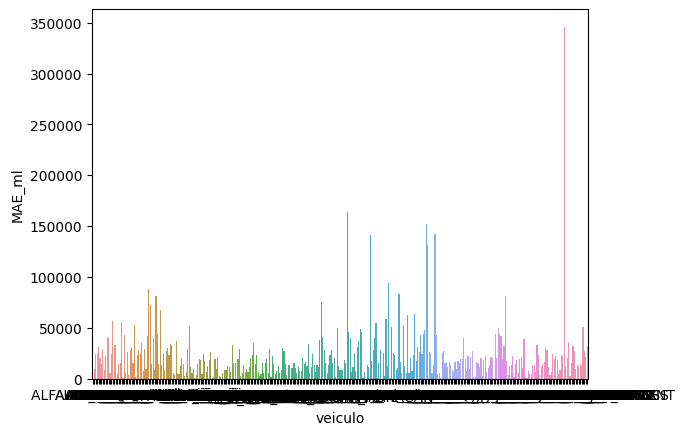

In [275]:
sns.barplot(y='MAE_ml', x = 'veiculo', data=df10_aux8)

In [280]:
df10_aux8['diff'] = df10_aux8['MAE_baseline'] - df10_aux8['MAE_ml'] 

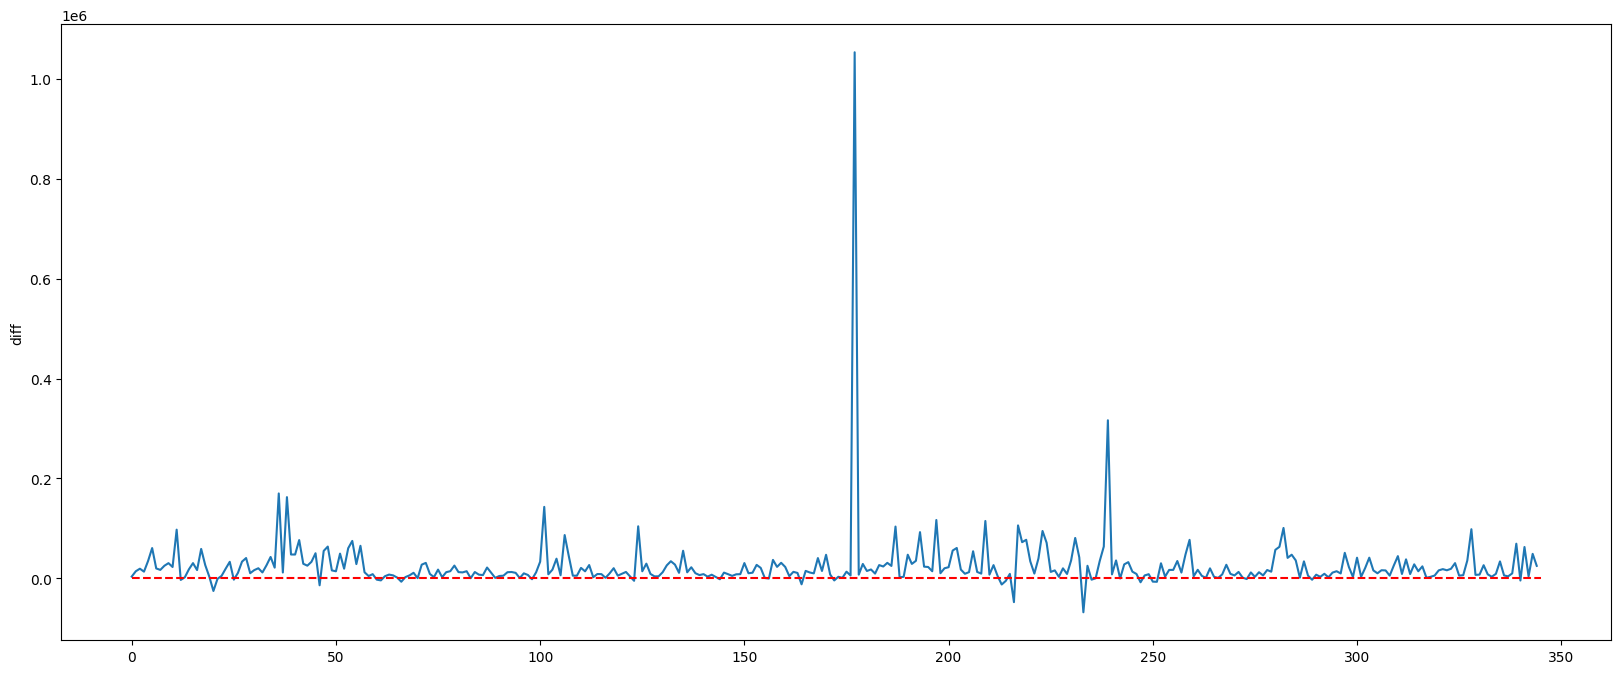

In [286]:
plt.figure(figsize=(20,8))
sns.lineplot(x=df10_aux8.index, y='diff', data=df10_aux8)
plt.hlines(xmax=df10_aux8.shape[0], xmin=0, y =0, linestyles='--', color='red')

## Machine Learning Performance

In [168]:
data_prod['error'] = data_prod['preco_modelo'] - data_prod['preco']
data_prod['error_baseline'] = data_prod['preco_medio'] - data_prod['preco']

In [169]:
data_prod['error_rate'] = data_prod['preco_modelo'] / data_prod['preco']
data_prod['error_rate_baseline'] = data_prod['preco_medio'] / data_prod['preco']

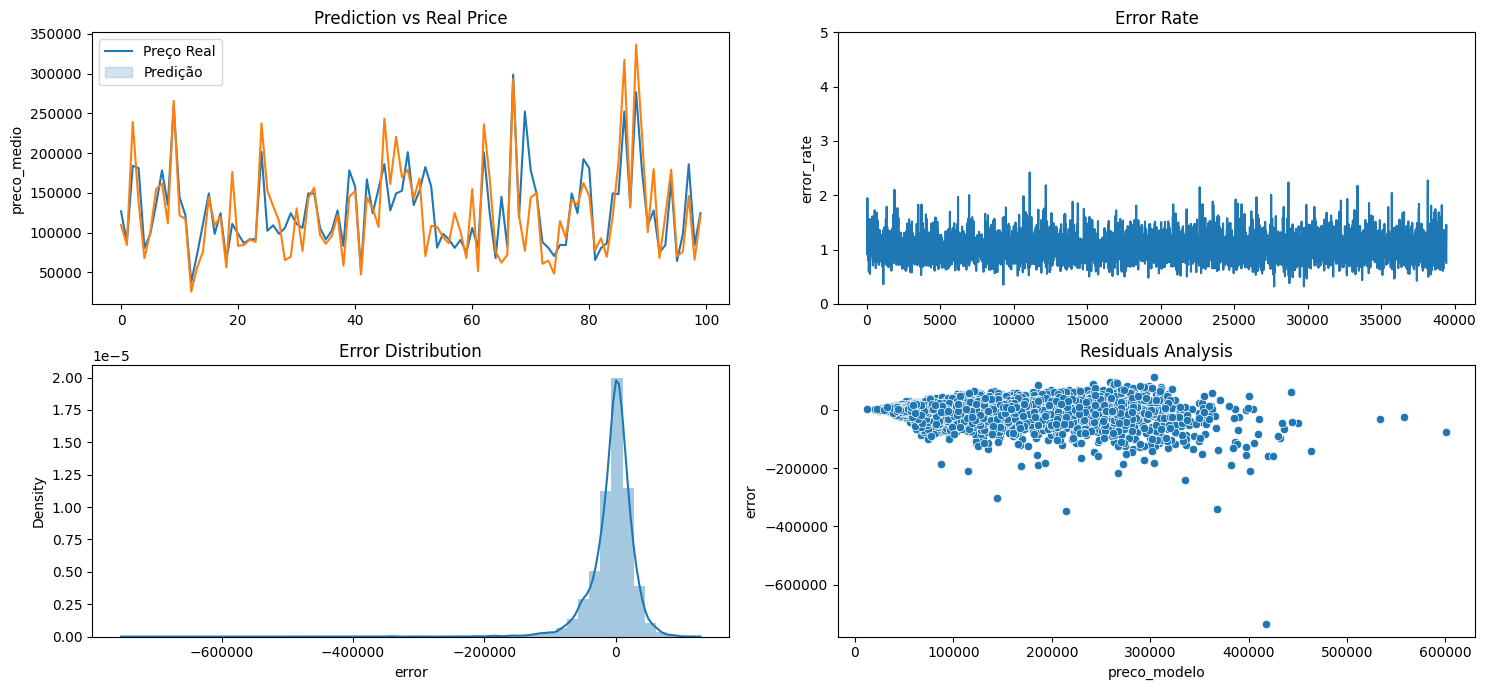

In [171]:
plt.figure(figsize=(15,7))
plt.subplot(2, 2, 1)
plt.title('Prediction vs Real Price')
sns.lineplot(x = range(0,100), y = 'preco_medio', data = data_prod.iloc[0:100])
sns.lineplot(x = range(0,100), y = 'preco_modelo', data = data_prod.iloc[0:100])
plt.legend(['Preço Real', 'Predição'])

plt.subplot(2, 2, 2)
plt.title('Error Rate')
sns.lineplot(x = data_prod.index , y='error_rate', data=data_prod)
plt.ylim(0,5)

plt.subplot(2, 2, 3)
plt.title('Error Distribution')
sns.distplot(data_prod['error'])

plt.subplot(2, 2, 4)
plt.title('Residuals Analysis')
sns.scatterplot(x = 'preco_modelo', y = 'error', data=data_prod.loc[data_prod['preco_modelo']<10**6])
plt.tight_layout()

# Deploy Model

## Mobility Class

In [134]:
import pickle
import pandas as pd
import numpy as np

class MobilityCars():
    
    def __init__(self):
        self.home_path = 'C:/Users/Notebook/repos/Mobility-Cars/api/'
        self.sc_km_media_ano        = pickle.load(open(self.home_path + 'parameters/sc_km_media_ano.pkl','rb'))
        self.rs_ano_de_fabricacao   = pickle.load(open(self.home_path + 'parameters/rs_ano_de_fabricacao.pkl','rb'))
        self.rs_ano_modelo          = pickle.load(open(self.home_path + 'parameters/rs_ano_modelo.pkl','rb'))
        self.rs_odometro            = pickle.load(open(self.home_path + 'parameters/rs_odometro.pkl','rb'))
        self.oe_tipo_anuncio        = pickle.load(open(self.home_path + 'parameters/oe_tipo_anuncio.pkl', 'rb'))
        self.te_tipo                = pickle.load(open(self.home_path + 'parameters/te_tipo.pkl','rb'))
        self.te_cor                 = pickle.load(open(self.home_path + 'parameters/te_cor.pkl','rb'))
        self.te_localidade_vendedor = pickle.load(open(self.home_path + 'parameters/te_localidade_vendedor.pkl','rb'))
        self.te_valvulas            = pickle.load(open(self.home_path + 'parameters/te_valvulas.pkl','rb'))
        self.te_combustivel         = pickle.load(open(self.home_path + 'parameters/te_combustivel.pkl','rb'))
        self.te_veiculo             = pickle.load(open(self.home_path + 'parameters/te_veiculo.pkl','rb'))
        self.fe_marca               = pickle.load(open(self.home_path + 'parameters/fe_marca.pkl', 'rb'))
        self.fe_modelo              = pickle.load(open(self.home_path + 'parameters/fe_modelo.pkl', 'rb'))
        self.fe_versao              = pickle.load(open(self.home_path + 'parameters/fe_versao.pkl', 'rb'))
        self.fe_cilindradas         = pickle.load(open(self.home_path + 'parameters/fe_cilindradas.pkl', 'rb'))
        
    def deta_cleaning(self, df):
        
        # removendo colunas que possuem NA's + id
        ## Filtering Data
        cols_drop = [
         'ID',
         'num_fotos',
         'attr_veiculo_aceita_troca',
         'attr_veiculo_unico_dono',
         'attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria',
         'attr_veiculo_ipva_pago',
         'attr_veiculo_licenciado',
         'attr_veiculo_garantia_de_fabrica',
         'attr_veiculo_todas_as_revisoes_feitas_pela_agenda_do_carro',
         'attr_veiculo_alienado']

        df = df.drop(columns=cols_drop)
        
        return df
    
    def feature_engineering(self, df4):
        ## Feature Engineering
        # extraindo as cilindradas da coluna versão
        df4['cilindradas'] = df4['versao'].apply(lambda x: extract_power(re.search(r"\d+\.\d+",x)))

        # extraindo válvulas da coluna versão
        df4['valvulas'] = df4['versao'].apply(lambda x: extract_power(re.search(r"\d+V",x)))

        # extraindo combustível da coluna versão
        df4['combustivel'] = df4['versao'].apply(lambda x: 'GASOLINA' if 'GASOLINA' in x else 
                                                           'FLEX' if 'FLEX'     in x else 
                                                           'DIESEL' if 'DIESEL'   in x else 
                                                           'ÁLCOOL' if 'ÁLCOOL' in x else
                                                           'HÍBRIDO' if 'HYBRID' in x else
                                                           'HÍBRIDO' if 'HÍBRIDO' in x else 'sem informação')

        # removendo features derivadas da coluna original
        df4['versao'] = df4.apply(lambda x: x['versao'].replace(x['cilindradas'],'').replace(x['valvulas'], '').replace(x['combustivel'],'').replace(' AUTOMÁTICO', '').replace(' MANUAL', '').replace('  ',' '), axis=1)

        # retirando acentos, substituindo letras maiúsculas e espaços
        df4['cidade_vendedor'] = df4['cidade_vendedor'].apply(lambda x: unidecode(x).lower().replace(' ','_'))

        # extraindo estado
        df4['estado_vendedor'] = df4['estado_vendedor'].apply(lambda x: re.search(r'\((.*?)\)',x).group(1))

        # criando feature de localidade
        df4['localidade_vendedor'] = df4['cidade_vendedor'] + "_" + df4['estado_vendedor']

        # criando feature de km médio rodado por ano
        df4['km_media_ano_em_1k_km'] = df4['odometro']/np.round(2023 - df4['ano_modelo'] + 0.51,0)
        # arredondando e escalando por 1000 km
        df4['km_media_ano_em_1k_km'] = round(df4['km_media_ano_em_1k_km'] / 1000, 0).astype(int)

        # criando feature de agregação do veículo com marca, modelo, km_media e localidade
        df4['veiculo'] = df4['marca'].astype(str) + "_" + df4['modelo'].astype(str) + "_" + df4['km_media_ano_em_1k_km'].astype(str)
        
        return df4

    
    def data_preparation_model(self, df_prep):
        
        ## Standarization
        df_prep['km_media_ano_em_1k_km'] = self.sc_km_media_ano.transform(df_prep[['km_media_ano_em_1k_km']])


        # 6.4  Rescaling
        # 6.4.1  Robust Scaler

        df_prep['ano_de_fabricacao'] = self.rs_ano_de_fabricacao.transform(df_prep[['ano_de_fabricacao']])
        df_prep['ano_modelo'] = self.rs_ano_modelo.transform(df_prep[['ano_modelo']])
        df_prep['odometro'] = self.rs_odometro.transform(df_prep[['odometro']])

        # 6.5  Encodings
        # 6.5.1  One Hot Encode
        # blindado
        df_prep['blindado'] = df_prep['blindado'].replace({'S':1, 'N':0})

        # tipo_vendedor
        df_prep['tipo_vendedor'] = df_prep['tipo_vendedor'].replace({'PJ':1, 'PF':0})

        # tipo_anuncio
        cols_dummies = self.oe_tipo_anuncio.transform(df_prep['tipo_anuncio'].values.reshape(-1,1))
        df_prep[self.oe_tipo_anuncio.categories_[0]] = cols_dummies

        df_prep['cambio'] = df_prep['cambio'].map({'Manual':0,
                                                    'Automática Sequencial':1, 
                                                    'Semi-automática':2,
                                                    'CVT':3,
                                                    'Automatizada':4,
                                                    'Automática':4,
                                                    'Automatizada DCT':5
                                                    })

        df_prep['num_portas'] = df_prep['num_portas'].apply(lambda x: 1 if x > 2 else 0)

        # 6.5.2  Target Enconde
        # ['tipo','cor', 'localidade_vendedor','valvulas','combustivel', 'veiculo']:

        df_prep = self.te_tipo.transform(df_prep)
        df_prep = self.te_cor.transform(df_prep)
        df_prep = self.te_localidade_vendedor.transform(df_prep)
        df_prep = self.te_valvulas.transform(df_prep)
        df_prep = self.te_combustivel.transform(df_prep)
        df_prep = self.te_veiculo.transform(df_prep)


        # 6.5.3  Frequency Encode
        # 'marca', 'modelo','versao','cilindradas'

        df_prep = self.fe_marca.transform(df_prep)
        df_prep = self.fe_modelo.transform(df_prep)
        df_prep = self.fe_versao.transform(df_prep)        
        df_prep = self.fe_cilindradas.transform(df_prep)
        
        features_selected = [
        'veiculo',
        'marca',
        'km_media_ano_em_1k_km',
        'modelo',
        'versao',
        'ano_de_fabricacao',
        'ano_modelo',
        'odometro',
        'cambio',
        'tipo',
        'cilindradas',
        'combustivel',
        'localidade_vendedor'
        ]
        
        return df_prep[features_selected]
    
    
    def get_prediction(self, model, original_data, test_data):
        
        pred = model.predict(test_data)
        
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records', data_format = 'iso')

## API Handler

In [137]:
from flask import Flask, request, Response
import pickle
import pandas as pd
# from mobility import MobilityCars

model = pickle.load(open('api/model/model_xgb.pkl', 'rb'))

app = Flask(__name__)

@app.route('/C:/Users/Notebook/repos/Mobility-Cars/mobility/predict', methods = ['POST'])
def mobility_preditc():
    test_json = request.get_json()
    if test_json:
        if isinstance(test_json, dict):
            test_raw = pd.DataFrame(test_json, index=[0])
        else:
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
    
        ## Instantiate
        pipeline = MobilityCars()

        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)

        # feature engineering
        df2 = pipeline.feature_engineering(df1)

        # data preparation
        df3 = pipeline.data_preparation_model(df2)

        # predict
        df_response = pipeline.get_prediction( model, test_raw, df3)

        return df_response
    else:
            return Response('{}', status=200, mimutype = 'application/json')
                    
if __name__ == '__main__':
    app.run('192.168.18.4')

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://192.168.18.4:5000
Press CTRL+C to quit


## API Tester

## Final Table

In [202]:
df_test = pd.read_csv('datasets/teste.csv')
df_test.columns = [unidecode(col).lower().replace(' ','_') for col in df_test.columns]

In [203]:
# request of all test data
# url = 'https://mobility-cars.onrender.com/mobility/predict'
url = 'http://192.168.18.4:5000/mobility/predict'
header = {'Content-type':'application/json'}
data = json.dumps(df_test.to_dict(orient='records'))

r = requests.post(url, data = data, headers = header)
print('Status Code: {}'.format(r.status_code))

# transform in DataFrame
test_predicts_raw = pd.DataFrame(r.json())

Status Code: 200


In [204]:
df_submission = test_predicts_raw[['id','prediction']].rename(columns={'id':'ID', 'prediction':'preco'})

In [205]:
df_submission.to_csv('late_submission_7.csv', index=False)

In [116]:
df_test = feature_engineering(df_test)

In [117]:
df_test['preco sugerido'] = test_predicts_raw['prediction']

In [119]:
df_test.to_csv('Tabela de Preços.csv', index=False)